# P4 Scoring Model

## Import des librairies

In [157]:
import xgboost as xgb
import time
import seaborn as sns
import pandas as pd 
import os
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from matplotlib.ticker import PercentFormatter
from IPython.display import display, HTML
from contextlib import contextmanager
%matplotlib inline

In [158]:
pd.set_option('display.max_row', 140)
pd.set_option('display.max_column', 122)

In [159]:
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("seaborn version:", sns.__version__)

pandas version: 2.2.3
numpy version: 2.1.1
seaborn version: 0.13.2


In [160]:
def display_info(title = "",titleTag="h2",tag="div",pTag="p",message="Params allowed: title,tag,message,color",bgd="#96d6ee", styleClass="alert alert-block alert-info", fontsize="" , color="black"):
    if (title!=""):
        display(HTML(f"""<{titleTag} style='color:{color};font-size:{fontsize}'>{title}</{titleTag}>"""))
    else:
        display(HTML(f"""
                     <{tag} style='background:{bgd}; padding-top:5px; padding-bottom:5px; padding-left:10px;' class='{styleClass}'><{pTag} style='color:{color}; font-size:{fontsize}'>{message}</{pTag}></{tag}>
"""))

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c' >9152465 valeurs manquantes, soit 24.39% du dataset</span></div>

## Importation des données

Les données sont réparties dans les fichiers ci-dessous:

In [161]:
display_info(message="Voici la liste des différents fichiers disponibles :",styleClass="alert alert-block alert-info",tag='div', pTag='span')
print(os.listdir("../datas"))

['application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


et lié selon le graphique suivant:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

**application_{train|test}.csv** <br>
Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

**bureau.csv**<br>
Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit (pour les clients qui ont un prêt dans notre échantillon).
Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.

**bureau_balance.csv**<br>
Soldes mensuels des crédits antérieurs au bureau de crédit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-à-dire que le tableau a (nombre de prêts dans l'échantillon * nombre de crédits précédents relatifs * nombre de mois où nous avons un historique observable pour les crédits précédents) lignes.

**POS_CASH_balance.csv**<br>
Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait contractés avec Home Credit.
Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (nombre de prêts dans l'échantillon * nombre de crédits précédents relatifs * nombre de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).

**credit_card_balance.csv**<br>
Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit.
Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (nombre de prêts dans l'échantillon * nombre de cartes de crédit précédentes relatives * nombre de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

**previous_application.csv**<br>
Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon.
Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

**installments_payments.csv**<br>
Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon.
Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit immobilier lié aux prêts de notre échantillon.

**HomeCredit_columns_description.csv**<br>
Ce fichier contient les descriptions des colonnes des différents fichiers de données.


In [731]:
app_train = pd.read_csv('../datas/application_train.csv')
app_test = pd.read_csv('../datas/application_test.csv')
bureau = pd.read_csv('../datas/bureau.csv')
bureau_balance = pd.read_csv('../datas/bureau_balance.csv')
pos_CASH_balance = pd.read_csv('../datas/POS_CASH_balance.csv')
credit_card_balance = pd.read_csv('../datas/credit_card_balance.csv')
previous_application = pd.read_csv('../datas/previous_application.csv')
installments_payments = pd.read_csv('../datas/installments_payments.csv')
columns_description = pd.read_csv('../datas/HomeCredit_columns_description.csv', sep=';', encoding="unicode_escape")

In [163]:
# Liste des datasets et titres
datasets = [app_train,app_test, bureau, bureau_balance, pos_CASH_balance, credit_card_balance,
            previous_application, installments_payments, columns_description]

titles = ["app_train","app_test", "bureau", "bureau_balance", "pos_CASH_balance", "credit_card_balance",
          "previous_application", "installments_payments", "columns_description"]

# Création du DataFrame avec les infos
info_df = pd.DataFrame({},)
info_df['Dataset'] = titles

info_df["nbrs_of_columns"] = [len(df.columns) for df in datasets]

# Remplacement des virgules par des sauts de ligne
info_df["columns_name"] = [', '.join(list(df.columns)) for df in datasets]

info_df['nbrs_of_rows'] = [len(df) for df in datasets]

info_df.style.background_gradient(cmap='rocket')


In [164]:
display_info(title="1 &nbsp Exploratory Data Analysis (EDA)", fontsize="30px", color="blue")
display_info(title="Analyse Univarié", fontsize="28px", color="red")
display_info(title="Analyse de la forme de notre dataset", fontsize="26px", color="green")
display_info(pTag="ul", message="""<li>Identification de la target de notre dataset 'application_train' : TARGET</li></br>
             <li>Nombre de lignes et colonnes : 307511 lignes et 122 colonnes</li></br>
             <li>Type de variables :</br></br>
             <ul>
             <li>float64: 65,</li>
             <li>int64: 41</li>
             <li>object: 16</li>
             </ul></br>
             <li>Identification des valeurs manquantes :</br></br>
             <ul>
             <li>Nombre de colonnes > 60% de NaN (17) </li></br>
             <li>Beaucoup des colonnes avec le plus grand % de valeurs manquant concerne le logement des clients</li></br>
             <li>Ext_SOURCE_1 qui est un score normalisé venant d'une source de données externe a 51.9% de valeurs manquantes</li>
             <li>Ext_SOURCE_2 qui est un score normalisé venant d'une source de données externe a 0.2% de valeurs manquantes</li>
             <li>Ext_SOURCE_3 qui est un score normalisé venant d'une source de données externe a 19.8% de valeurs manquantes</li>
             </ul>
             </li>""")
display_info(title="Analyse de fond de notre dataset", fontsize="26px", color="green")
display_info(pTag="ul", message="""<li>Visualisation de la target de notre dataset 'application_train' : environ 10% de client en difficulté</li></br>
             <li>Compréhension des différentes variables</br></br>
             <ul>
             <li>Les données ne sont pass normalisées</li>
             <li>L'age des clients (DAYS_BIRTH) varie de 20 à 70 ans</li>
             <li>Le nombre de jours d'ocuppation d'un emploi (DAYS_EMPLOYED) avant la demande de prêt présente des valeurs impossible</br>
             Les valeurs sont relative au jour de demande de prêt. Elle ne peuvent donc pas être positive</li>
             </ul></br>
             
             </li></br></br>
             <li>Variables catégorielles :</br></br>
             <ul>
             <li>Certaine variable sont binaire (Yes, No)</li>
             <li>D'autre représente la répartitions du status matrimonial ou encore le type de logement donc non binaire</li>
             </ul>
             </li></br></br>
             """)
display_info(title="Analyse Bi-variées", fontsize="28px", color="red")
display_info(pTag="ul", message="""
             <li>TARGET / Toutes variables AMT :</br></br>
             <ul>
             <li>Il n'y a pas de différence de distribution notable sur nos variables</li>
             </ul>
             </li></br>
             <li>TARGET / Toutes variables DAYS :</br></br>
             <ul>
             <li>Les distribution semble etre identique et proportionnel au statut du client</li>
             </ul>
             </li></br>
             <li>TARGET / DAYS_BIRTH avec un bin pour chaque années :</br></br>
             <ul>
             <li>Il n'y a pas de différence de distribution notable de notre target en fonction de l'age des clients</li>
             </ul>
             </li>
             """)
display_info(title="Conclusions initiales",color="blue")
display_info(message="""
             <li>Beaucoup de données manquantes</li>
             <li>La TARGET est desiquilibré  10% de client en difficulté pour 90% de client SANS difficulté </li>
             <li>Pas de différence notable de distribution entre les valeurs de la TARGET</li>
             """,pTag='ul')
display_info(title="Analyse multi-variées", fontsize="28px", color="red")
display_info(pTag="ul", message="""
             <li>Relation AMT / AMT PAIRPLOT:</li></br></br>
             <ul>
             <li>On remarque que AMT_CREDIT et AMT_GOODS_PRICE sont clairement corrélé</li></br>
             <li>AMT_INCOME_TOTAL ne semble pas avoir de pouvoir discriminant important sur les clients</li>
             </ul>
             </li></br></br>
             <li>Relation AMT / AMT matrice de correlation:</li></br></br>
             <ul>
             <li>On observe la forte correlation entre AMT_CREDIT et AMT_GOODS_PRICE (> 0.9)</li></br>
             <li>On observe aussi une forte correlation entre AMT_ANNUITY et AMT_GOODS_PRICE (>0.75)</li></br>
             <li>Ainsi qu'une forte correlation entre AMT_ANNUITY et AMT_CREDIT (>0.75)</li>
             </ul>
             </li></br></br>
             <li>Relation AMT / DAYS matrice de correlation:</li></br></br>
             <ul>
             <li>On observe la forte correlation entre AMT_CREDIT et AMT_GOODS_PRICE (> 0.9)</li></br>
             <li>On observe aussi une forte correlation entre AMT_ANNUITY et AMT_GOODS_PRICE (>0.75)</li></br>
             <li>Ainsi qu'une forte correlation entre AMT_ANNUITY et AMT_CREDIT (>0.75)</li>
             </ul>
             </li>
             """)

In [165]:
@contextmanager
def timer(title):
    t0=time.time()
    yield
    print("{} - terminé en {:.000f}s".format(title, time.time()-t0))

In [166]:
display_info(message="Split des données en 2 en gardant la même proposrtion au niveau de 'TARGET'")

def split_df(df):
    X=df
    initial_X_train, initial_y_train = train_test_split(X,test_size=0.5, stratify=df['TARGET'], random_state=42)
    return initial_X_train, initial_y_train
initial_X_train, initial_y_train= split_df(app_train)

In [167]:
print(f'initial_X_train.shape: {initial_X_train.shape}')
print(f'initial_y_train.shape: {initial_y_train.shape}')
# print(f'X_test.shape: {X_test.shape}')
# print(f'y_test.shape: {y_test.shape}')

initial_X_train.shape: (153755, 122)
initial_y_train.shape: (153756, 122)


        SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
281468      426087       0         Cash loans           F            Y   
168674      295517       0         Cash loans           F            N   
302449      450402       0         Cash loans           F            Y   
105299      222187       0         Cash loans           F            N   
260604      401592       0         Cash loans           M            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
281468               Y             0          135000.0    270000.0   
168674               Y             0           90000.0    107820.0   
302449               Y             1          135000.0    814041.0   
105299               Y             0          112500.0    331920.0   
260604               N             0          207000.0   1546020.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
281468      12987.0         270000.0   Unaccompanied         

(153755, 122)


SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


float64    65
int64      41
object     16
Name: count, dtype: int64


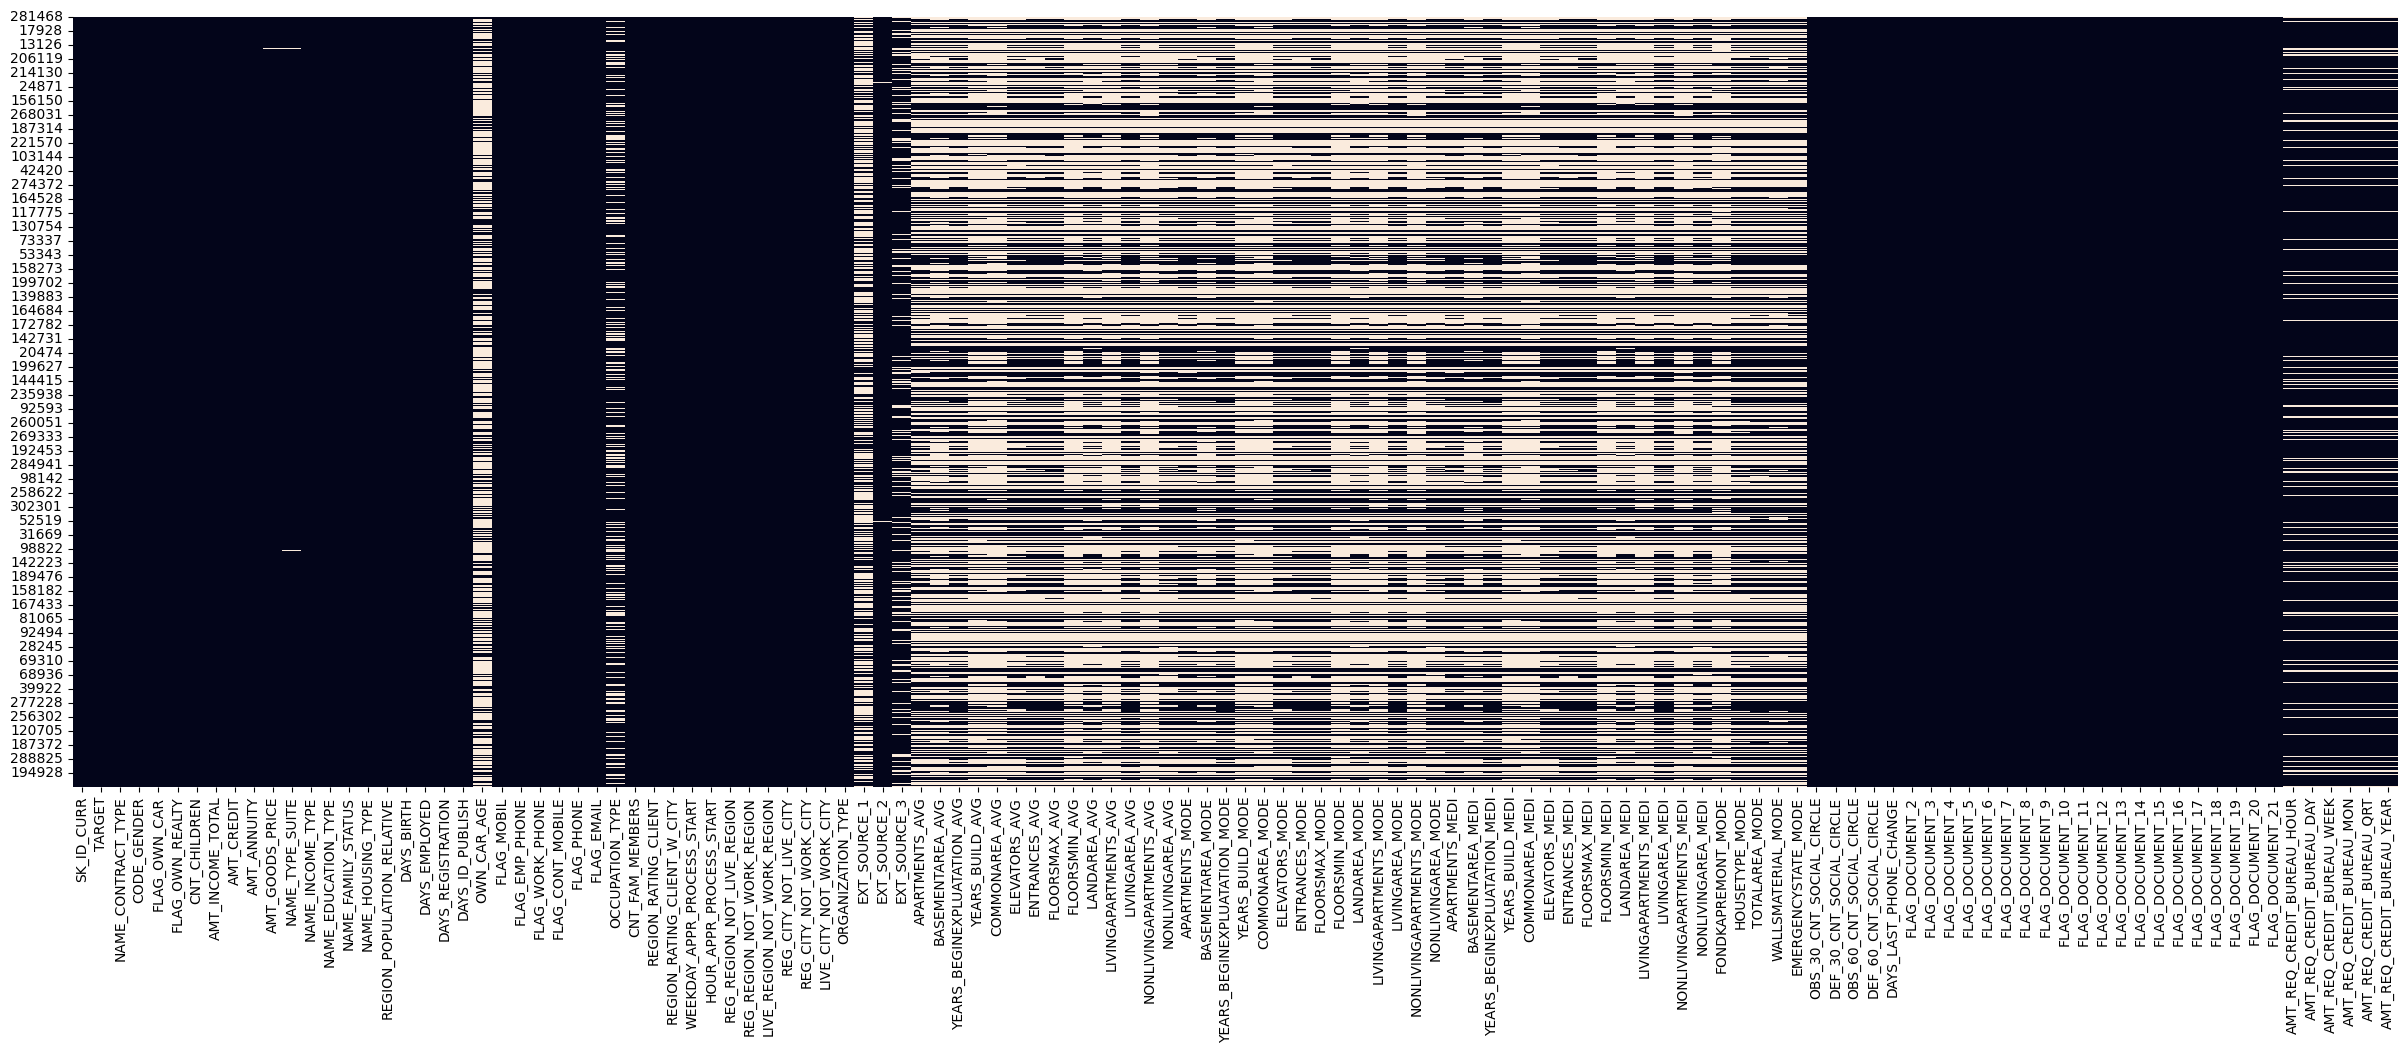

COMMONAREA_MEDI                 69.818868
COMMONAREA_AVG                  69.818868
COMMONAREA_MODE                 69.818868
NONLIVINGAPARTMENTS_MODE        69.378557
NONLIVINGAPARTMENTS_AVG         69.378557
NONLIVINGAPARTMENTS_MEDI        69.378557
FONDKAPREMONT_MODE              68.355501
LIVINGAPARTMENTS_MODE           68.313226
LIVINGAPARTMENTS_AVG            68.313226
LIVINGAPARTMENTS_MEDI           68.313226
FLOORSMIN_AVG                   67.854054
FLOORSMIN_MODE                  67.854054
FLOORSMIN_MEDI                  67.854054
YEARS_BUILD_MEDI                66.470033
YEARS_BUILD_MODE                66.470033
YEARS_BUILD_AVG                 66.470033
OWN_CAR_AGE                     66.043381
LANDAREA_MEDI                   59.276771
LANDAREA_MODE                   59.276771
LANDAREA_AVG                    59.276771
BASEMENTAREA_MEDI               58.414361
BASEMENTAREA_AVG                58.414361
BASEMENTAREA_MODE               58.414361
EXT_SOURCE_1                    56

Liste des colonnes inutiles :
 ['REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRAN

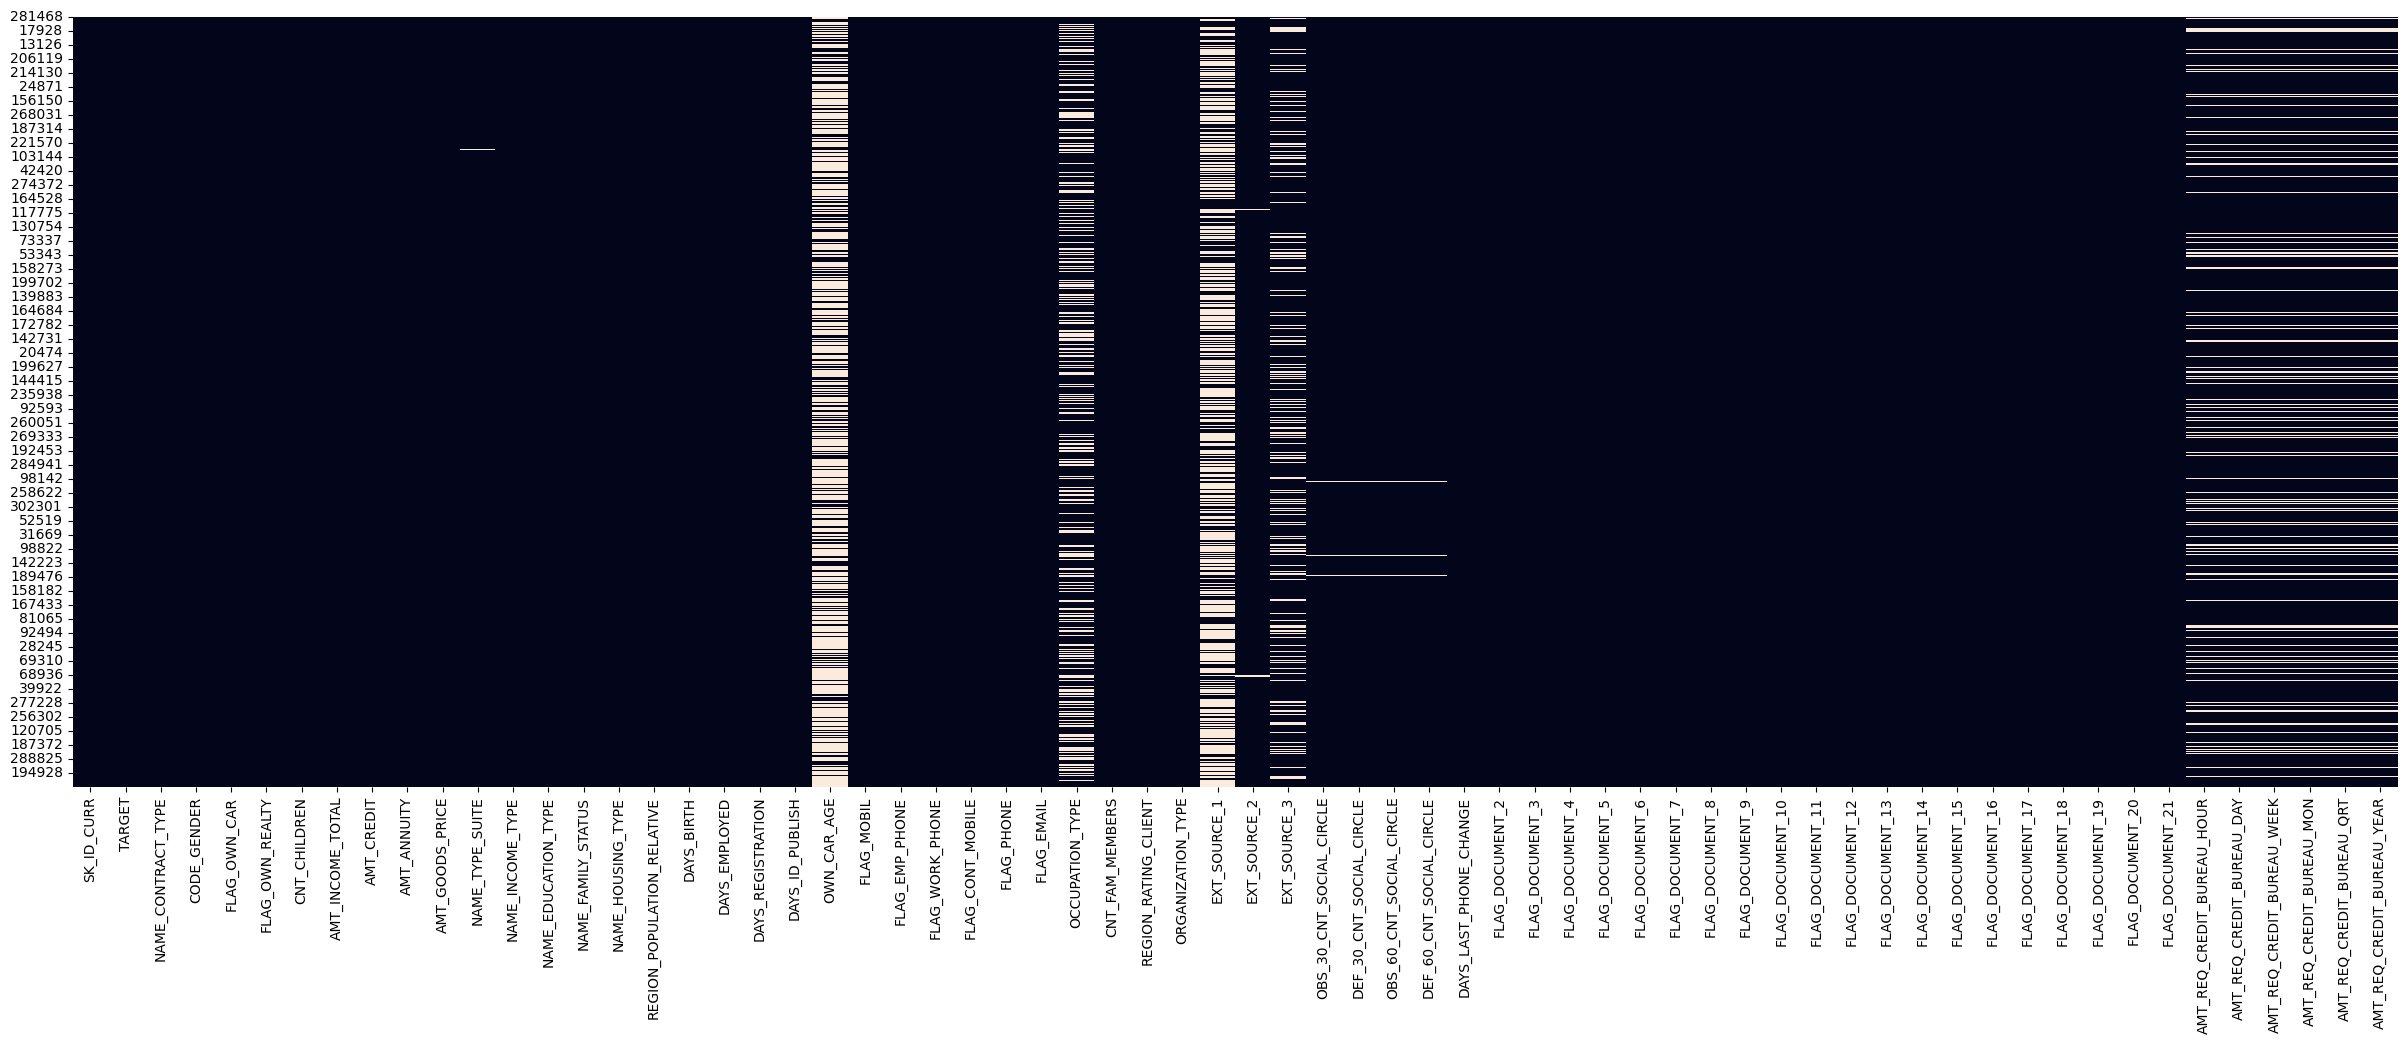

In [168]:
display_info(title="Exploratory Data Analysis (EDA)", color='blue', fontsize="30px")
display_info(message="Le head de notre dataset donne: ",bgd='green', color='white')

print(initial_X_train.head())

display_info(message="Les dimension du dataset sont: ", bgd='green', color='white')

print(initial_X_train.shape)

display_info(message="On retrouve le type de données suivantes: ", bgd='green', color='white')

print(initial_X_train.dtypes)

display_info(message=f'Voici le nombres de fois ou chaque types de valeurs apparait:</br>',fontsize="16px", color='white',bgd='green')

valueTypes=initial_X_train.dtypes.value_counts()

print(valueTypes)

def displayNan(df):
    plt.figure(figsize=(30,10))
    sns.heatmap(df.isna(), cbar=False)
    plt.show()

display_info(message=f'On représente les valeurs manquantes sous forme de heatmap',fontsize="16px",color='Black')

displayNan(initial_X_train)

display_info(message="""On remarque plusieurs individus avec des ligne de différentes variables vide.</br></br>
            Cela peut nous informer sur une éventuel correlation des variables entre elles.""",fontsize="16px",color='white',bgd='green')

display_info(title="""On va représenter les valeurs manquante en pourcentage""",color='blue')
display_info(message="""Pourcentage des valeurs manquantes du dataset 'application_train' :""",color='black')

print(((initial_X_train.isna().sum()/initial_X_train.shape[0])*100).sort_values(ascending=False))

display_info(message="""Nous ne souhaitons pas garder toutes nos colonnes""",color='black')

columnsTo_remove = initial_X_train.columns[initial_X_train.columns.str.contains('_MEDI$|_MODE$|_AVG$|_START$|_REGION$|_CITY$')].tolist()
print(f'Liste des colonnes inutiles :\n {columnsTo_remove}')

display_info(message=" On ne gardera pas les informations lié au logement dans notre analyse car cela peut changer en cours de prêt et n'est donc pas significatif")
X_train=initial_X_train.drop(columns=columnsTo_remove)

displayNan(X_train)

nanPercentage=(((X_train.isna().sum()/X_train.shape[0])*100)>60).sum()

display_info(message=f'Nombre de colonne avec 60 % de valeurs NaN : {nanPercentage} ')

display_info(title="""Eliminiation colonnes inutiles""", color="blue")
display_info(message="""On peut éliminer toute les colonne qui ne nous paraisse pas pertinente</br>
             ici on garde uniquement les colonnes ayant moins de 50% de valeurs manquantes afin de conserver au minimum la variable EXT_SOURCE_1 """)

display_info(color='White',title='On va vérifier que nous n\'avons pas 2 fois les même prêt dans notre Dataset ici la variable: SK_BUREAU_ID est l’identifiant unique d’un crédit signalé par le bureau de crédit ')
X_train_duplicated= X_train.duplicated(subset=['SK_ID_CURR']).sum()
display_info(message=f'Nombre de prêts unique dupliqués : {X_train_duplicated}')

In [169]:
display_info(title="Analyse Univarié", tag="h2", color="red", fontsize="28px")
display_info(title="Examen de notre colonne TARGET", tag="h2", color="green")

print(initial_y_train.value_counts())

display_info(message=f"On remarque que nos classes ne sont pas du tout équilibrées</br> 141343 TARGET 0 et</br> 12412 TARGET 1")

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  NAME_INCOME_TYPE      NAME_EDUCATION_TYPE            NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  ORGANIZATION_TYPE       EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPAR

In [170]:
display_info(title="histogrammes des variables continues", fontsize="24px", color='green')

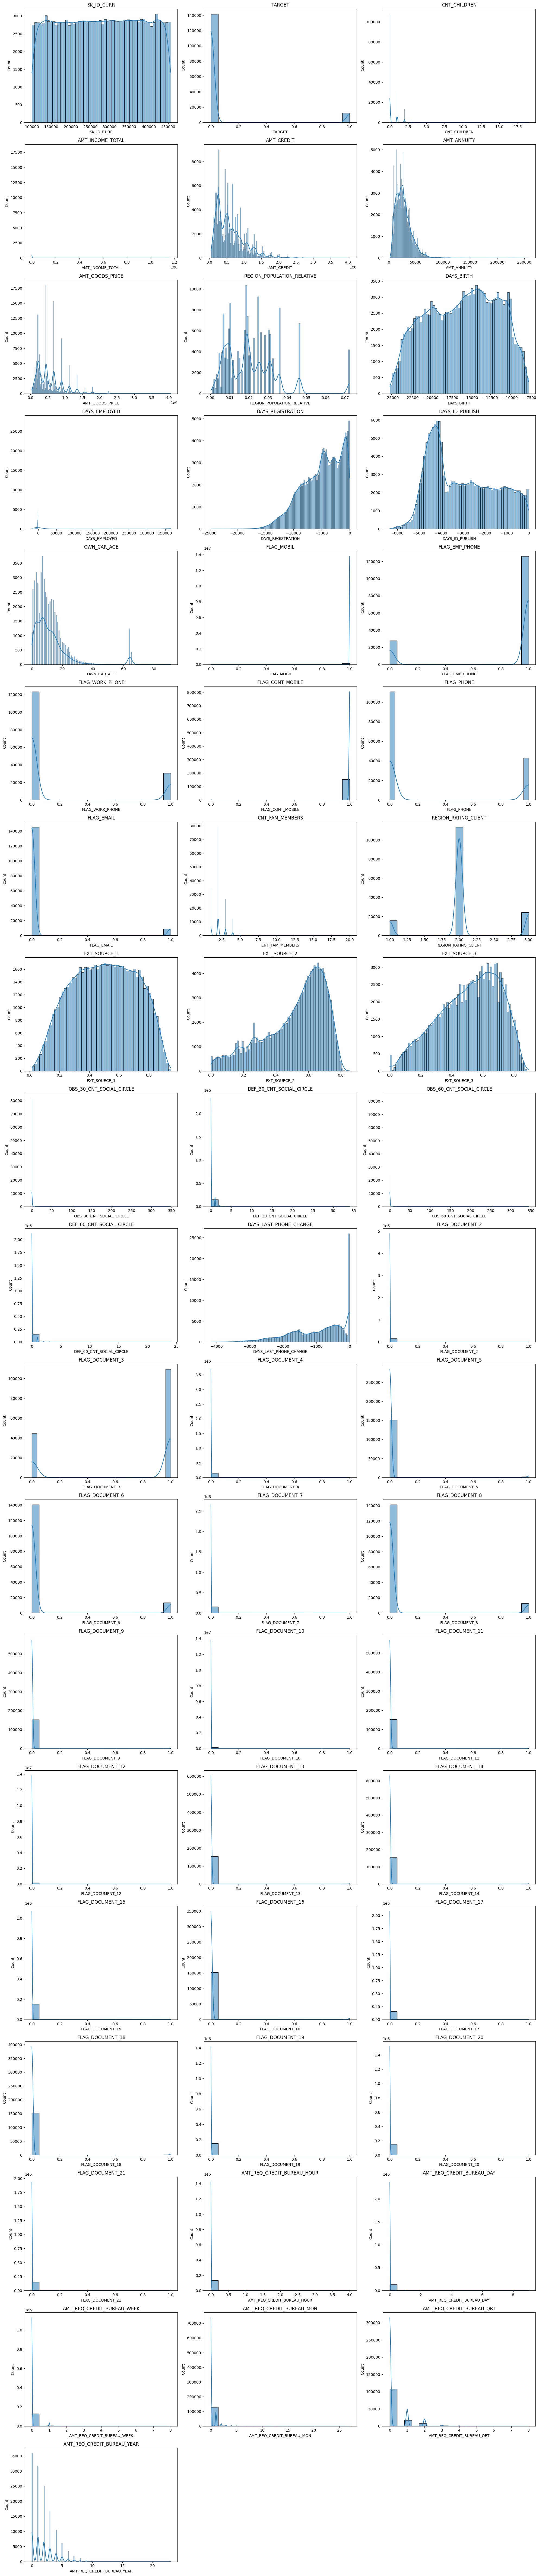

In [171]:

# Sélectionner les colonnes de type float64 et int64
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
# Définir la taille de la grille (3 graphiques par ligne)
n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Calculer le nombre de lignes nécessaires

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  # Ajuster la taille de la figure

# Boucle sur chaque colonne numérique
for i, col in enumerate(numeric_columns):
    row = i // n_cols
    col_position = i % n_cols
    
    # Tracer le graphique dans l'axe correspondant avec histplot
    sns.histplot(X_train[col], ax=axes[row, col_position], kde=True)
    axes[row, col_position].set_title(col)  # Ajouter un titre pour chaque sous-graphe

# Supprimer les axes vides si le nombre de graphiques n'est pas un multiple de 3
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()  # Ajuste la mise en page pour éviter le chevauchement
plt.show()

In [172]:
display_info(title="Compréhension des différentes variables", color="green")
display_info(message="On remarque que certaines variable on une distribution asymétrique.")
display_info(message="En revanche aucune d'elle ne suis une distribution normal")
display_info(message="Ces données n'ont pas l'air d'avoir été standardisées")


Text(0, 0.5, 'Nombre de clients')

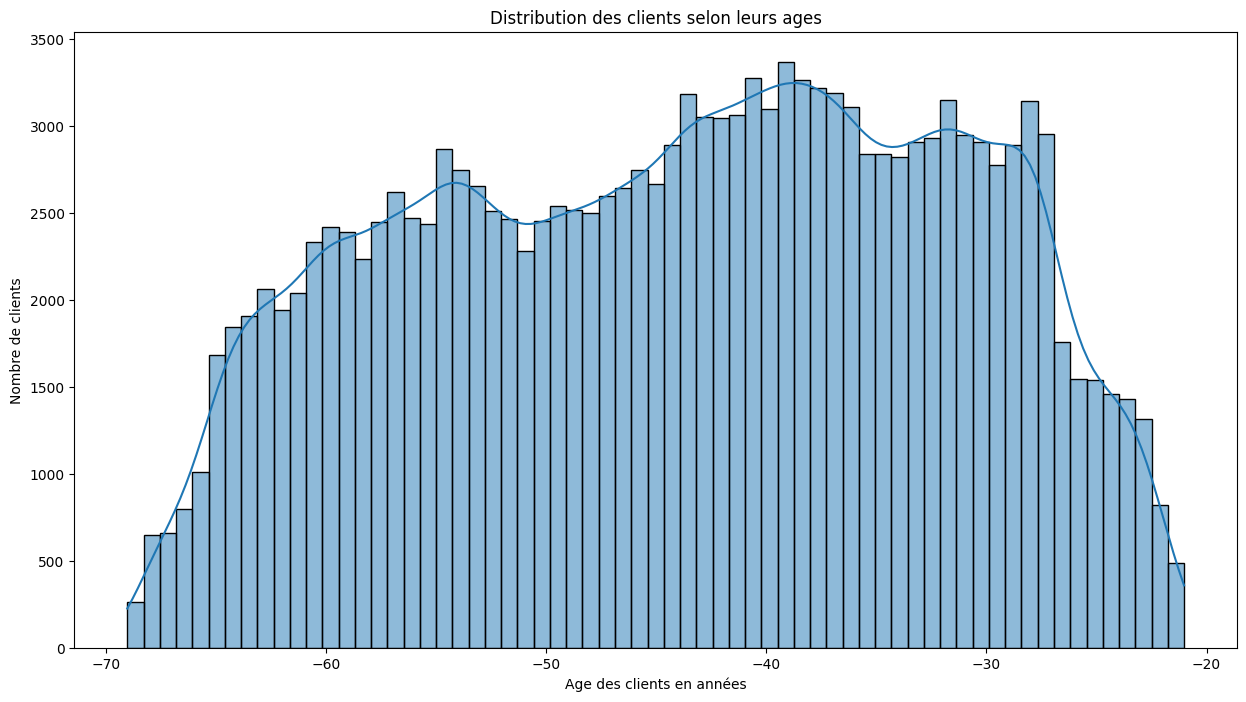

In [173]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.histplot(X_train['DAYS_BIRTH']/365, kde=True)
ax.set_title('Distribution des clients selon leurs ages')
ax.set_xlabel('Age des clients en années')
ax.set_ylabel('Nombre de clients')

In [174]:
display_info(message="L'age des client oscille entre 20 et 70 ans ce qui parait cohérent")

In [175]:
X_train['DAYS_EMPLOYED'].describe()

count    153755.000000
mean      63759.590804
std      141233.860279
min      -17583.000000
25%       -2761.000000
50%       -1214.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [176]:
display_info(title="Valeurs Impossibles", color='blue', fontsize="30px")
display_info(bgd='red', color='white',message="'DAYS_EMPLOYED' qui represente le nombre de jours avant la candidature ou la personne a commencé son emploi actuel a des valeurs positive</br>Ce qui n'est pas possible car cette variable est relative à la date d'application")
display_info(bgd='red', color='white',message="Si on regarde la répartition de ces valeurs, on a 55374 valeurs de  365 243 puis on reviens -200  'DAYS_EMPLOYED'")

In [177]:
X_train['DAYS_EMPLOYED'].value_counts().sort_values(ascending=False)

DAYS_EMPLOYED
 365243    27665
-200          85
-229          84
-231          79
-212          79
           ...  
-11495         1
-15911         1
-13045         1
-10274         1
-6374          1
Name: count, Length: 10928, dtype: int64

In [178]:
display_info(message="""Pour effectuer une annalyse pertinente, nous ne pouvons pas prendre en compte ces valeurs impossible</br>
             On va donc les remplacer par NaN et continuer notre analyse""")

In [179]:
X_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',


In [180]:
def manage_outliers(df):
    # X_train.loc[X_train['DAYS_EMPLOYED']>0, 'DAYS_EMPLOYED'] = np.nan
    df['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)
    return df

In [181]:
X_train=manage_outliers(X_train)
X_train.columns

/var/folders/gk/r5q0c38n70s02t1z45pl1x400000gp/T/ipykernel_58878/2337813907.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)


Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',


Text(0, 0.5, 'Nombre de clients')

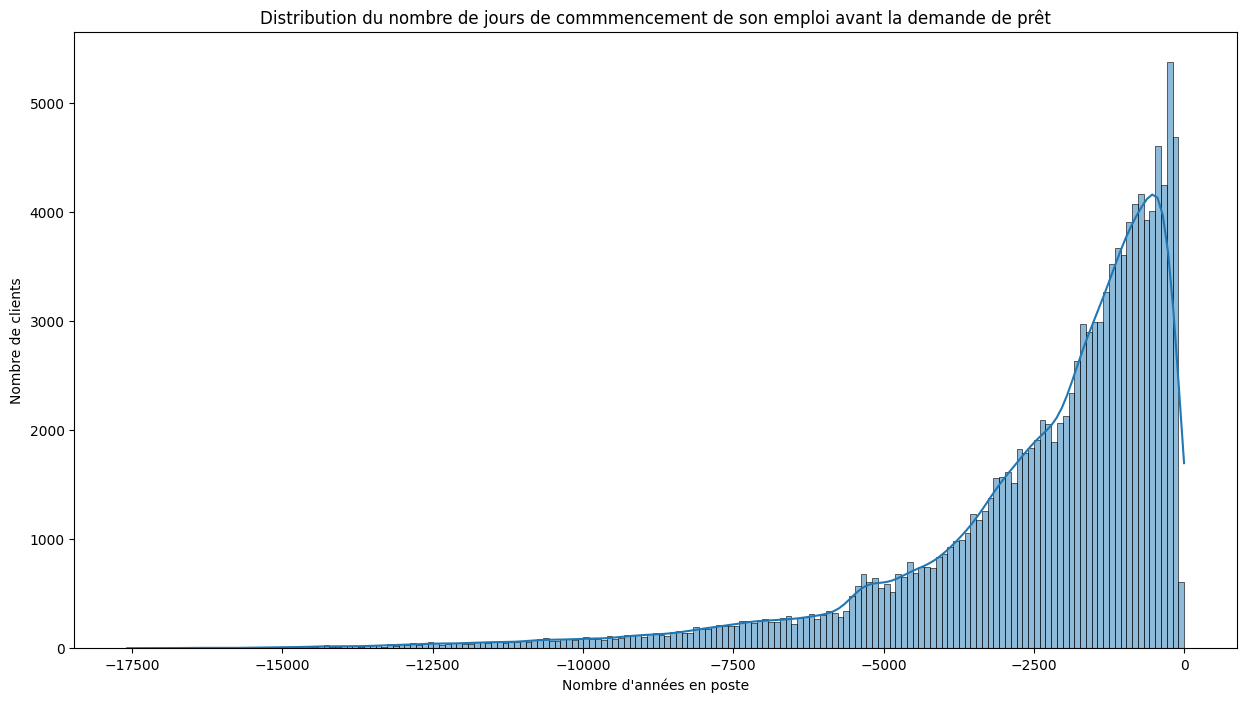

In [182]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.histplot(X_train['DAYS_EMPLOYED'], kde=True)
ax.set_title('Distribution du nombre de jours de commmencement de son emploi avant la demande de prêt')
ax.set_xlabel('Nombre d\'années en poste')
ax.set_ylabel('Nombre de clients')


In [183]:
display_info(title="Variables Qualitative", fontsize="24px", color='green')
display_info(message="On visualise dans un premier temps la liste des valeurs pour les différentes variables catégorielles:", fontsize="18px")
for col in X_train.select_dtypes('object'):
    print(f'{col:-<50} {X_train[col].unique()}')

NAME_CONTRACT_TYPE-------------------------------- ['Cash loans' 'Revolving loans']
CODE_GENDER--------------------------------------- ['F' 'M' 'XNA']
FLAG_OWN_CAR-------------------------------------- ['Y' 'N']
FLAG_OWN_REALTY----------------------------------- ['Y' 'N']
NAME_TYPE_SUITE----------------------------------- ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' nan 'Other_B'
 'Other_A' 'Group of people']
NAME_INCOME_TYPE---------------------------------- ['Working' 'Pensioner' 'State servant' 'Commercial associate' 'Student'
 'Unemployed' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE------------------------------- ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS-------------------------------- ['Married' 'Civil marriage' 'Single / not married' 'Widow' 'Separated']
NAME_HOUSING_TYPE--------------------------------- ['House / apartment' 'With parents' 'Municipal apartment'
 'Rented apart

In [184]:
X_train['TARGET'].value_counts()

TARGET
0    141343
1     12412
Name: count, dtype: int64

In [185]:
def plot_stat(data, feature, title) : 
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index, palette='Set2', hue=feature)
    ax.set_title(title, fontsize=20, fontweight='bold')

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    plt.show()
    print("---" * 25)
    
     # Graphique pour `target=1`
    target1 = data[data['TARGET'] == 1]
    cat_counts = target1[feature].value_counts().to_dict()  # Comptes de chaque catégorie pour `target=1`
    total_target1 = len(target1)  # Total des cas où `TARGET=1`

    fig, ax = plt.subplots(figsize=(20, 8))
    sns.countplot(y=feature, data=target1, hue=feature, order=target1[feature].value_counts(ascending=False).index, palette="Paired", ax=ax)
    ax.set_title(f"% {title} for client in difficulties: target = 1", fontsize=14, fontweight='bold')

    # Ajout des pourcentages pour `target=1`
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width() / len(data[feature]))  # Calcul du pourcentage
            x = p.get_x() + p.get_width()
            y = p.get_y() + p.get_height() / 2
            ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    plt.show()


In [186]:
X_train_target1 = X_train[X_train['TARGET']==1]
categorical_cols = X_train.select_dtypes('object').columns
categorical_cols

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE'],
      dtype='object')

In [187]:
display_info(title="Fonctions pour faciliter l'analyse des principales variables…", color='White')
display_info(message="""Il est important de se focaliser sur les principales features pouvant être explicatives. Ici l'idée n'est pas de tout analyser en univarié ou multivarié, mais simplement d'avoir une image des points métiers qui aident à orienter nos décisions dans la "prise de risque" à l'attribution d'un crédit.""")

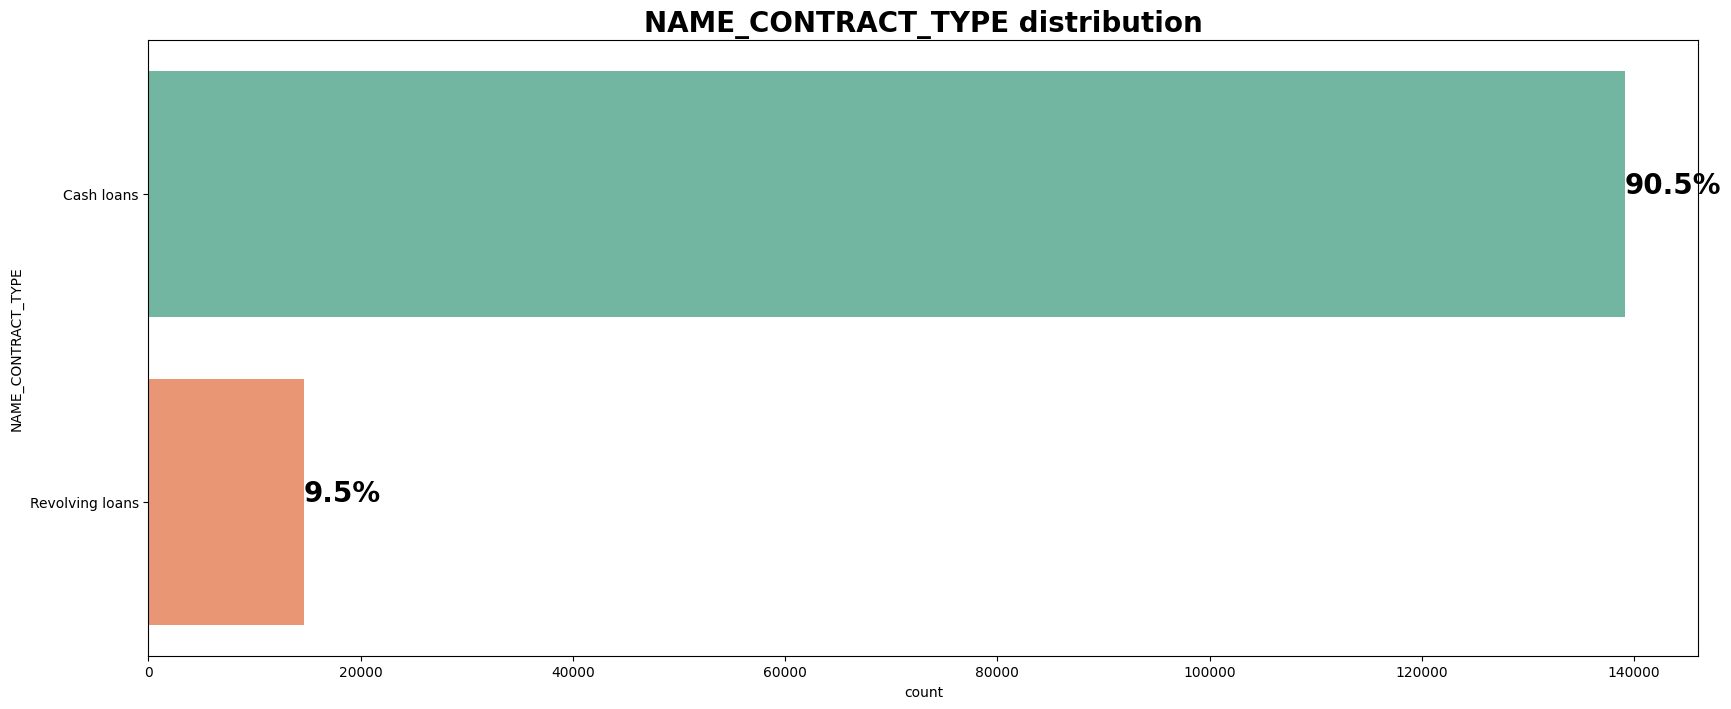

---------------------------------------------------------------------------


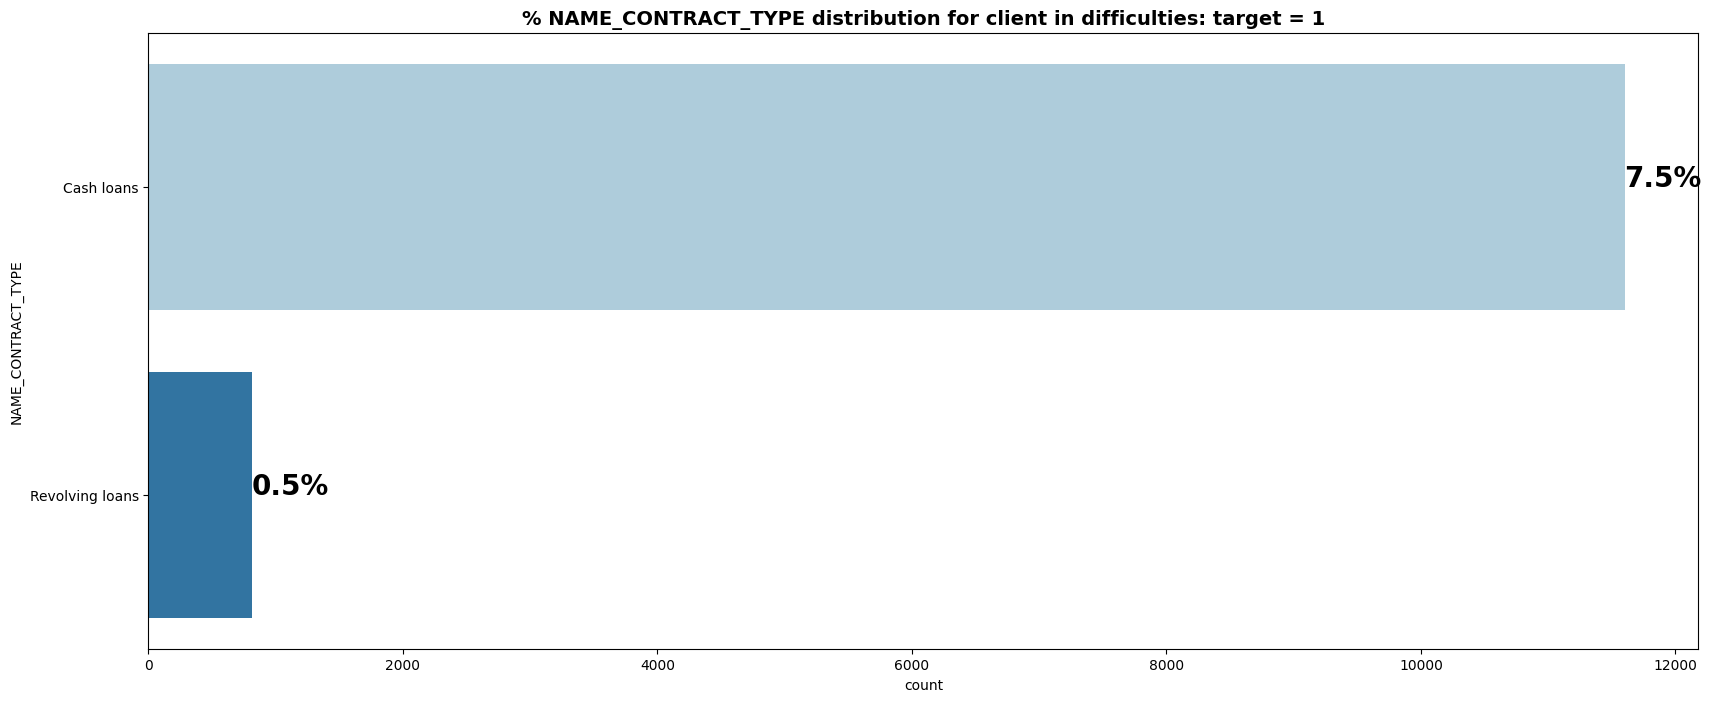

In [188]:
cat_feature='NAME_CONTRACT_TYPE'
display_info(message="Loan types - Distribution du type de prêts contractés + comparatif avec le pourcentage des prêts avec la valeur TARGET 1(prêt non retourné).")
plot_stat(X_train, cat_feature ,f"{cat_feature} distribution")
display_info(message="Les prêts renouvelables ne représentent qu'une petite fraction (10%) du nombre total de prêts; dans le même temps, un plus grand nombre de crédits renouvelables, par rapport à leur fréquence, ne sont pas remboursés.", bgd="green", color='White')


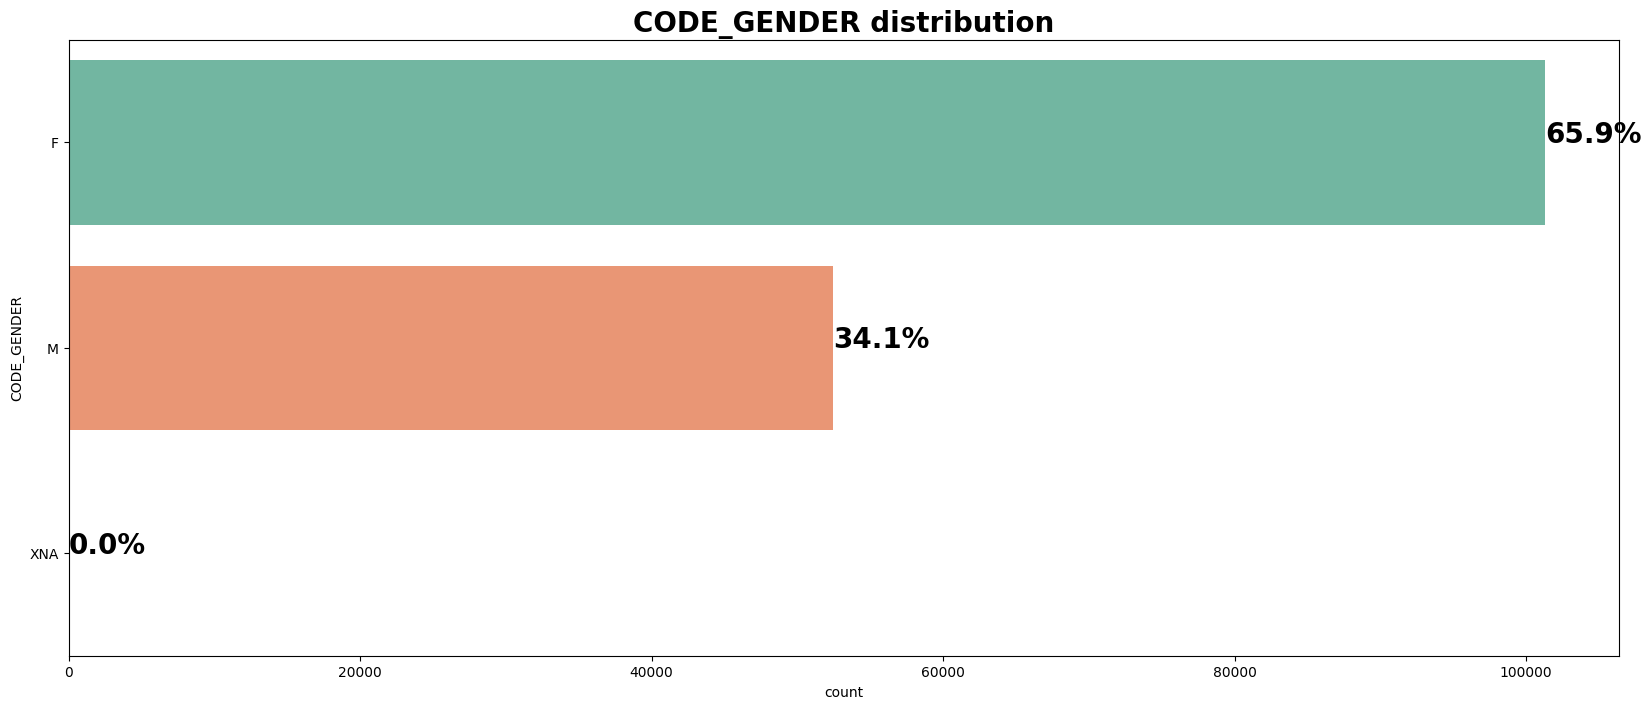

---------------------------------------------------------------------------


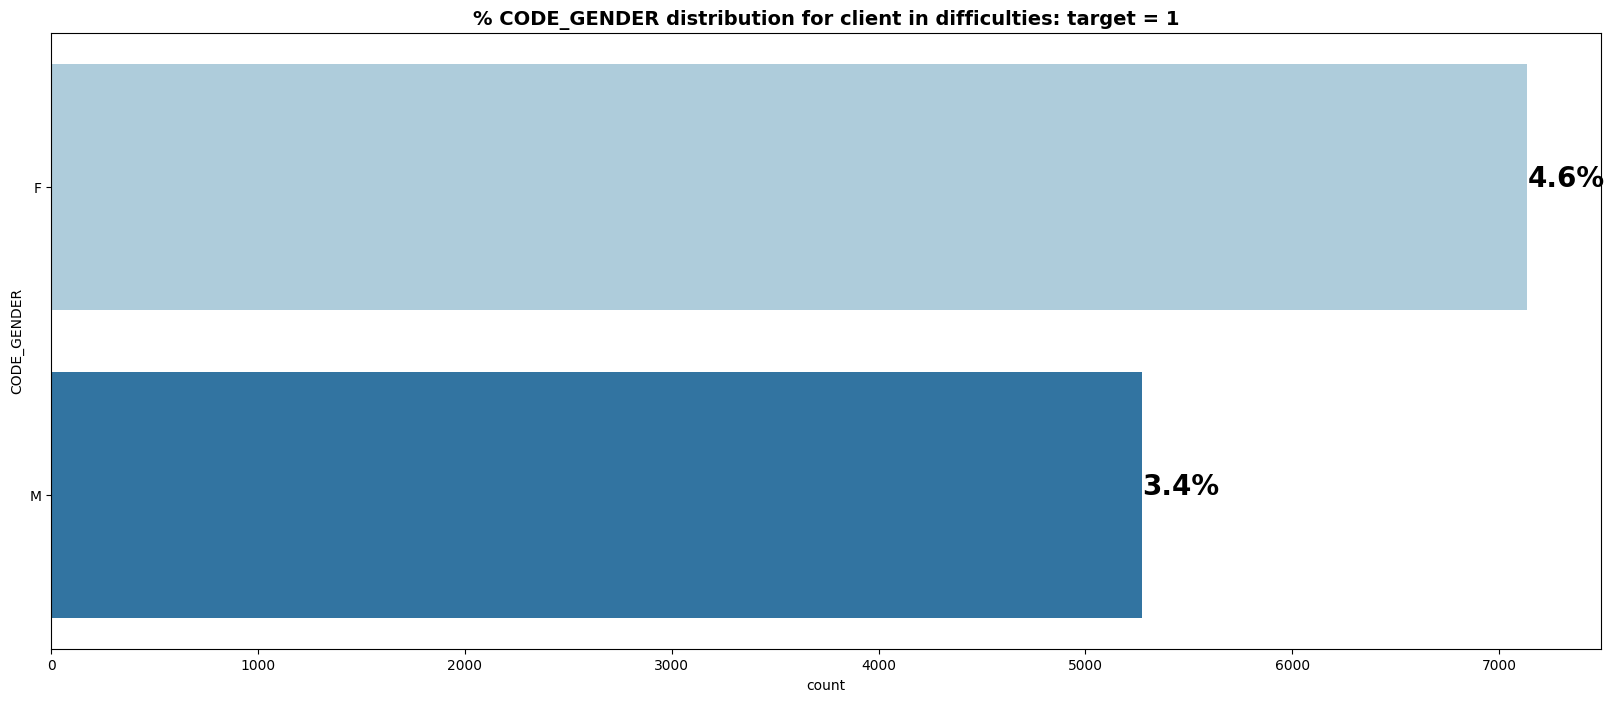

In [189]:
cat_feature='CODE_GENDER'
display_info(message="Client gender - Distribution H/F clients, mais aussi le pourcentage des prêts (par sexe du client) avec la valeur TARGET 1 (prêt non retourné).")
plot_stat(X_train, cat_feature ,f"{cat_feature} distribution")
display_info(bgd='green', color='White', message="Le nombre de clients féminins est presque le double du nombre de clients masculins. En ce qui concerne le pourcentage de crédits en souffrance, les femmes ont plus de chances de ne pas rembourser leurs prêts (4.6%), comparativement aux hommes (3.4%).")

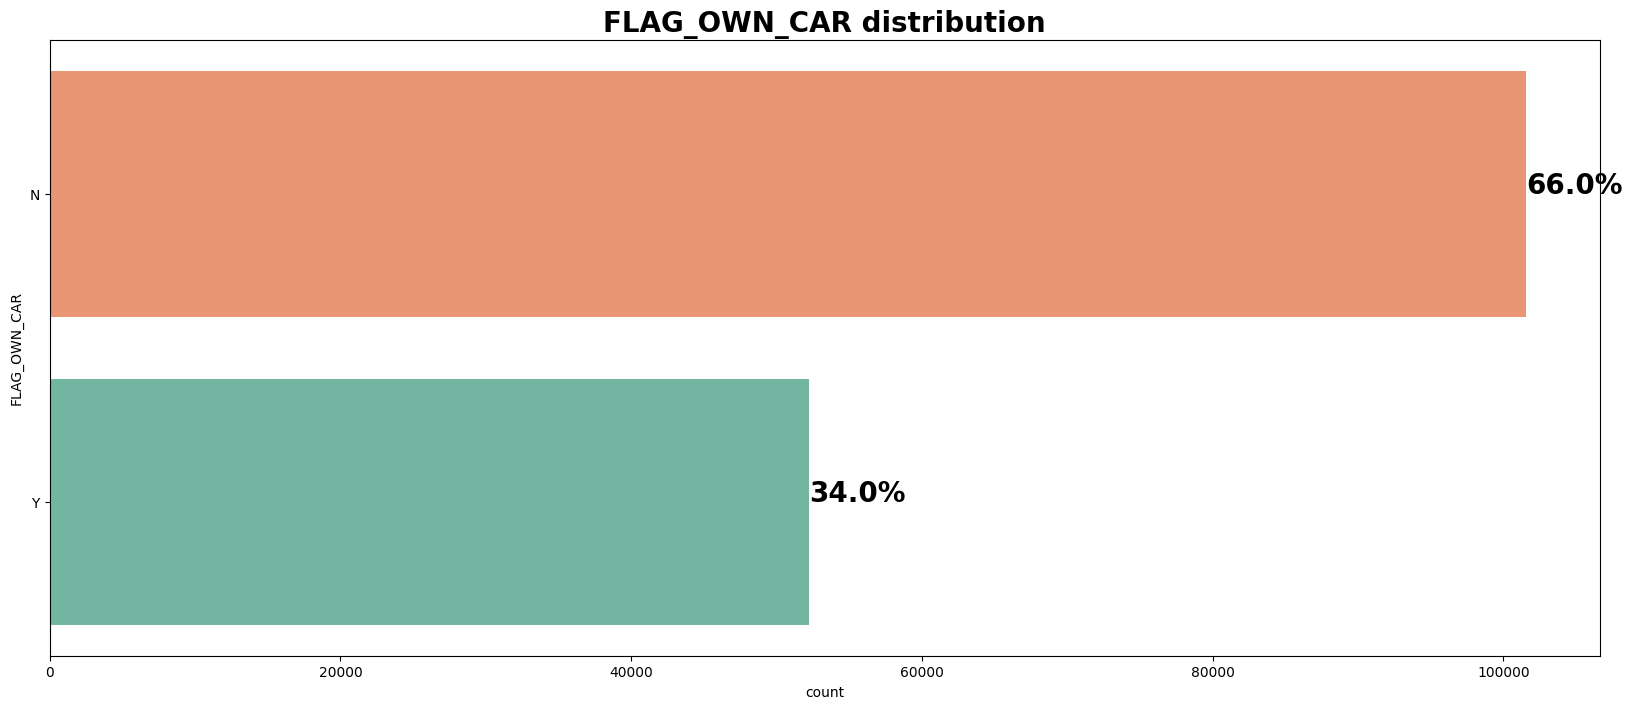

---------------------------------------------------------------------------


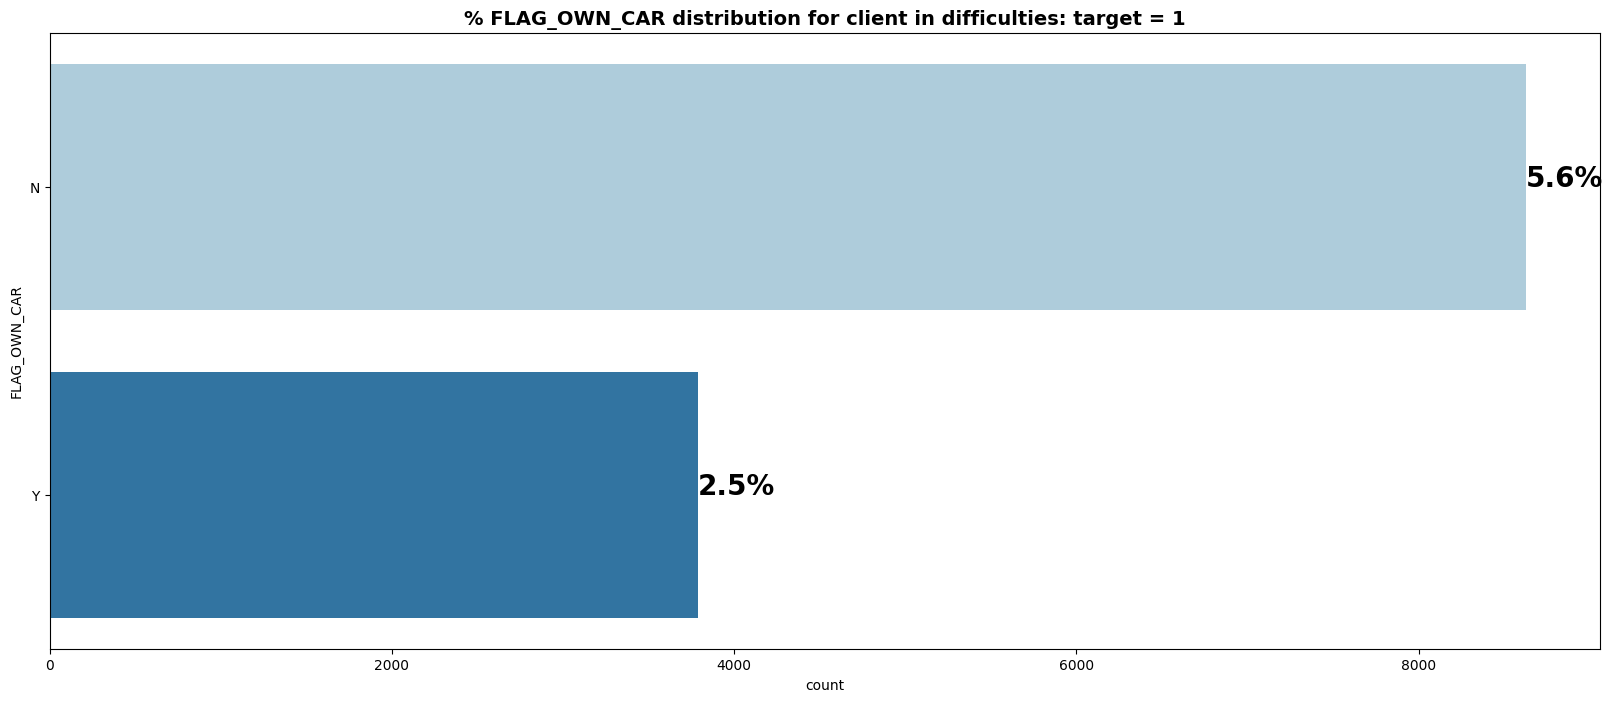

In [190]:
cat_feature='FLAG_OWN_CAR'
display_info(message="Flag own car - Distribution d'un impact possible entre les clients propriétaire d'un véhicule et ceux qui ne le sont pas…")
plot_stat(X_train, cat_feature ,f"{cat_feature} distribution")
display_info(bgd='green', color='white', message="Les non propriétaire ont un taux de non-remboursement 2 fois plus élevé")

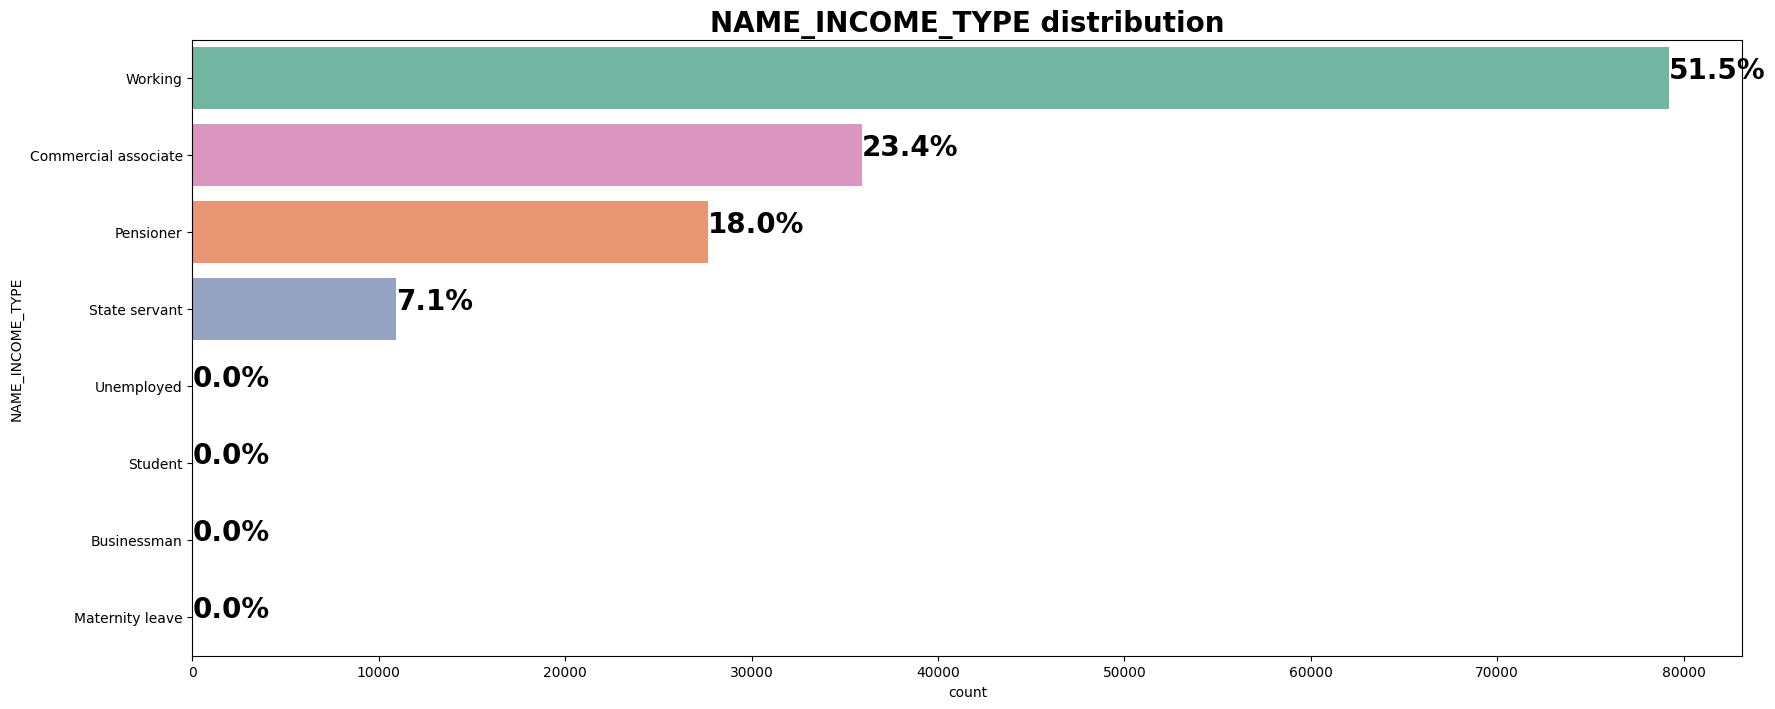

---------------------------------------------------------------------------


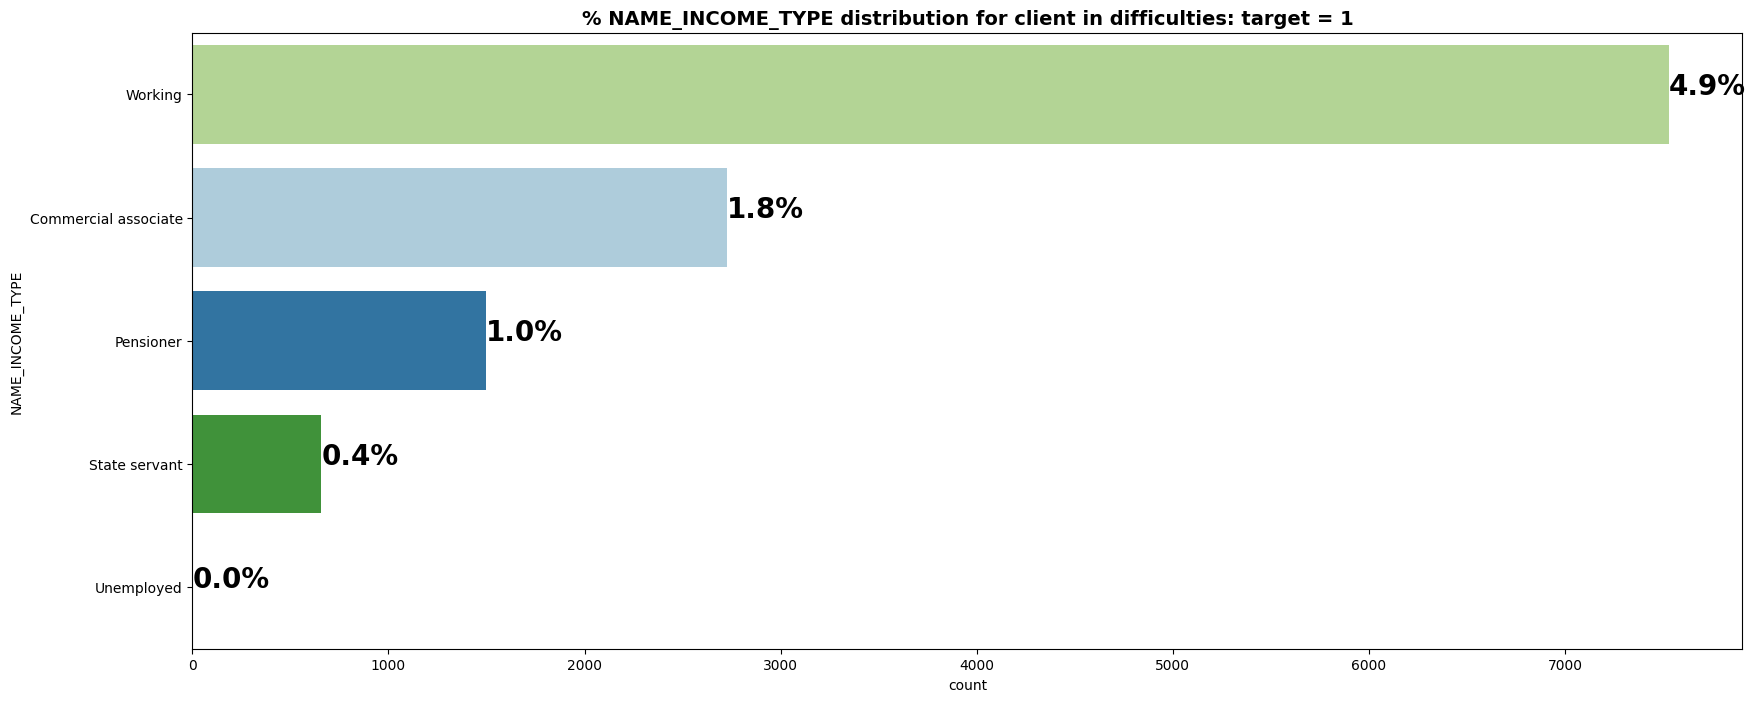

In [191]:
cat_feature='NAME_INCOME_TYPE'
plot_stat(X_train, cat_feature ,f"{cat_feature} distribution")
display_info(bgd='green', color='white', message="La plupart des demandeurs de prêts ont des revenus du travail, suivis par les associées commercial, les retraités et les fonctionnaire. Cette distribution reste identique pour le non-remboursement des prêts")

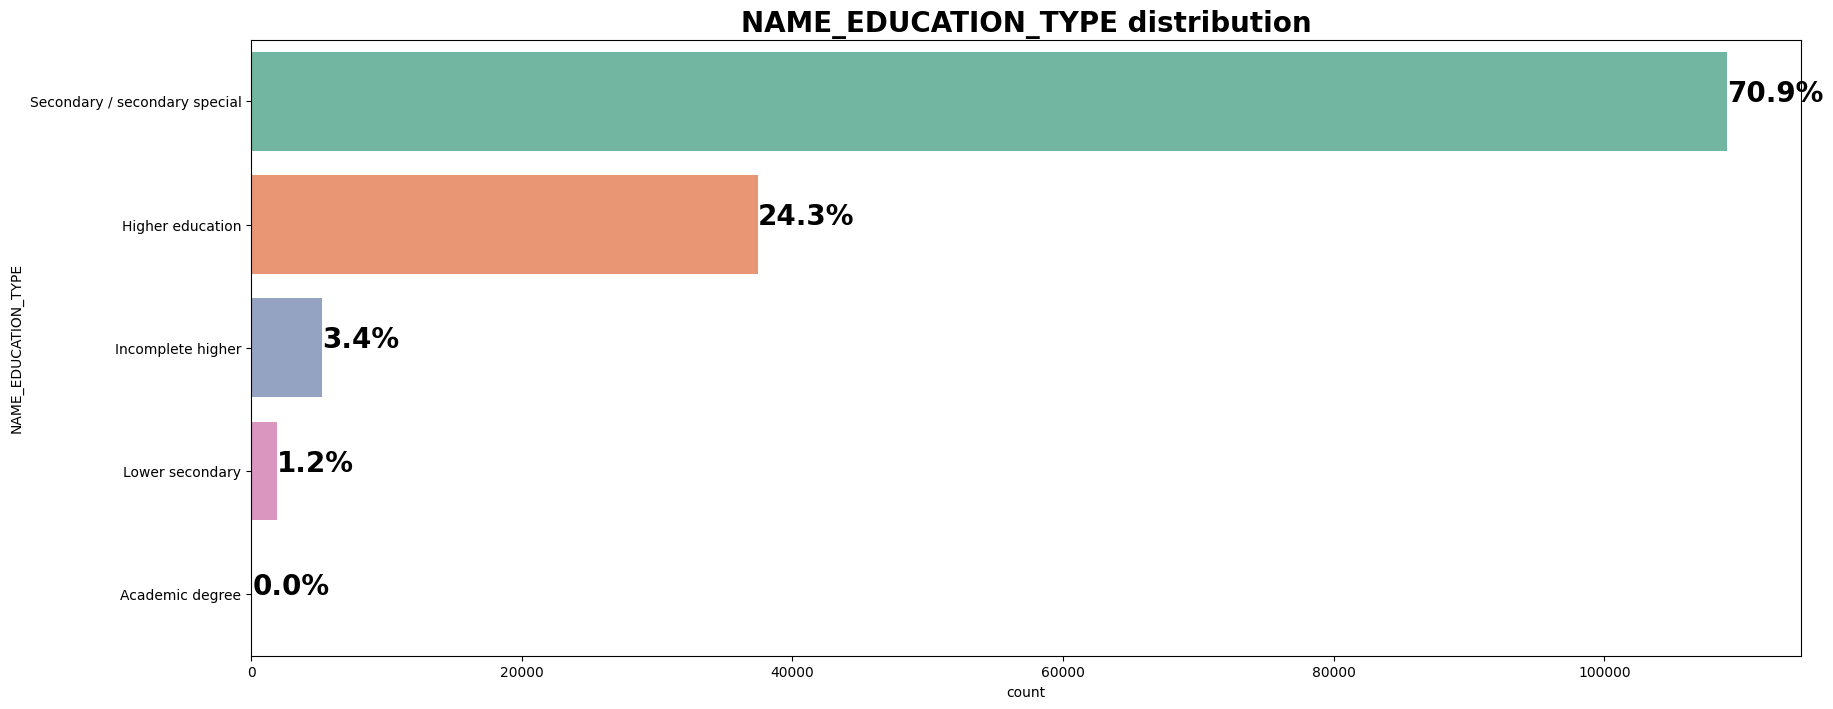

---------------------------------------------------------------------------


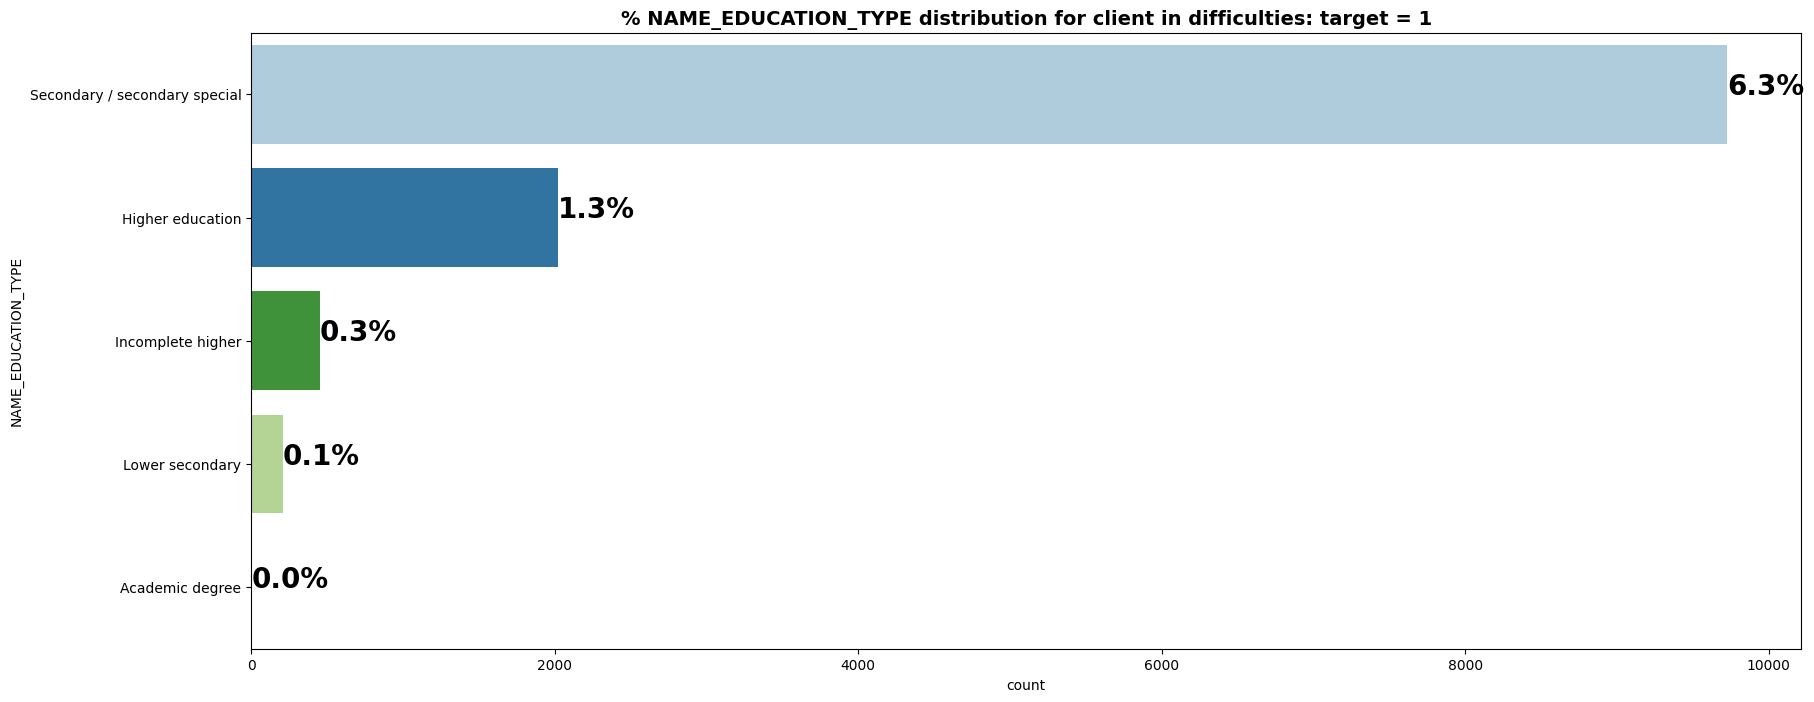

In [192]:
cat_feature='NAME_EDUCATION_TYPE'
plot_stat(X_train, cat_feature ,f"{cat_feature} distribution")

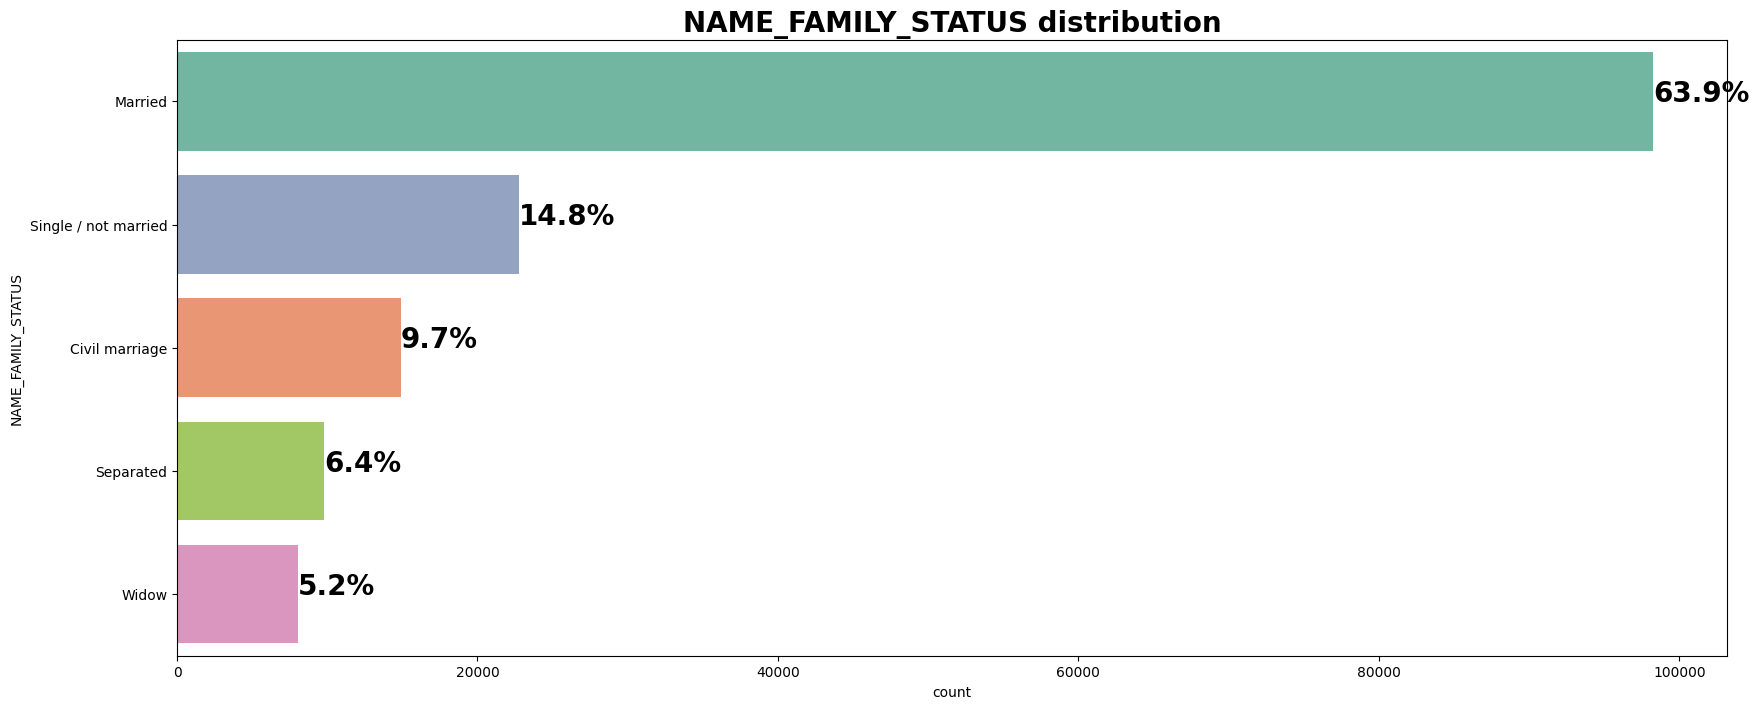

---------------------------------------------------------------------------


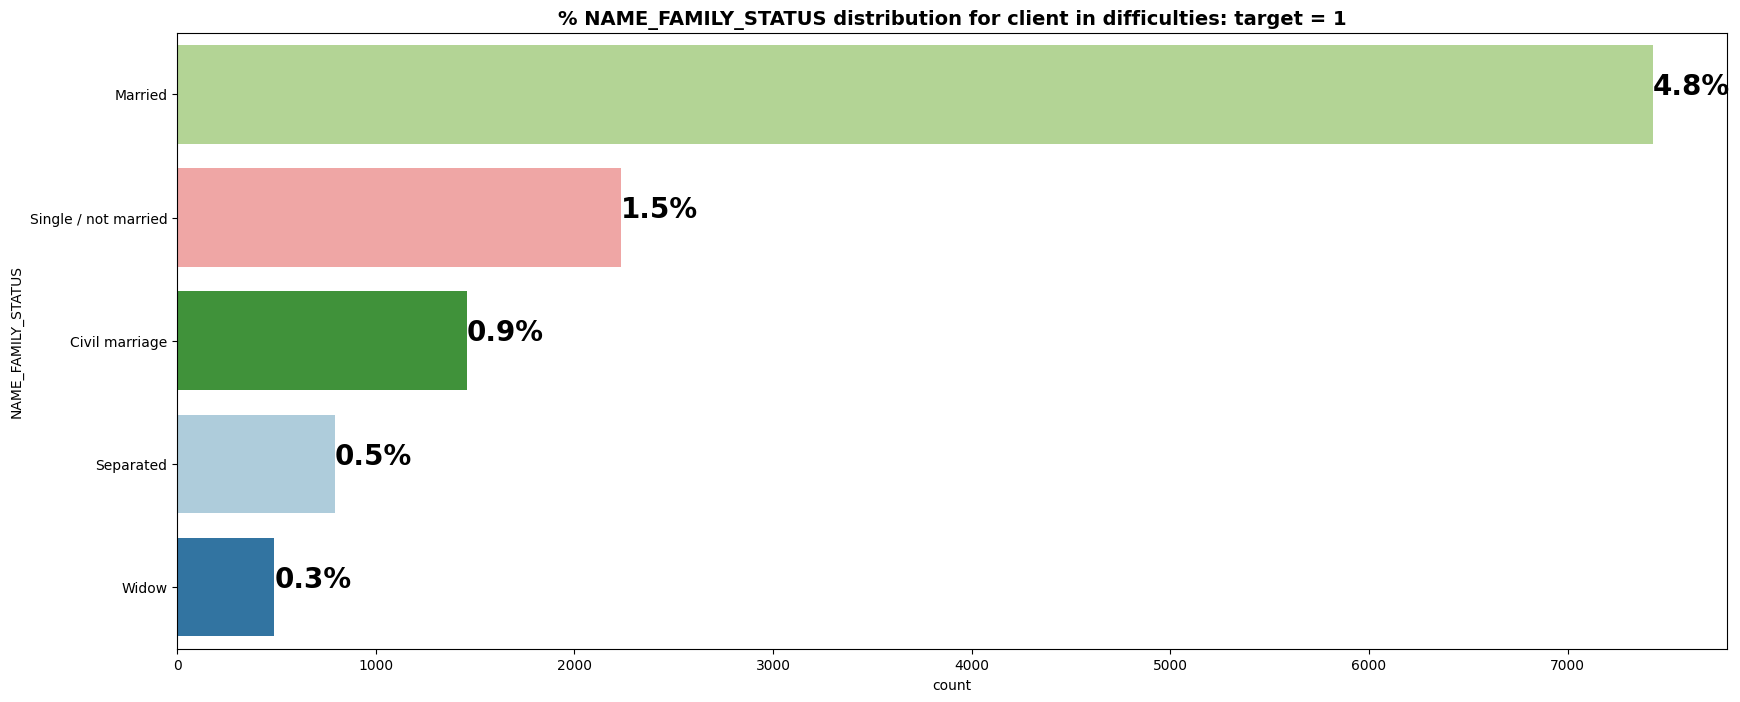

In [193]:
cat_feature='NAME_FAMILY_STATUS'
plot_stat(X_train, cat_feature ,f"{cat_feature} distribution")
display_info(bgd='green', color='white', message='La plupart des clients sont mariés, suivis des célibataires / non mariés et des mariages civils.En termes de pourcentage de non-remboursement du prêt, les couple mariés ont le pourcentage le plus élevé de non-remboursement (~5%), la veuve étant le plus bas (à l\'exception de l\'inconnu).')

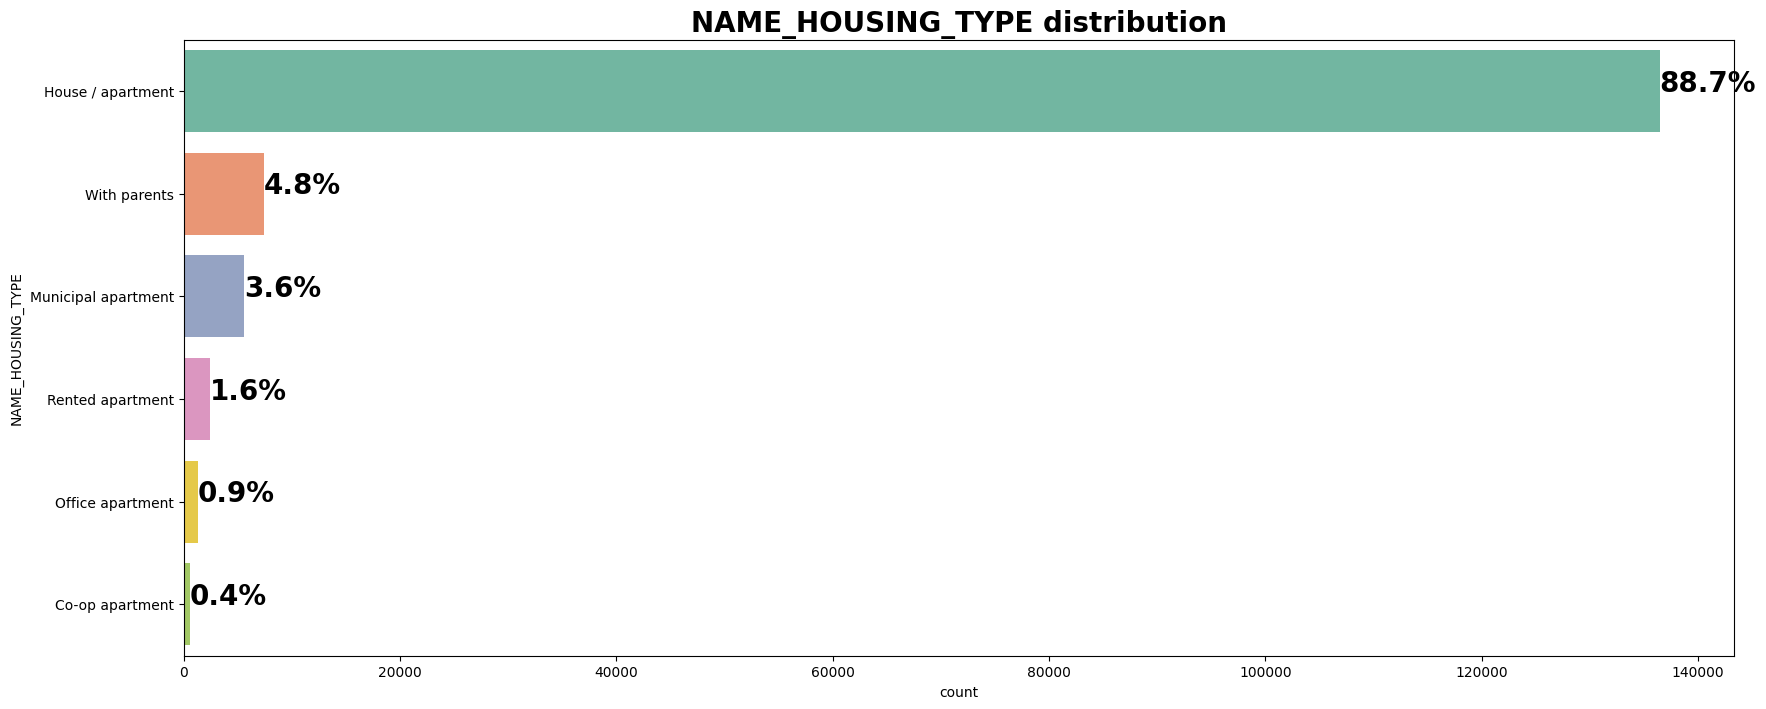

---------------------------------------------------------------------------


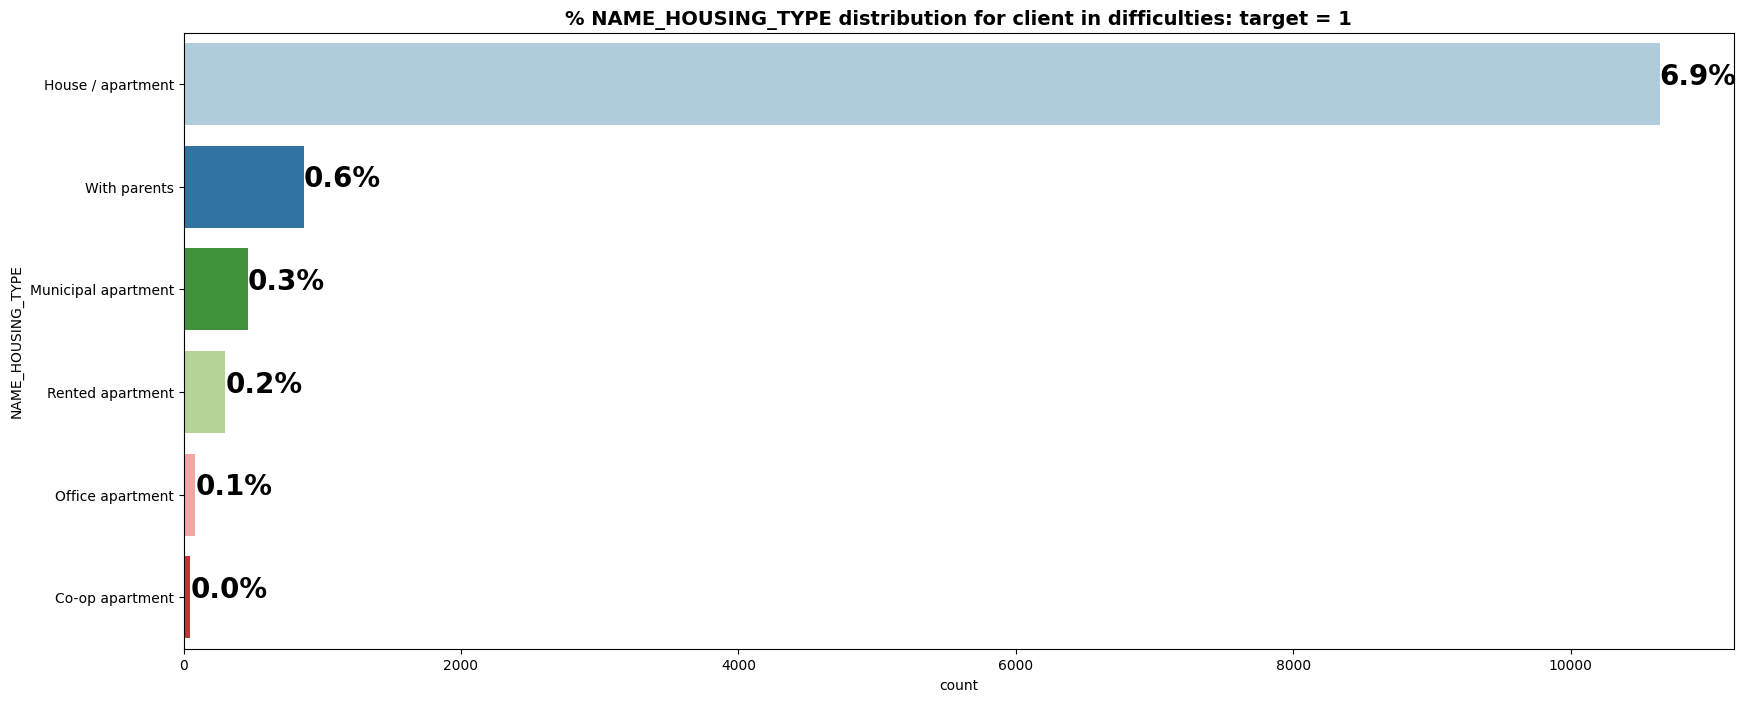

In [194]:
cat_feature='NAME_HOUSING_TYPE'
plot_stat(X_train, cat_feature ,f"{cat_feature} distribution")

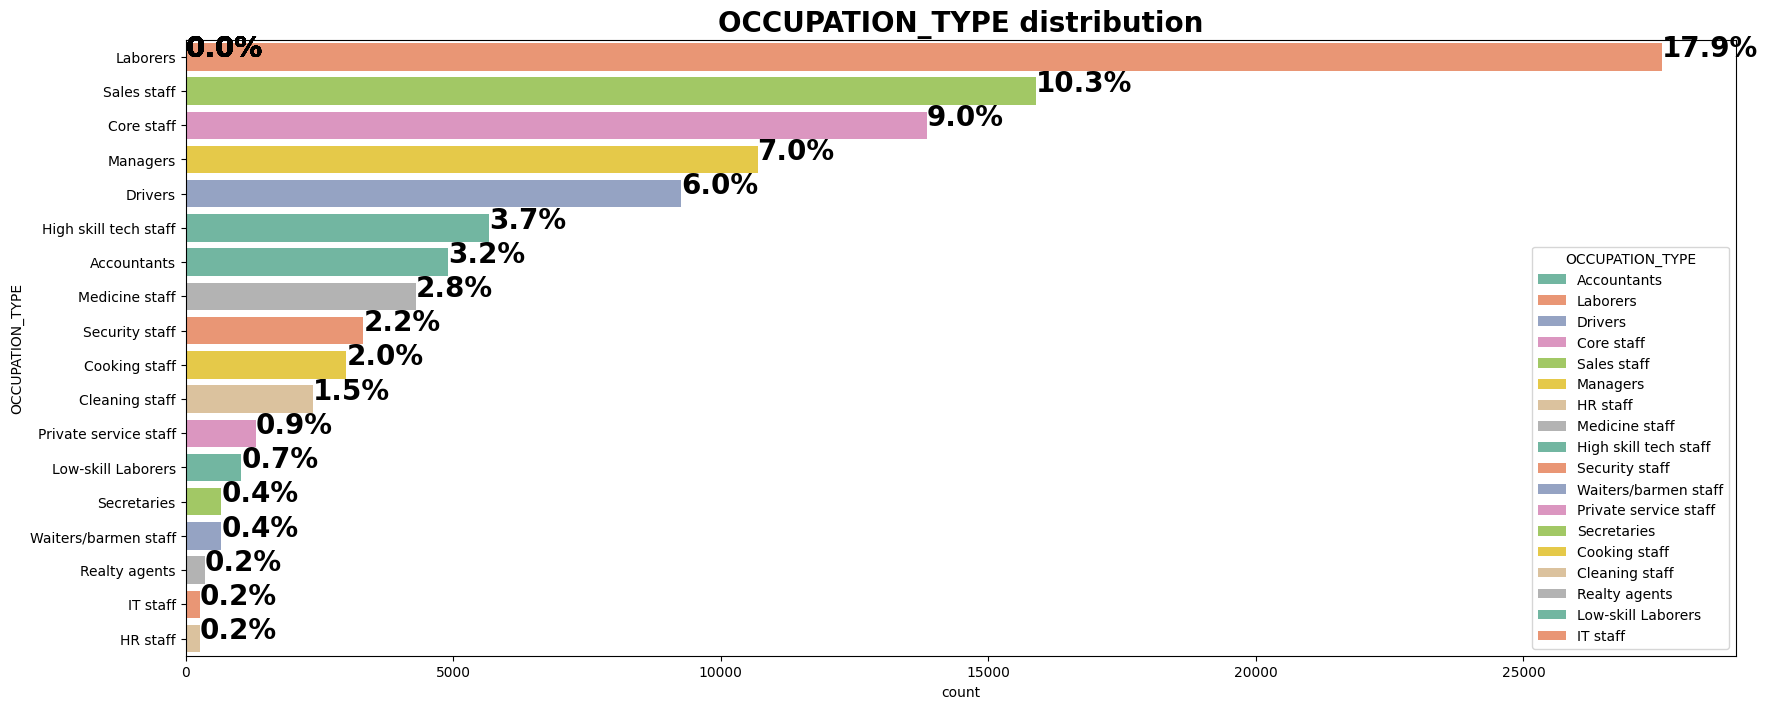

---------------------------------------------------------------------------


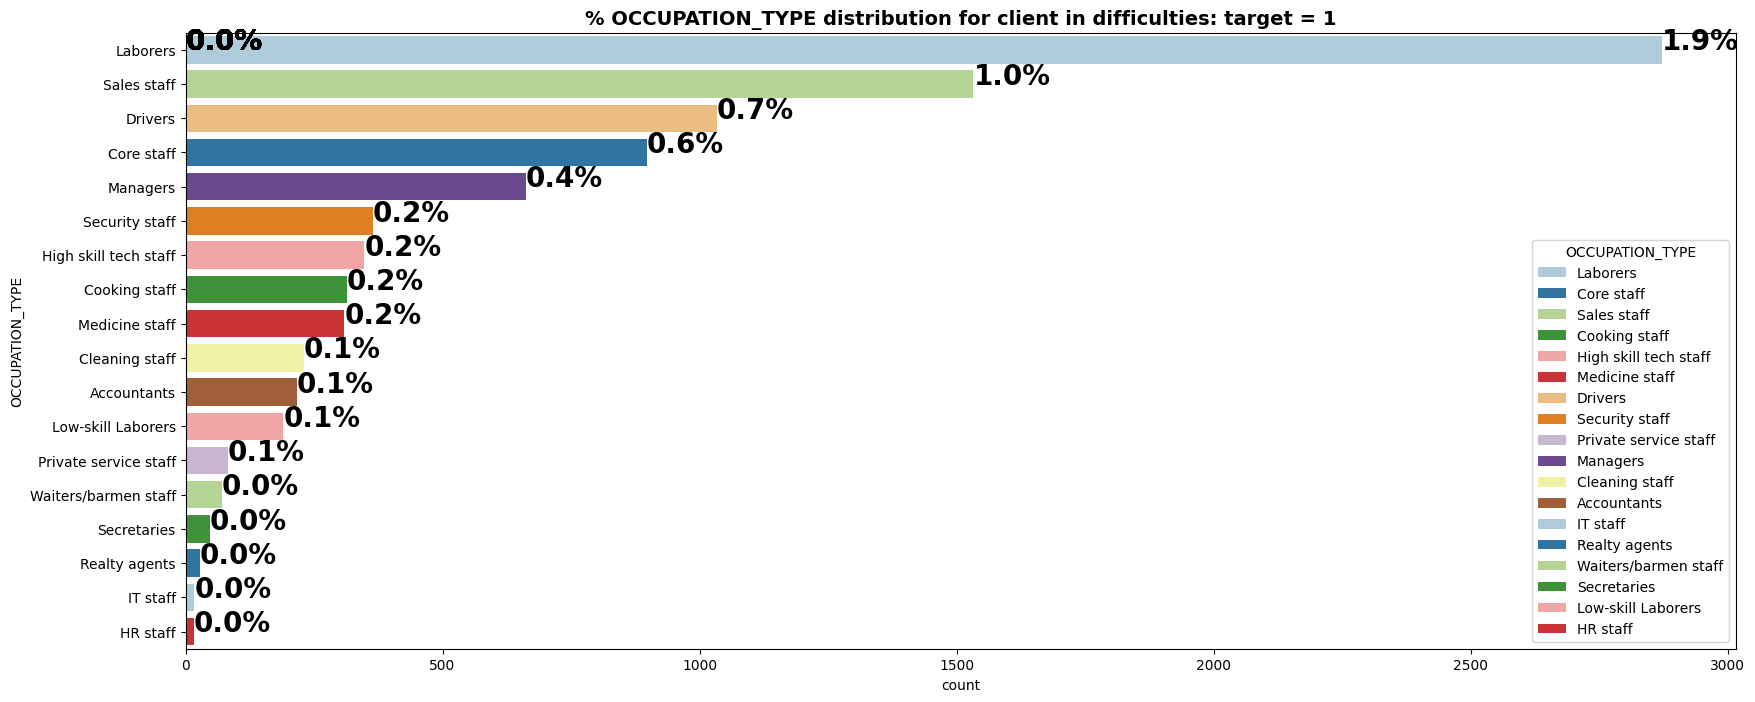

In [195]:
cat_feature='OCCUPATION_TYPE'
plot_stat(X_train, cat_feature ,f"{cat_feature} distribution")

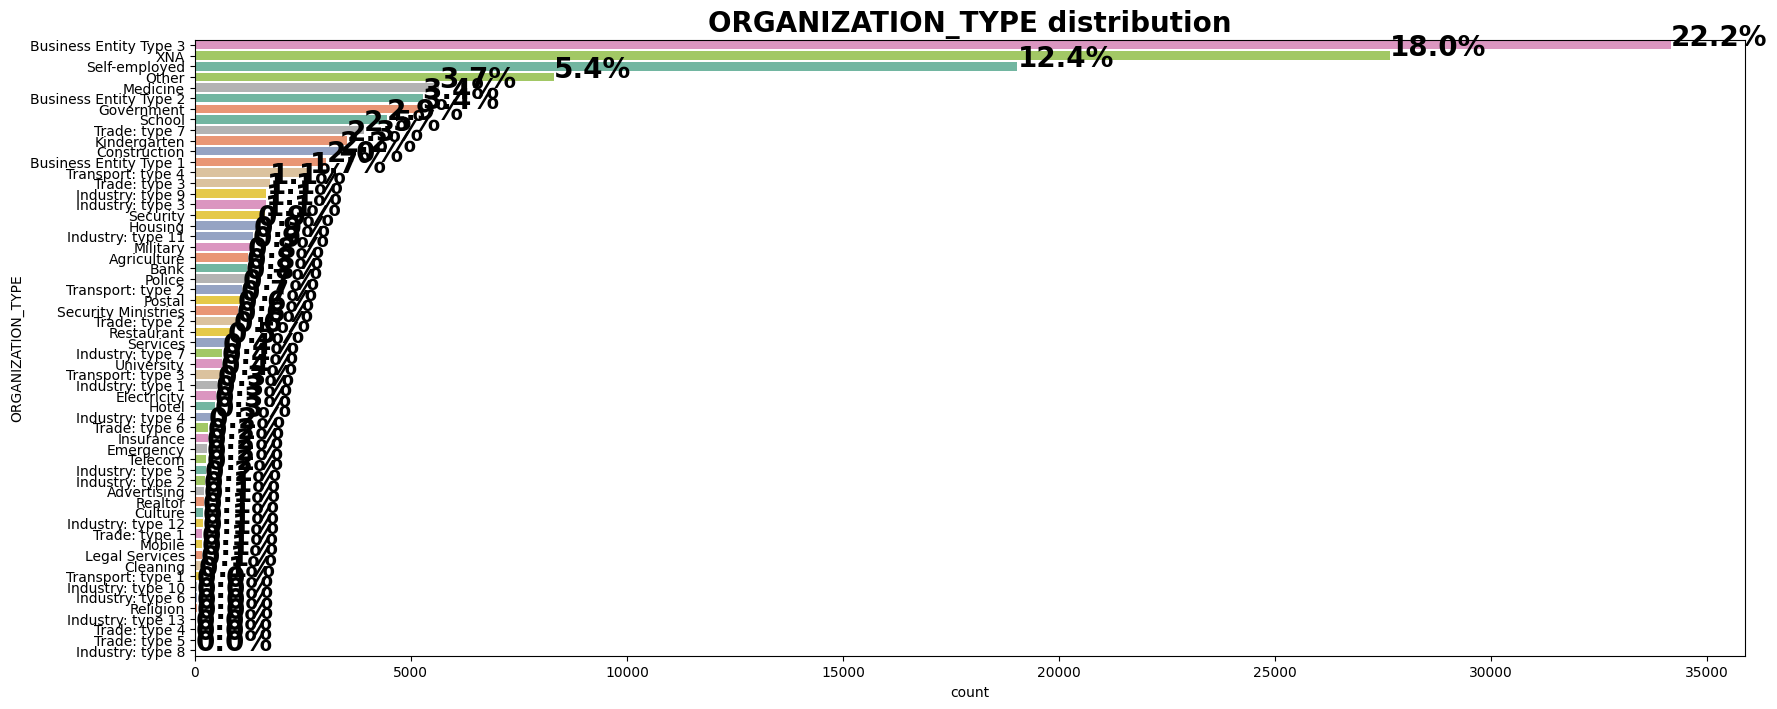

---------------------------------------------------------------------------


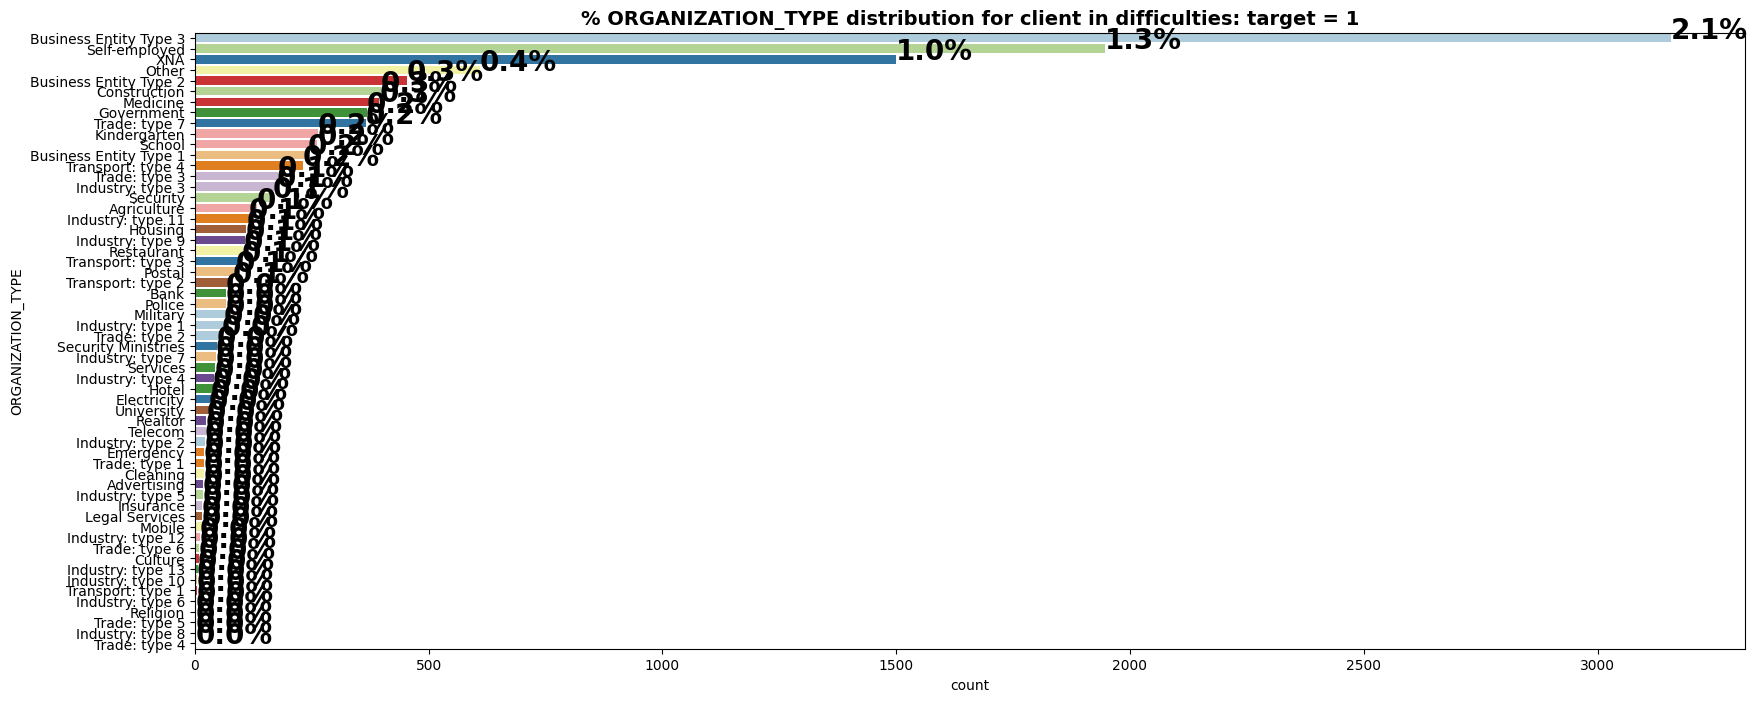

In [196]:
cat_feature='ORGANIZATION_TYPE'
plot_stat(X_train, cat_feature ,f"{cat_feature} distribution")

In [197]:
display_info(title="Analyse Bi-variées",color="red", fontsize="28px")
display_info(title="visualisation de la relation entre Target et nos autres variables",color="green")
display_info(title="Création d'un sous-ensembles positifs et négatifs",color="green",tag="h3")

In [198]:
display_info(message="On va créer les sous ensemble positif et negatif avec la fonction splitClientByTarget")
def splitClientByTarget(data):
    clientInPain_df=data[data['TARGET']==1]
    clientInGood_df=data[data['TARGET']==0]
    return clientInGood_df, clientInPain_df

clientInPain_df,clientInGood_df = splitClientByTarget(X_train)
print(f'Composition du dataframe clientInPain_df {clientInPain_df.shape}')
print(f'Composition du dataframe clientInGood_df {clientInGood_df.shape}')


Composition du dataframe clientInPain_df (141343, 66)
Composition du dataframe clientInGood_df (12412, 66)


In [199]:
display_info(title="Création d'un sous-ensembles des colonnes AMT",color="green",tag="h3")
amt_df = X_train.filter(like='AMT')# Selections de toutes les colonness contenant le mots AMT

In [200]:
display_info(title="Création d'un sous-ensembles des colonnes DAYS",color="green",tag="h3")
day_df = X_train.filter(like='DAYS') # Selections de toutes les colonness contenant le mots DAYS

In [201]:
display_info(title="Visualisation Target / AMT",color="green",tag="h3")
display_info(message="On visualise Variable après variables si il y a un différence entre les clients en difficulté et le client ok")
def displayHisplot(inGood, inPain, columns_name):
    plt.figure(figsize=(15,8))
    sns.histplot(inGood,kde=True, label='Client ok: Target 0',color='blue')
    sns.histplot(inPain,kde=True, label='Client in pain: Target 1', color='red')
    plt.title(f'Distribution de {columns_name} by TARGET')
    plt.ylabel('Density')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()


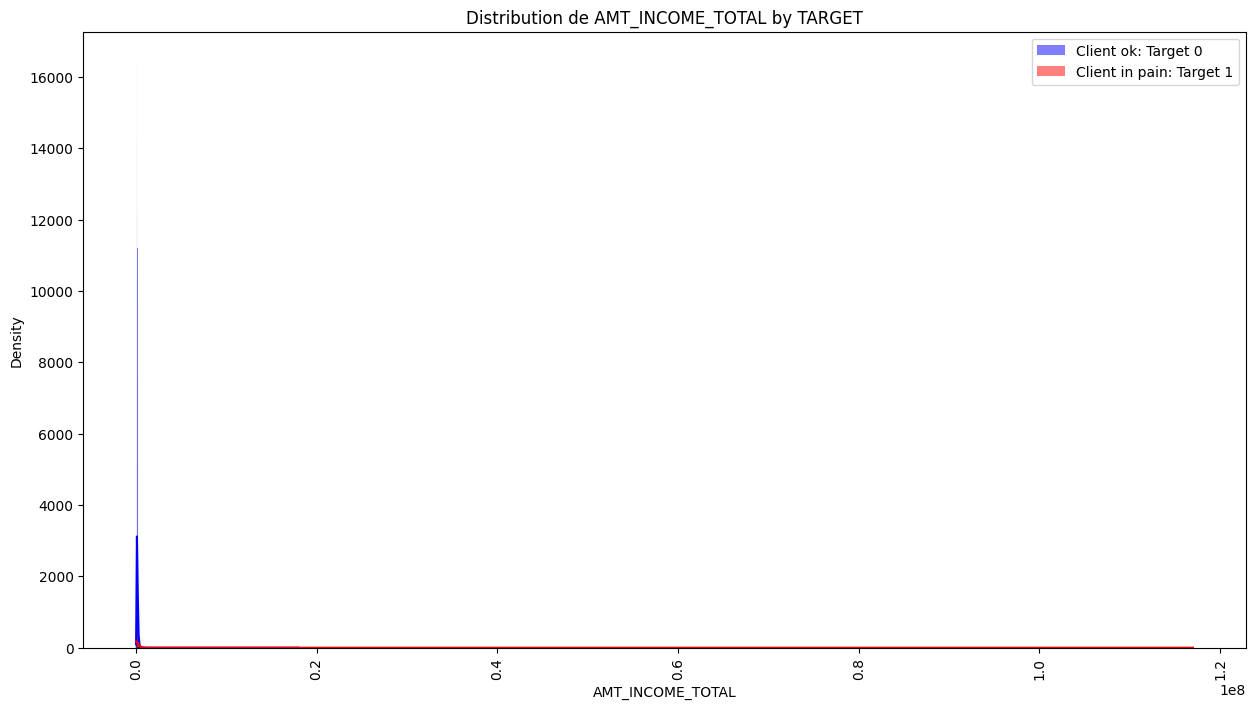

Distributions de AMT_INCOME_TOTAL - terminé en 10s


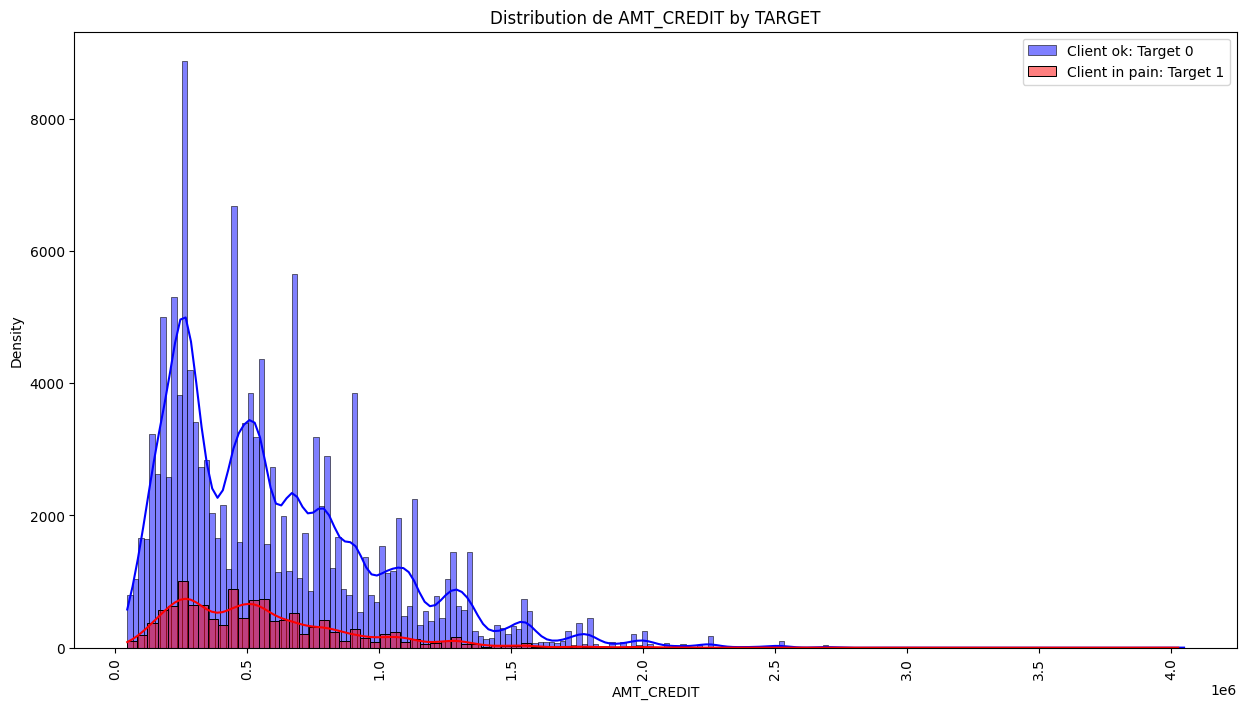

Distributions de AMT_CREDIT - terminé en 0s


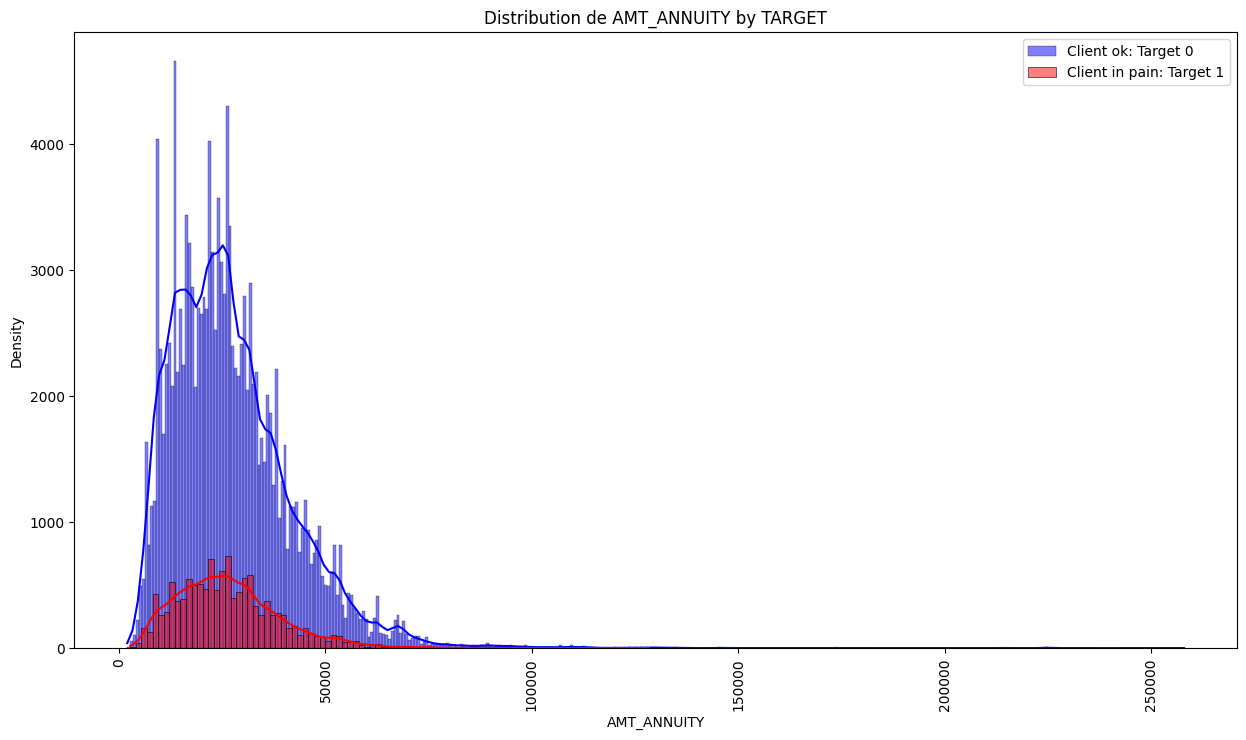

Distributions de AMT_ANNUITY - terminé en 0s


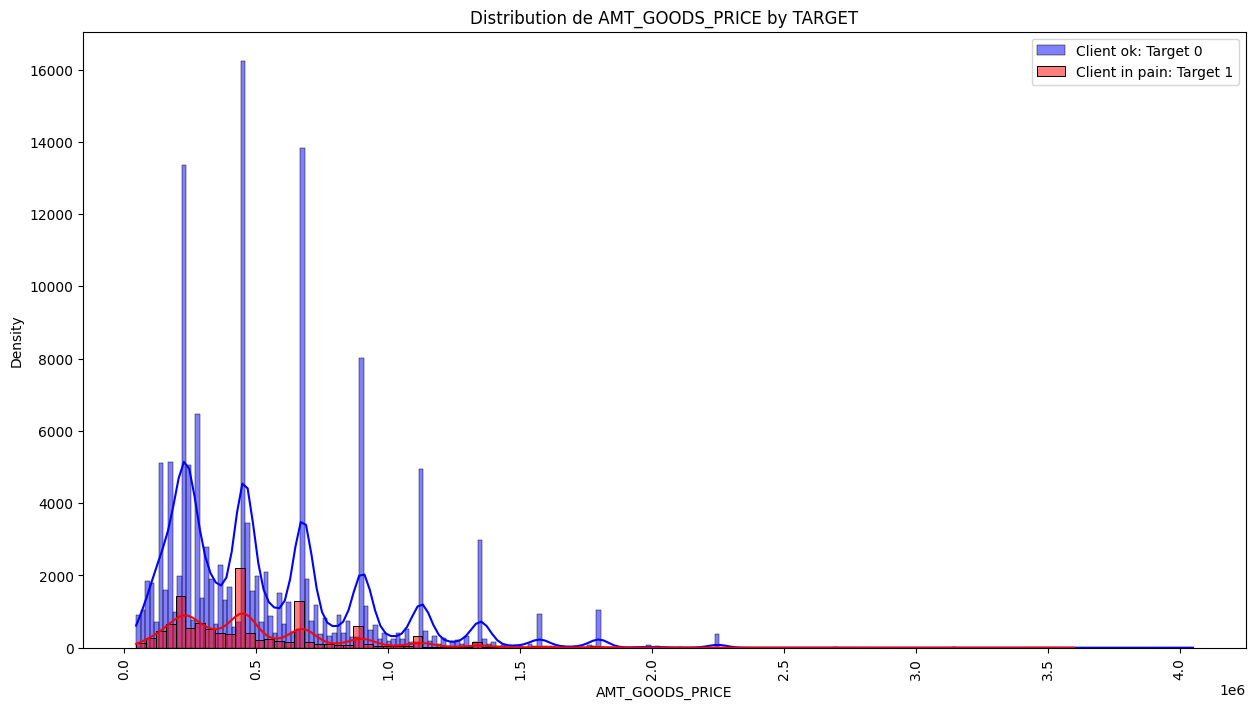

Distributions de AMT_GOODS_PRICE - terminé en 0s


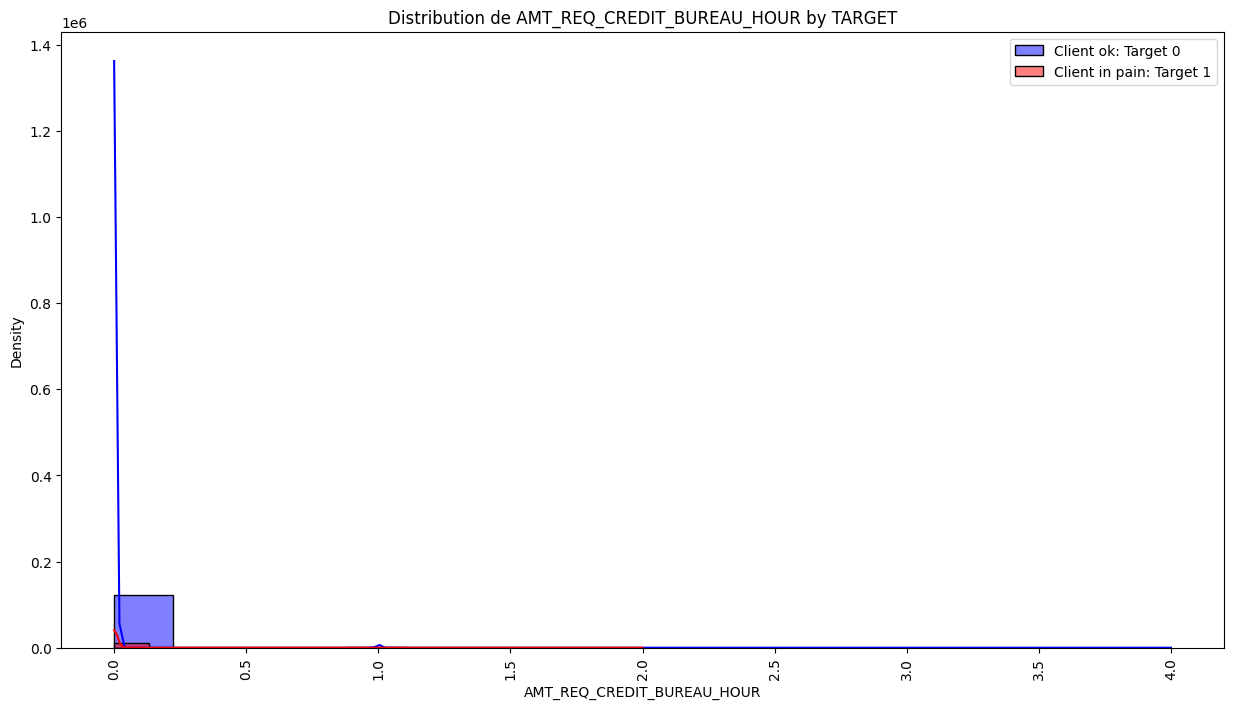

Distributions de AMT_REQ_CREDIT_BUREAU_HOUR - terminé en 0s


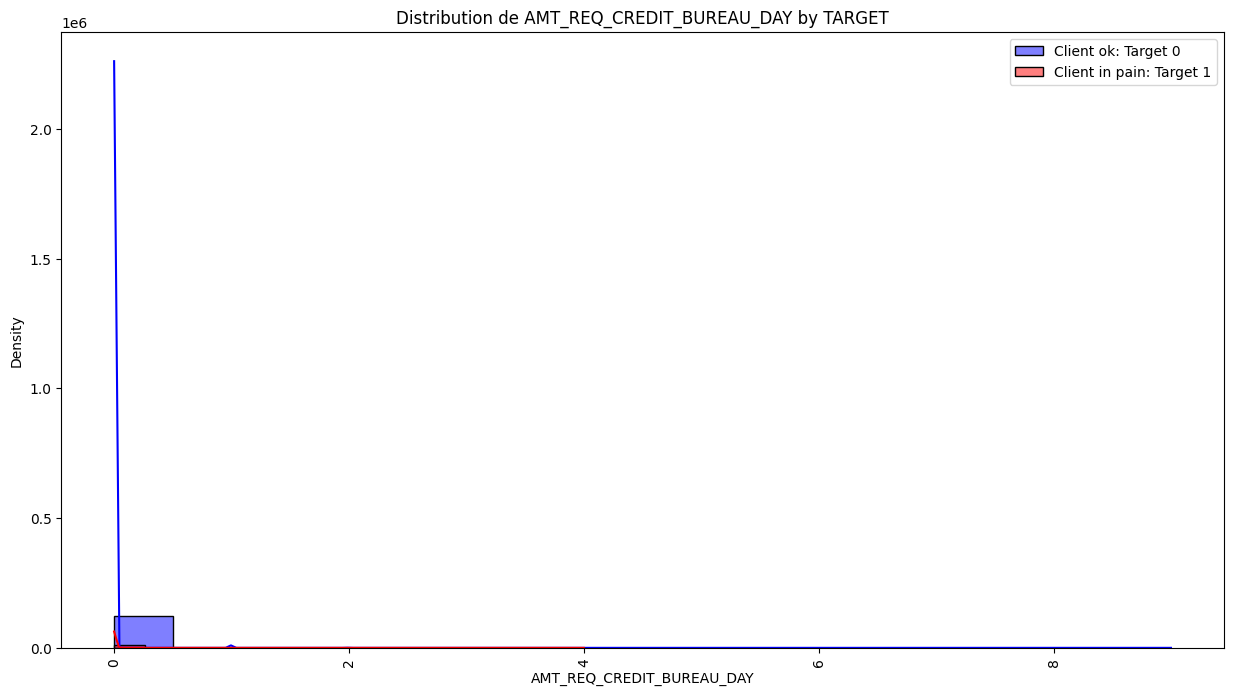

Distributions de AMT_REQ_CREDIT_BUREAU_DAY - terminé en 0s


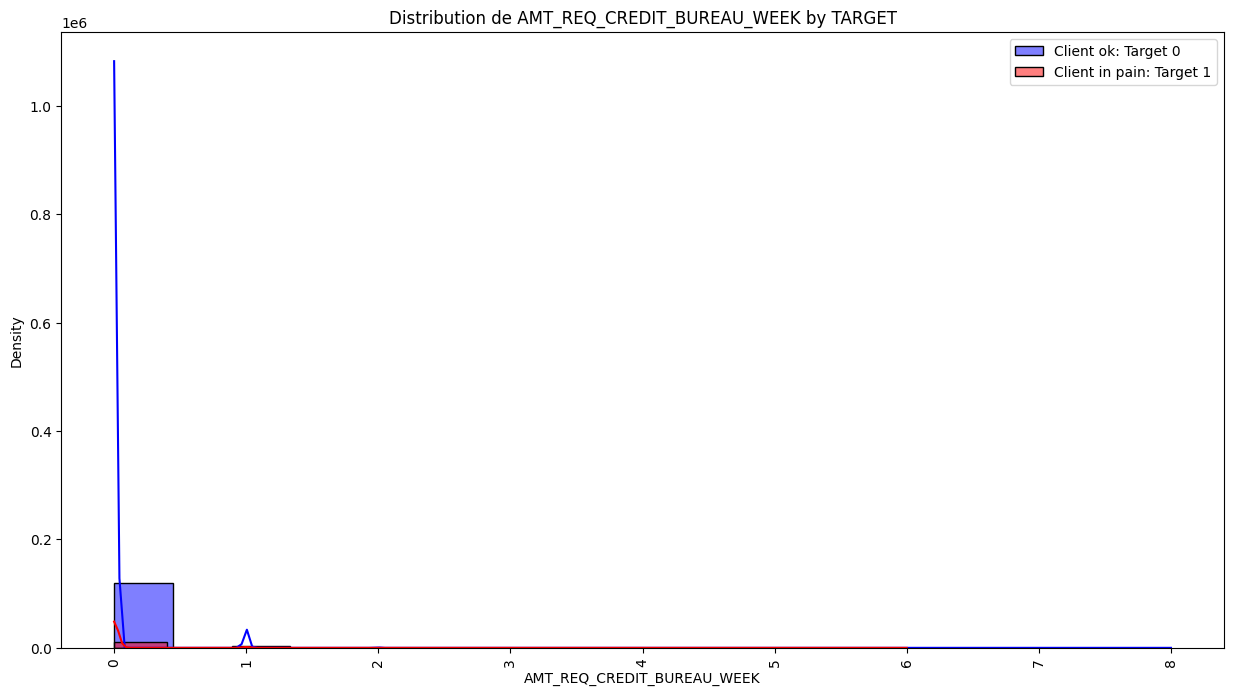

Distributions de AMT_REQ_CREDIT_BUREAU_WEEK - terminé en 0s


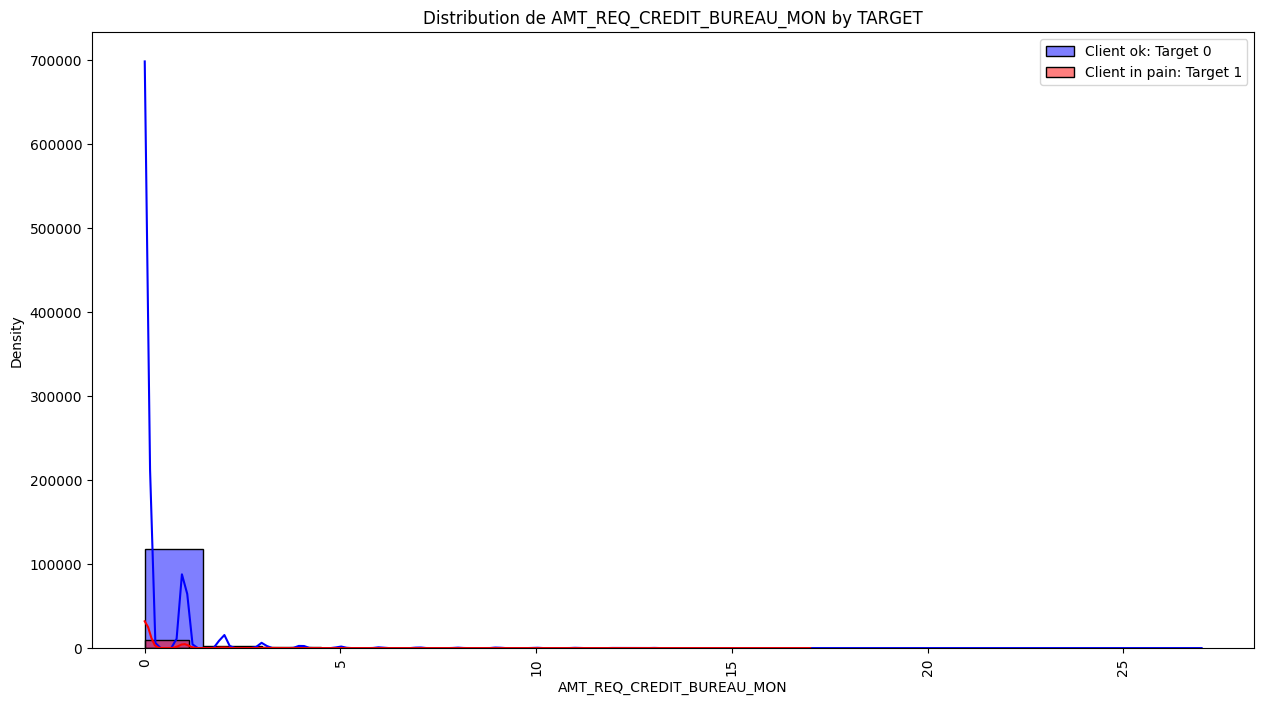

Distributions de AMT_REQ_CREDIT_BUREAU_MON - terminé en 0s


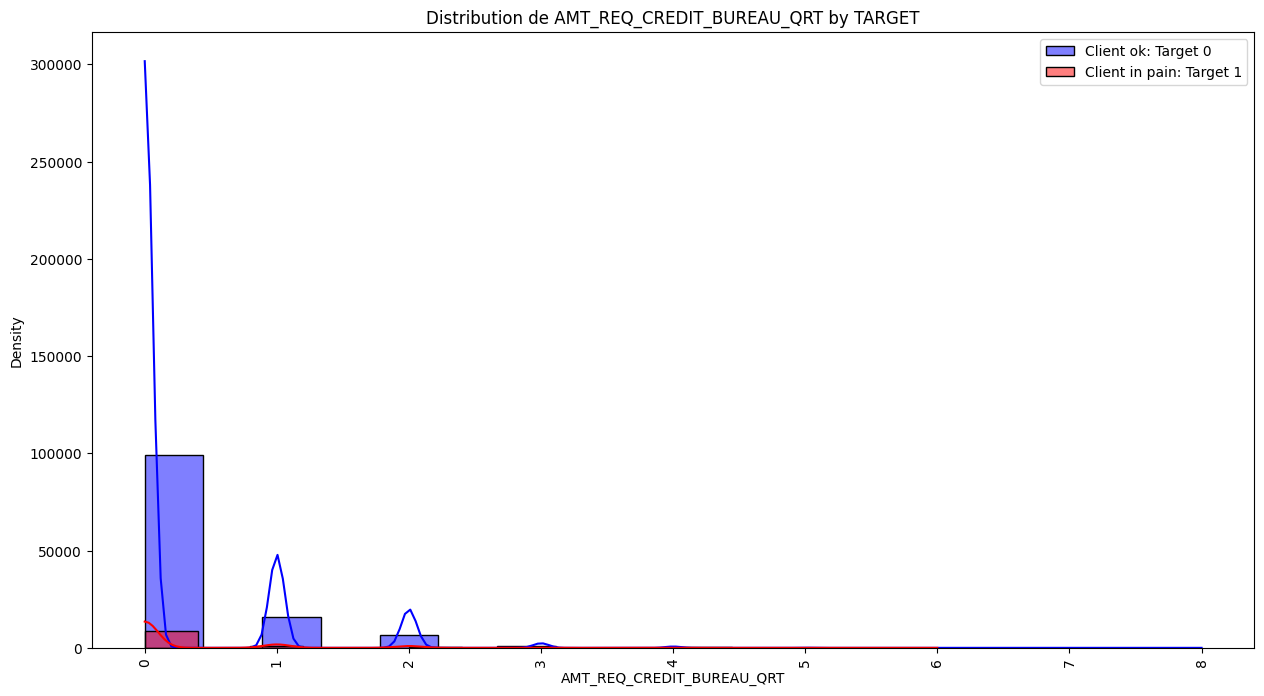

Distributions de AMT_REQ_CREDIT_BUREAU_QRT - terminé en 0s


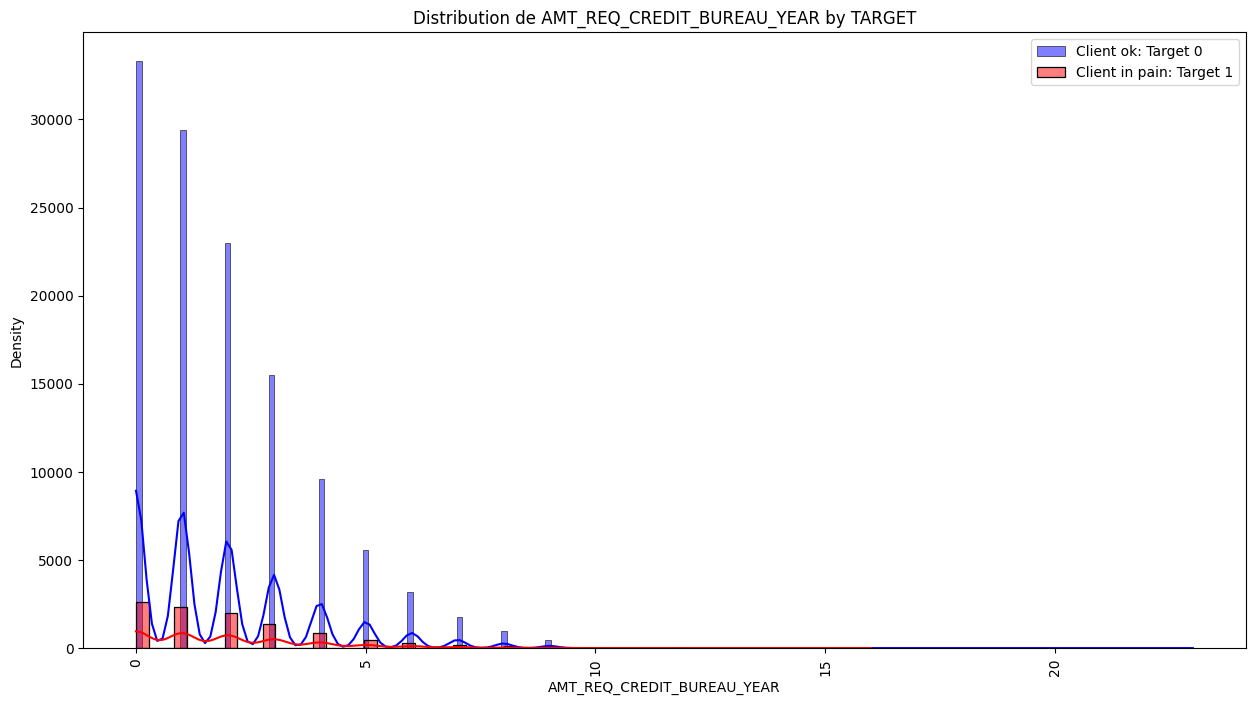

Distributions de AMT_REQ_CREDIT_BUREAU_YEAR - terminé en 0s


In [202]:
# amt_cols = amt_df.columns

for col in amt_df.columns:
    with timer(title=(f"Distributions de {col}")):
        clientInGood_df,clientInPain_df=splitClientByTarget(X_train)
        clientInGood_df_AMT = clientInGood_df[col]
        clientInPain_df_AMT = clientInPain_df[col]
        displayHisplot(clientInGood_df_AMT,clientInPain_df_AMT, col)
    


In [203]:
display_info(message="Il n'y a pas de différence de distribution notable sur nos variables")

In [204]:
display_info(title="Visualisation Target / DAYS",color="green",tag="h3")

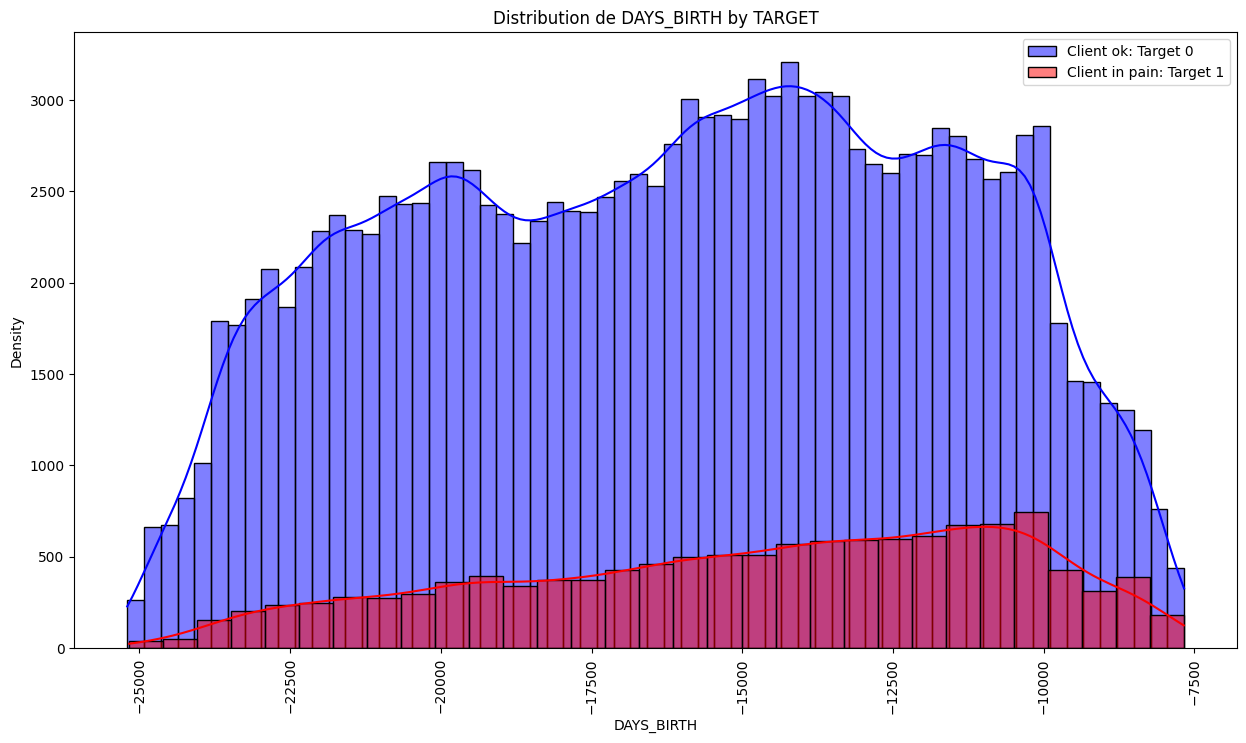

visualisation de la distribution de DAYS_BIRTH - terminé en 0s


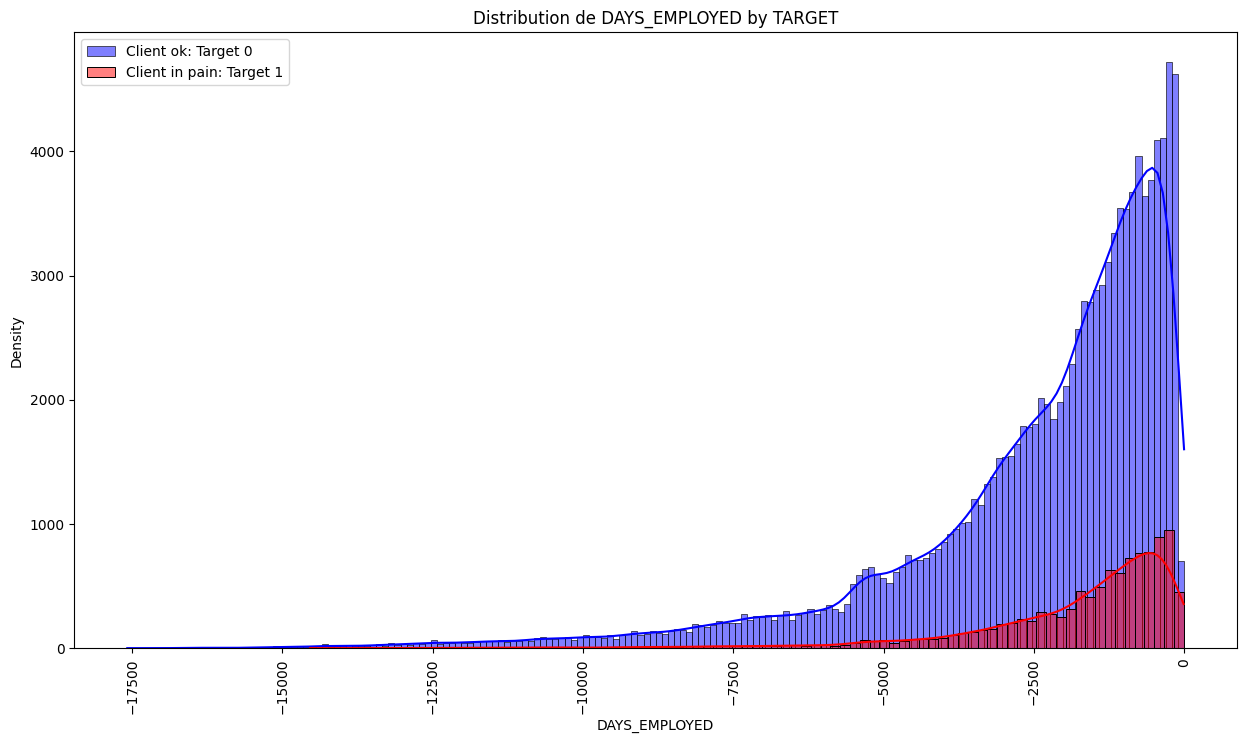

visualisation de la distribution de DAYS_EMPLOYED - terminé en 0s


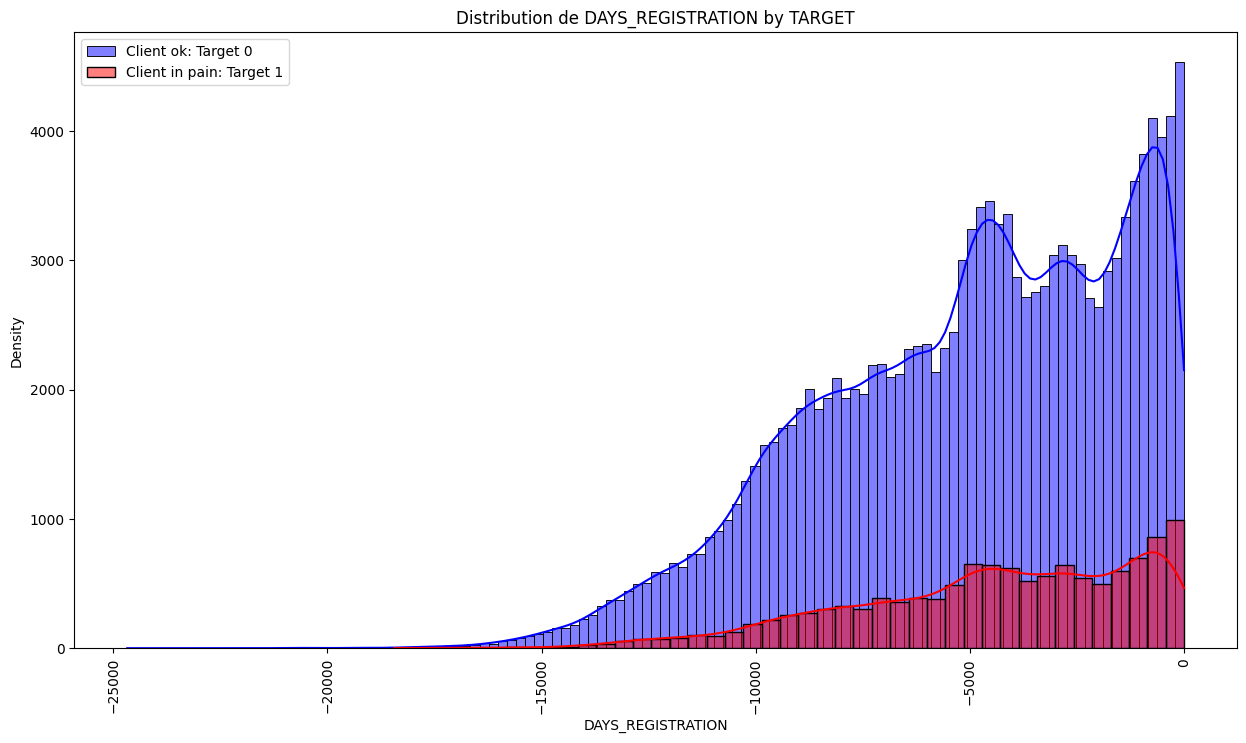

visualisation de la distribution de DAYS_REGISTRATION - terminé en 0s


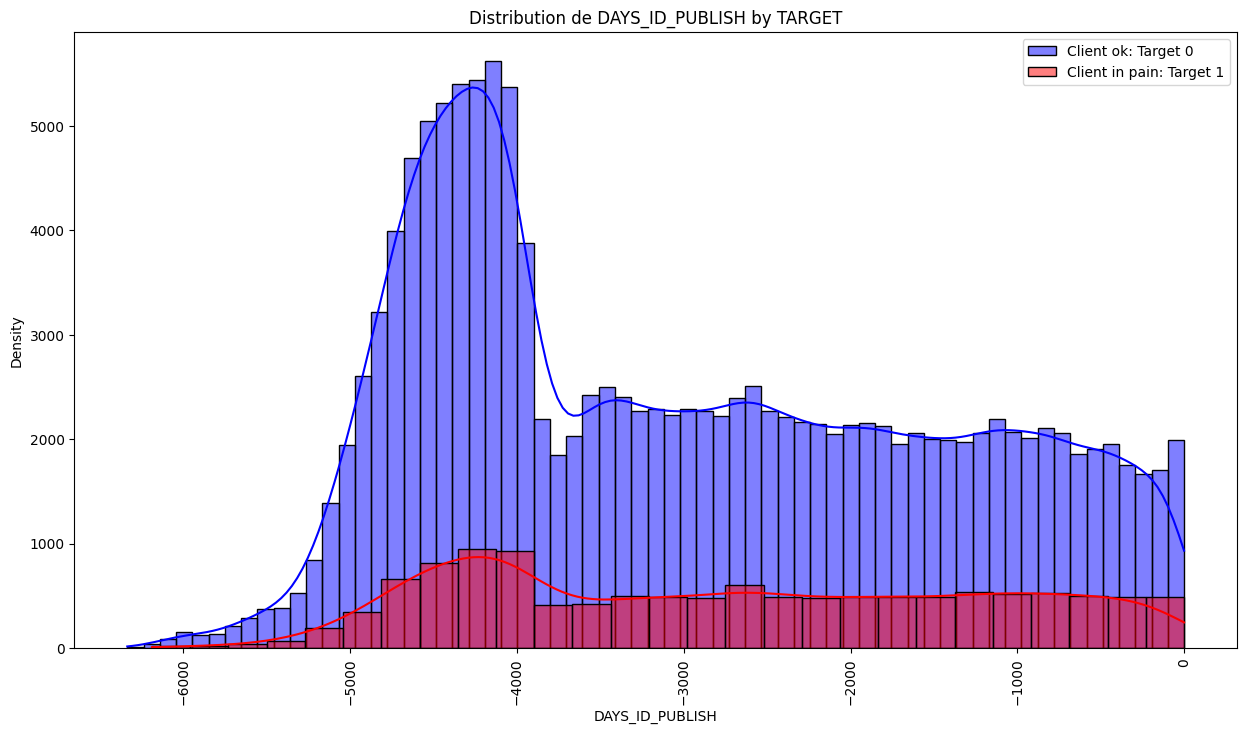

visualisation de la distribution de DAYS_ID_PUBLISH - terminé en 0s


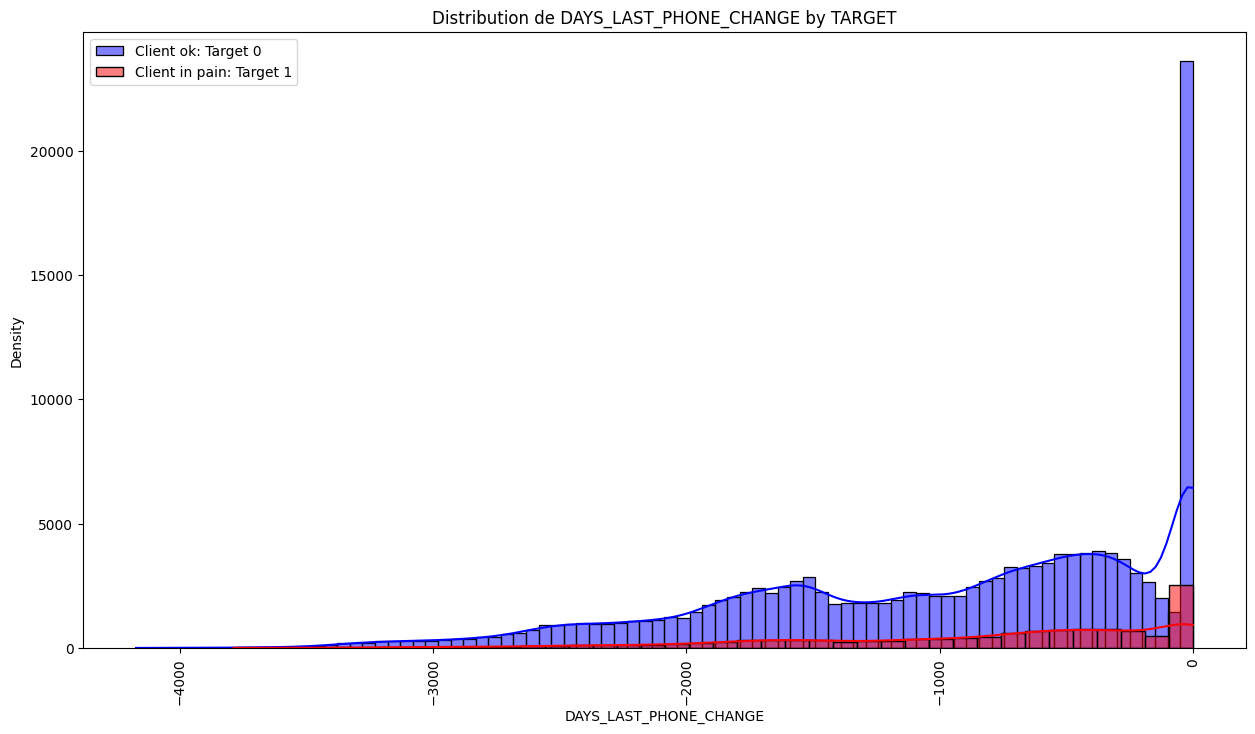

visualisation de la distribution de DAYS_LAST_PHONE_CHANGE - terminé en 0s


In [205]:
display_info(message="On visualise Variable après variables si il y a un différence entre les clients en difficulté et le client ok")
X_train_days = X_train[day_df.columns.tolist() + ['TARGET']]
clientInGood_df,clientInPain_df=splitClientByTarget(X_train_days)

for col in day_df.columns:
    with timer(title=(f"visualisation de la distribution de {col}")):
        df= displayHisplot(clientInGood_df[col],clientInPain_df[col], col)

In [206]:
display_info(message="Les distribution semble etre identique et proportionnel au statut du client")

In [207]:
display_info(title="Target / DAYS_BIRTH", color="green",tag="h3")

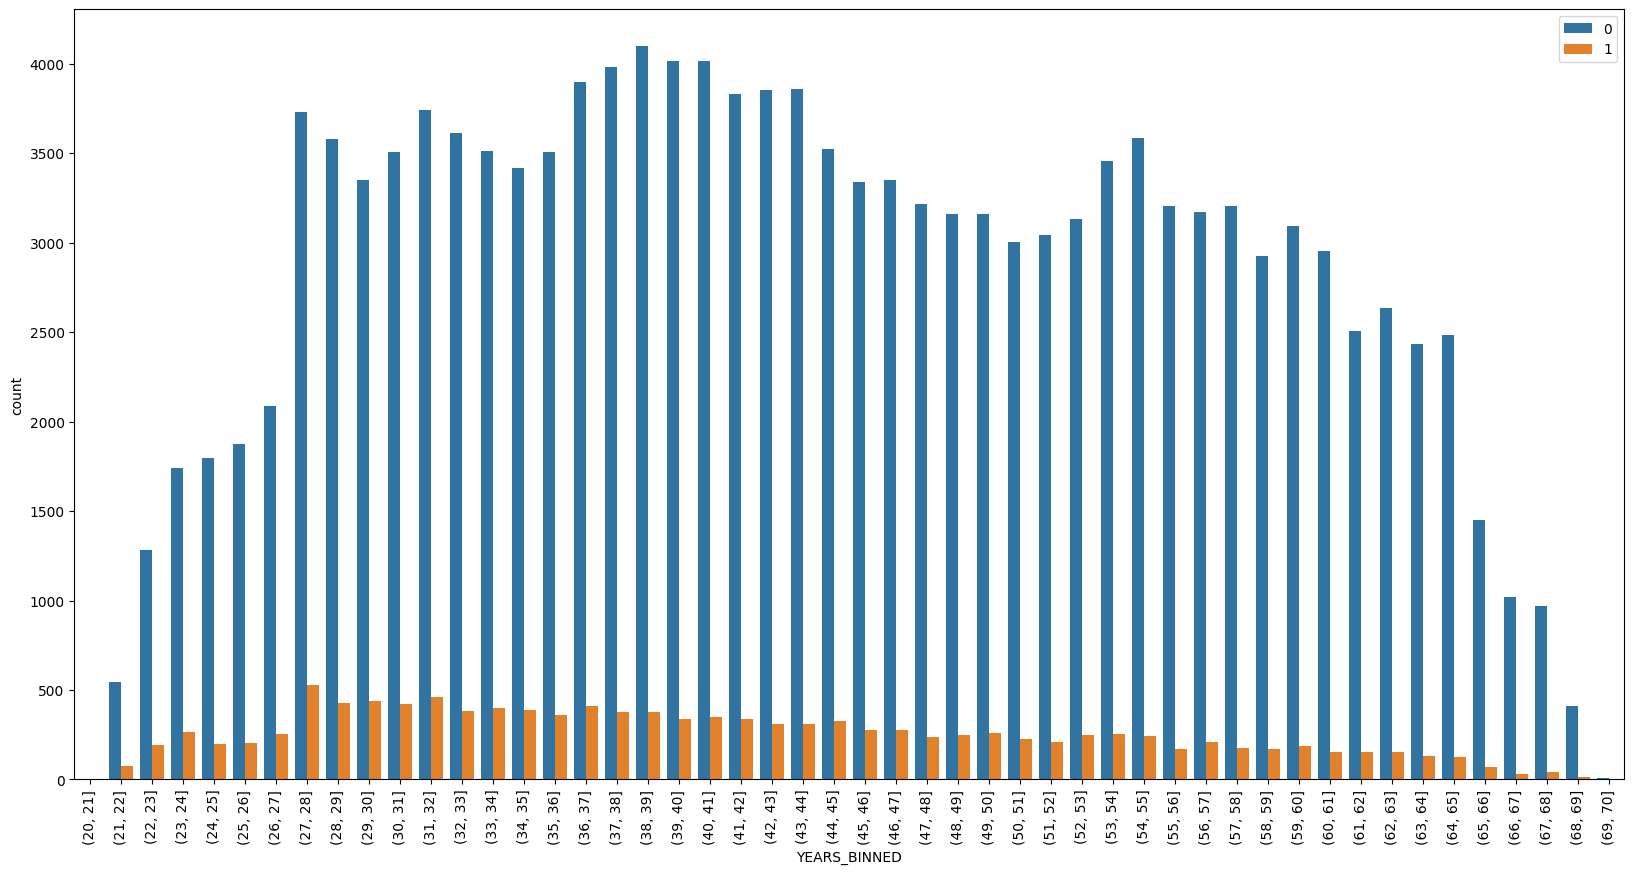

In [208]:
X_train['YEARS_BIRTH'] = X_train['DAYS_BIRTH'] / -365
X_train['YEARS_BINNED'] = pd.cut(X_train['YEARS_BIRTH'], bins=range(20, 71, 1))

plt.figure(figsize=(20,10))
sns.countplot(x='YEARS_BINNED', hue='TARGET', data= X_train)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [209]:
display_info(message="Il n'y a pas de différence de distribution notable de notre target en fonction de l'age des clients")

In [210]:
display_info(title="Conclusions initiales",color="blue")
display_info(pTag="ul",message="""
             <li>Beaucoup de données manquantes</li>
             <li>La TARGET est desiquilibré  10% de client en difficulté pour 90% de client SANS difficulté </li>
             <li>Pas de différence notable de distribution entre les valeurs de la TARGET</li>
             """)

In [211]:
display_info(title="Analyse multivariées", color="red", fontsize="28px")
display_info(title="Relation AMT/AMT", color='white')
display_info(title="PairPlot", color='green')


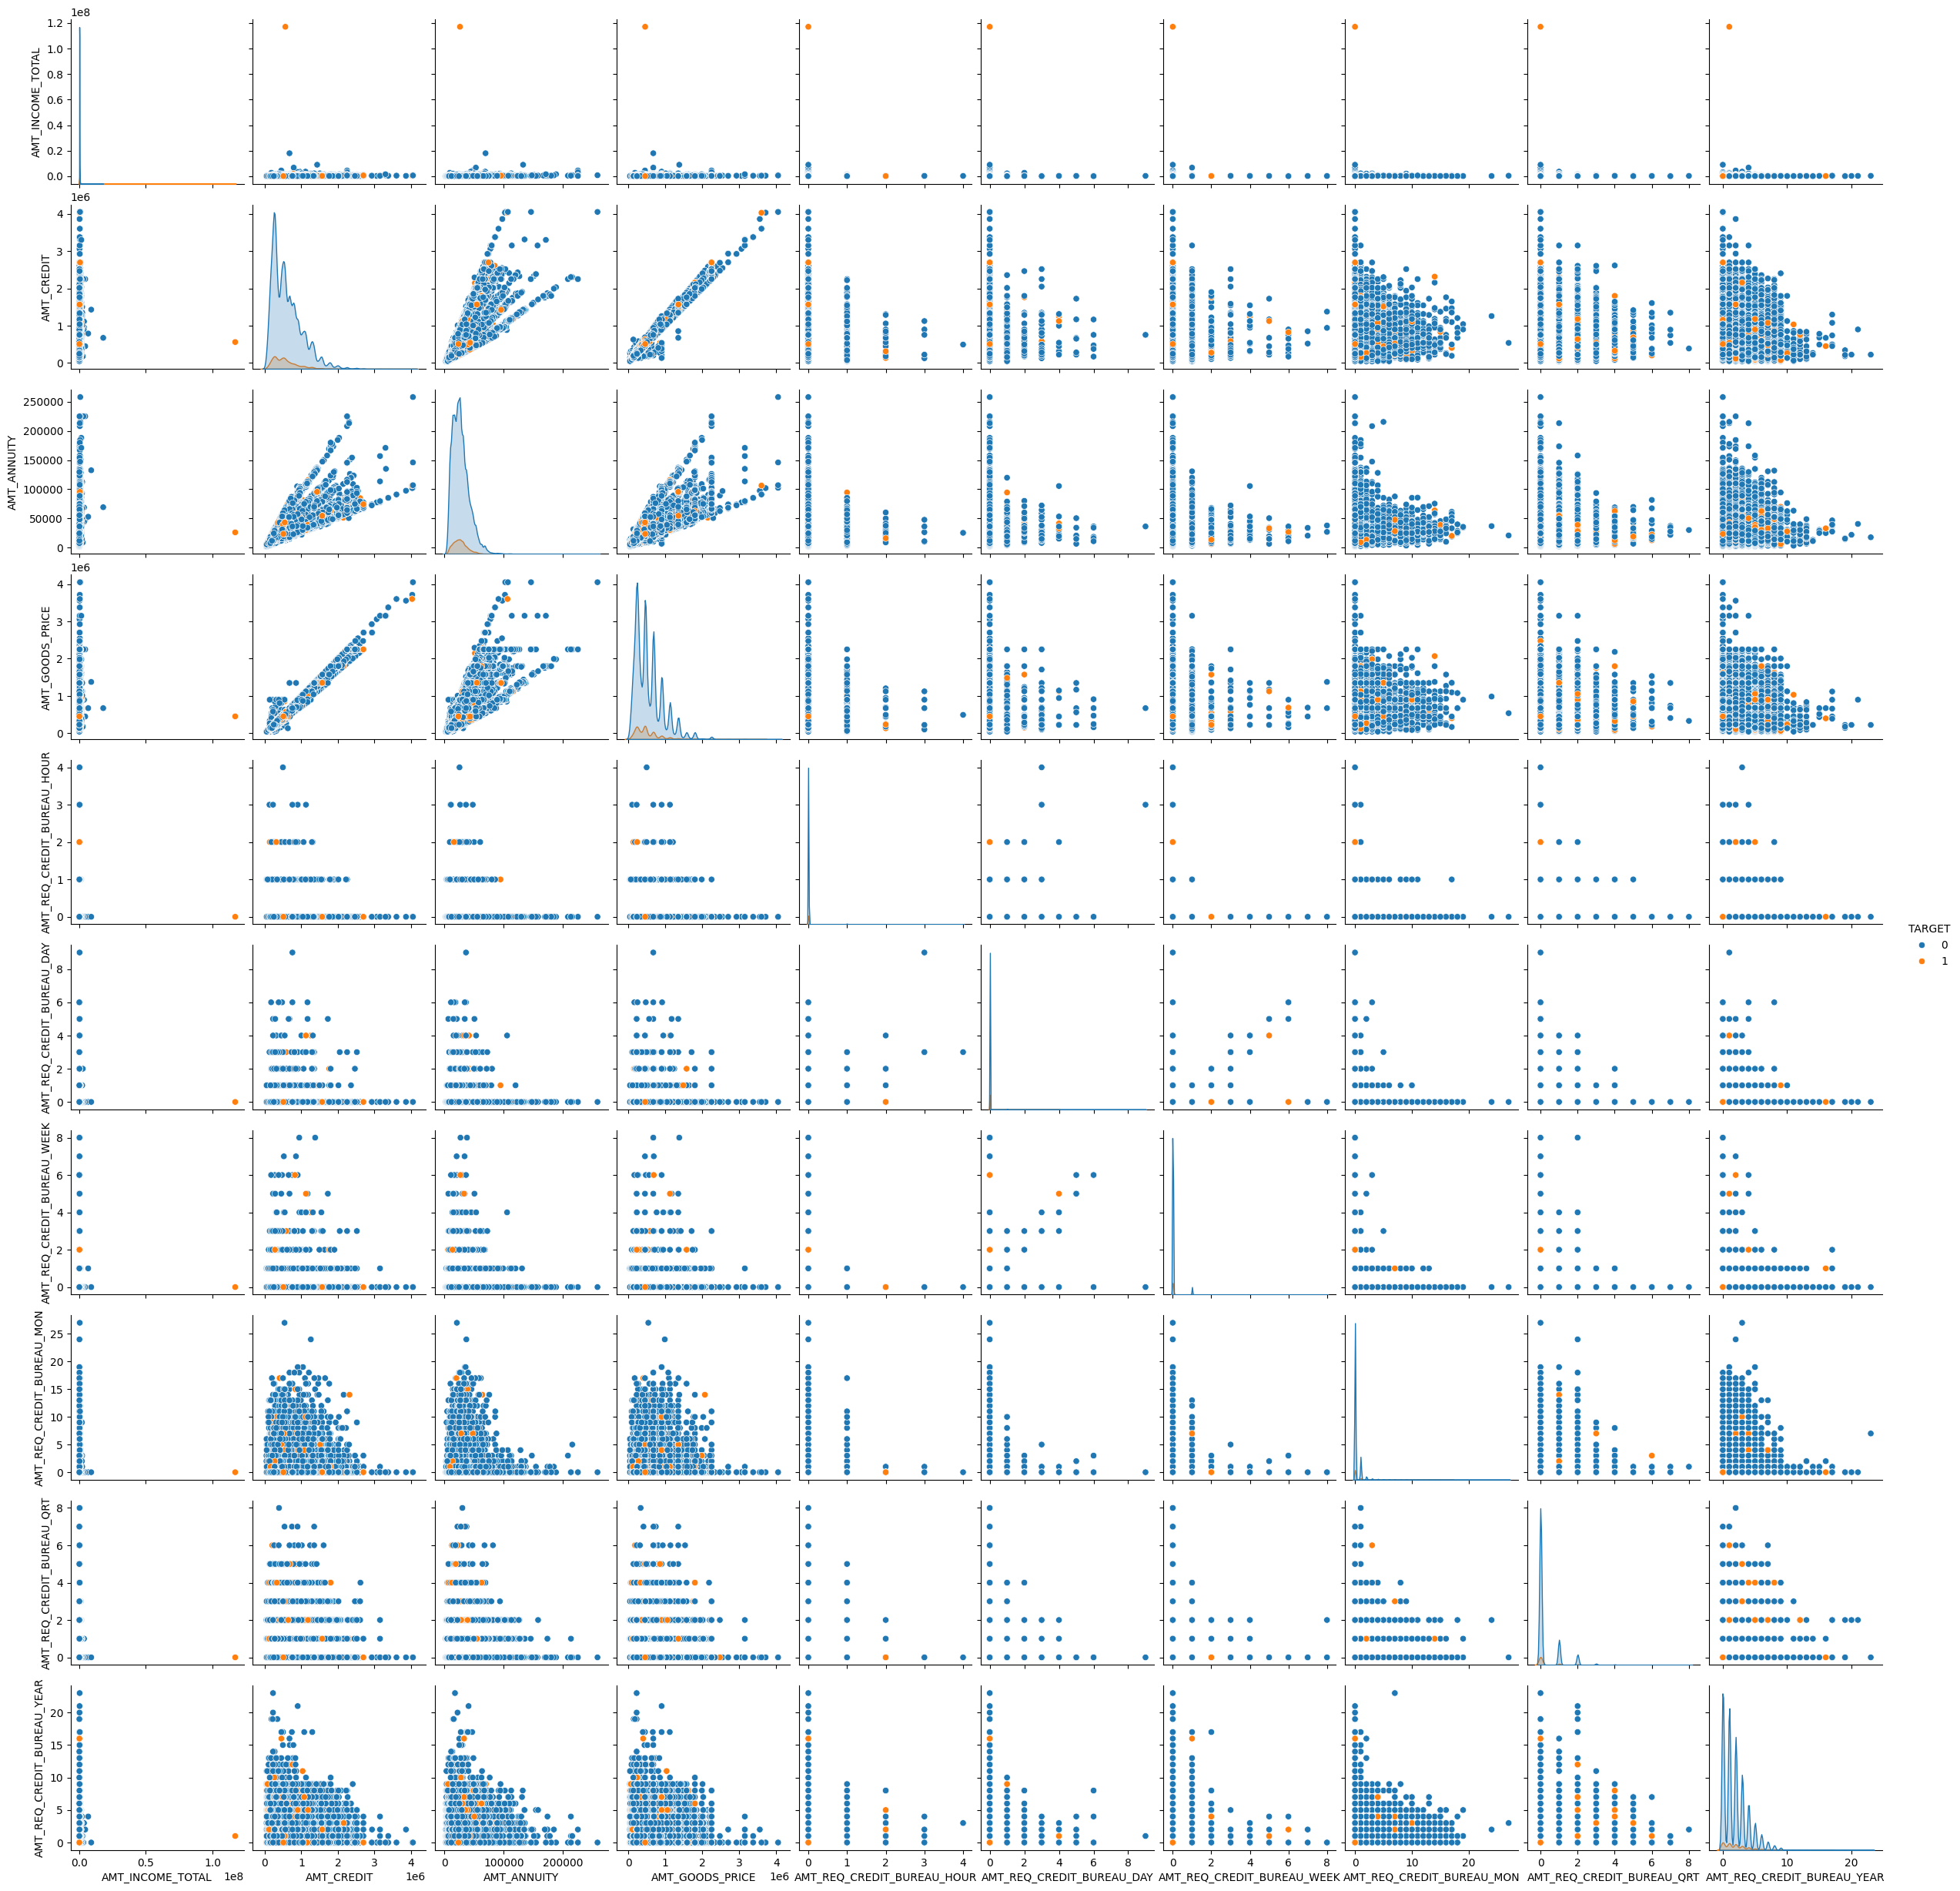

In [212]:
amt_cols = list(amt_df.columns) + ['TARGET']
sns.pairplot(X_train[amt_cols],hue='TARGET')

In [213]:
display_info(message="On ne remarque pas de corrélation particulière avec pairplot")

In [214]:
display_info(title="Matrice de correlation", color='green')
display_info(message="observer les correlation de nos différentes varibales AMT peut=être interressant")

In [215]:
def CorrMatrixDisplay(data, cmap=""):
    plt.figure(figsize=(15,8))
    correlation_matrix = data.corr()
    matrix = np.triu(correlation_matrix)
    if cmap:
        sns.heatmap(correlation_matrix, annot=True, mask=matrix, cmap='BrBG')
    else:
        sns.heatmap(correlation_matrix, annot=True, mask=matrix,)
    plt.show()

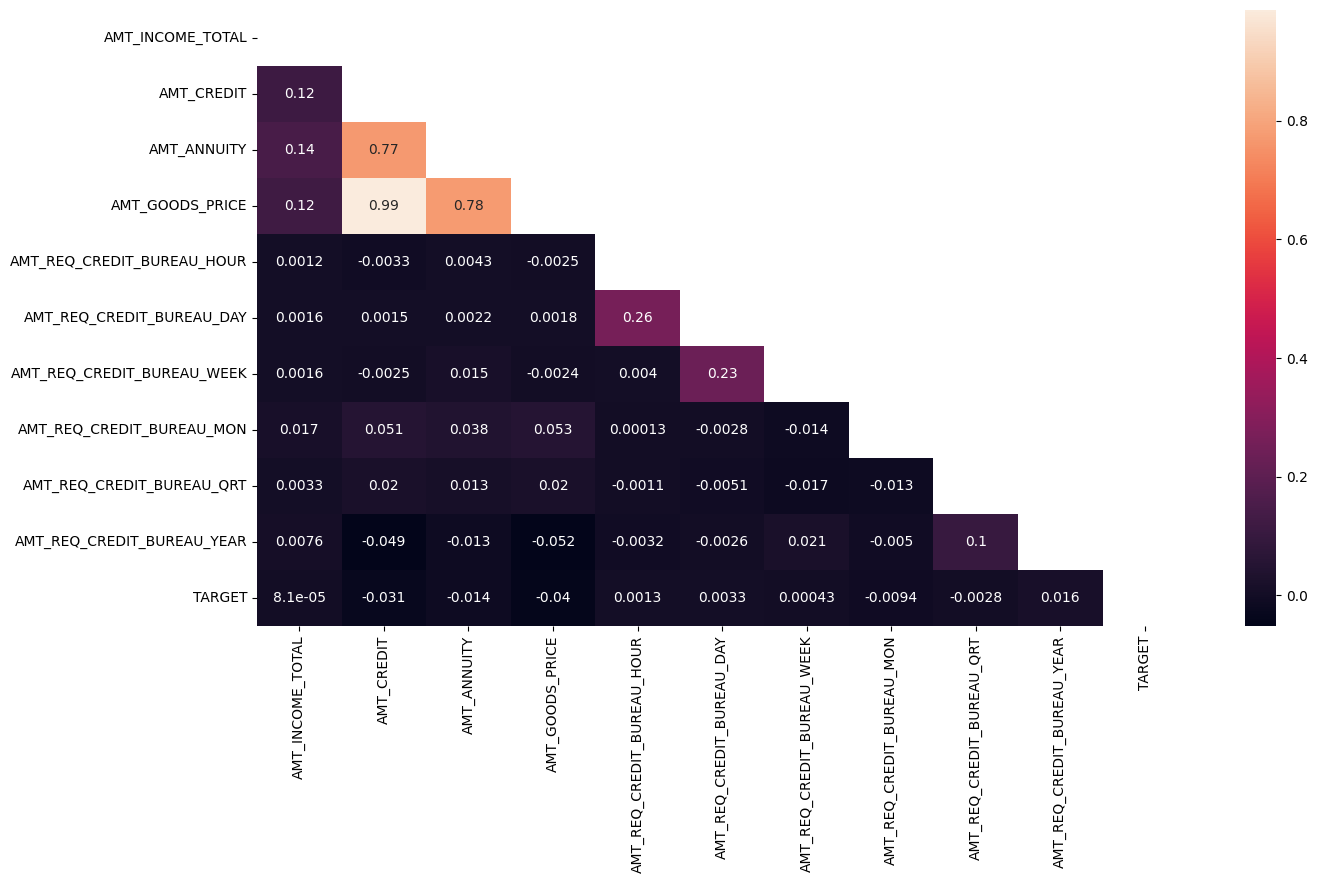

In [216]:
CorrMatrixDisplay(X_train[amt_cols])

In [217]:
display_info(pTag='ul',message="""<li>On observe la forte correlation entre AMT_CREDIT et AMT_GOODS_PRICE (> 0.9)</li></br>
             <li>On observe aussi une forte correlation entre AMT_ANNUITY et AMT_GOODS_PRICE (>0.75)</li></br>
             <li>Ainsi qu'une forte correlation entre AMT_ANNUITY et AMT_CREDIT (>0.75)</li>""")

In [218]:
display_info(title="Relation AMT/DAYS",color='white')
display_info('commencons par observer la correlation entre les variables DAYS et les variables AMT',color='white')

In [219]:
X_train[day_df.columns].describe()

DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count  153755.000000  126090.000000      153755.000000    153755.000000   
mean   -16026.191421   -2387.911103       -4995.964450     -2995.972580   
std      4365.641488    2342.298979        3528.670177      1508.248796   
min    -25200.000000  -17583.000000      -24672.000000     -6337.000000   
25%    -19676.000000   -3180.000000       -7490.000000     -4299.000000   
50%    -15732.000000   -1648.000000       -4513.000000     -3261.000000   
75%    -12393.000000    -765.000000       -2016.000000     -1722.000000   
max     -7673.000000       0.000000           0.000000         0.000000   

       DAYS_LAST_PHONE_CHANGE  
count           153754.000000  
mean              -966.609337  
std                827.743471  
min              -4173.000000  
25%              -1572.000000  
50%               -763.000000  
75%               -278.000000  
max                  0.000000

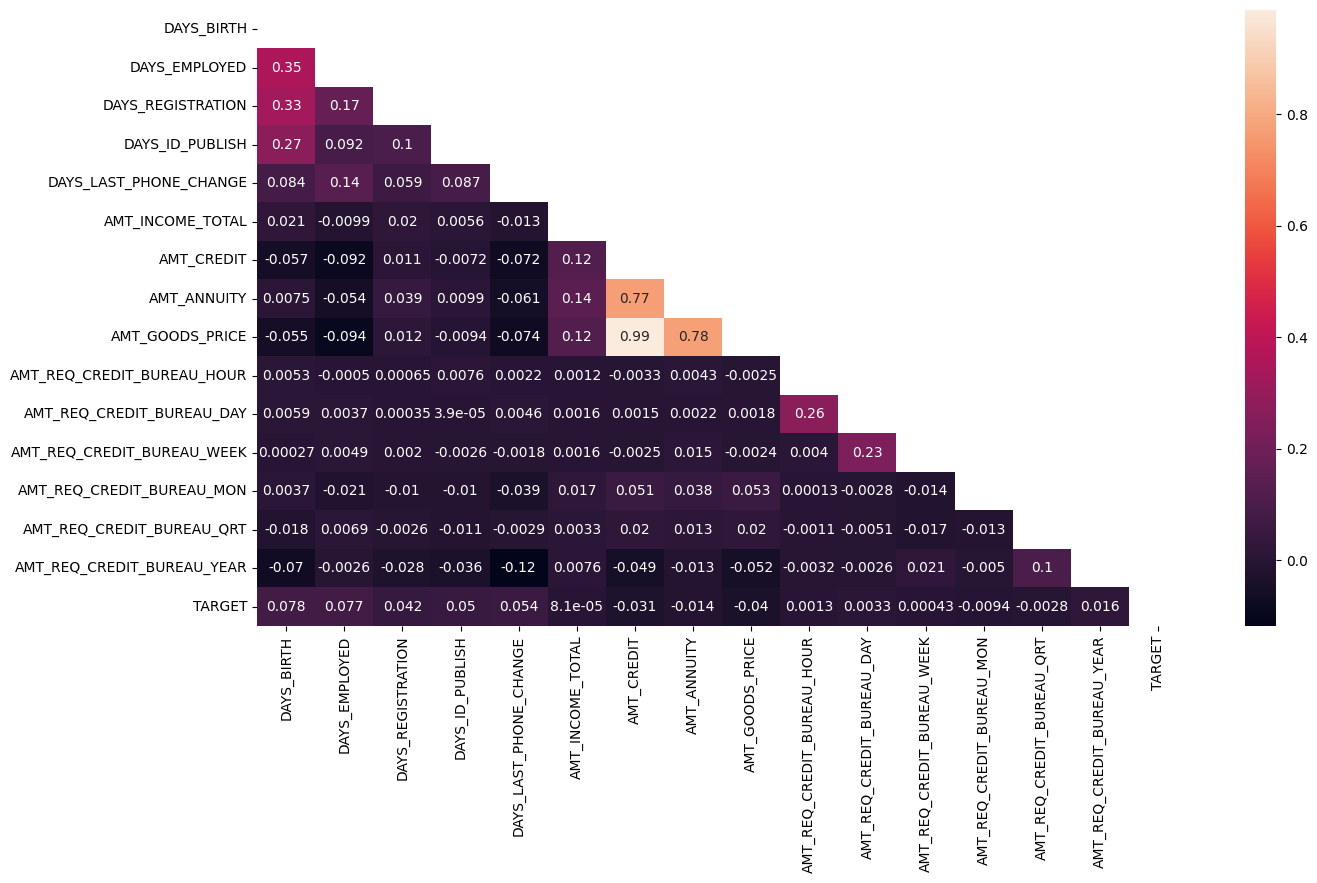

In [290]:
# correlation_matrix = X_train[day_df.columns].corr()
columnToCorr = day_df.columns.tolist() + amt_df.columns.tolist() + ['TARGET']
CorrMatrixDisplay(X_train[columnToCorr])

In [221]:
display_info(title="Ajoutons EXT__SOURCE à notre matrice de correlation", color="blue")
display_info(message="""On nous inoforme que les 3 données exterieurs (EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3) sont importante pour notre annalyse""")
display_info(message="""On regarde donc la correlation avec notre target des ces 3 variables""")

In [222]:
col_ext_source = ['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']
ext_source_Tocorr = X_train[col_ext_source]
ext_source_corr = ext_source_Tocorr.corr()
ext_source_corr

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.153748     -0.158775     -0.177265    0.077832
EXT_SOURCE_1 -0.153748      1.000000      0.212027      0.188771   -0.600958
EXT_SOURCE_2 -0.158775      0.212027      1.000000      0.108696   -0.092208
EXT_SOURCE_3 -0.177265      0.188771      0.108696      1.000000   -0.207999
DAYS_BIRTH    0.077832     -0.600958     -0.092208     -0.207999    1.000000

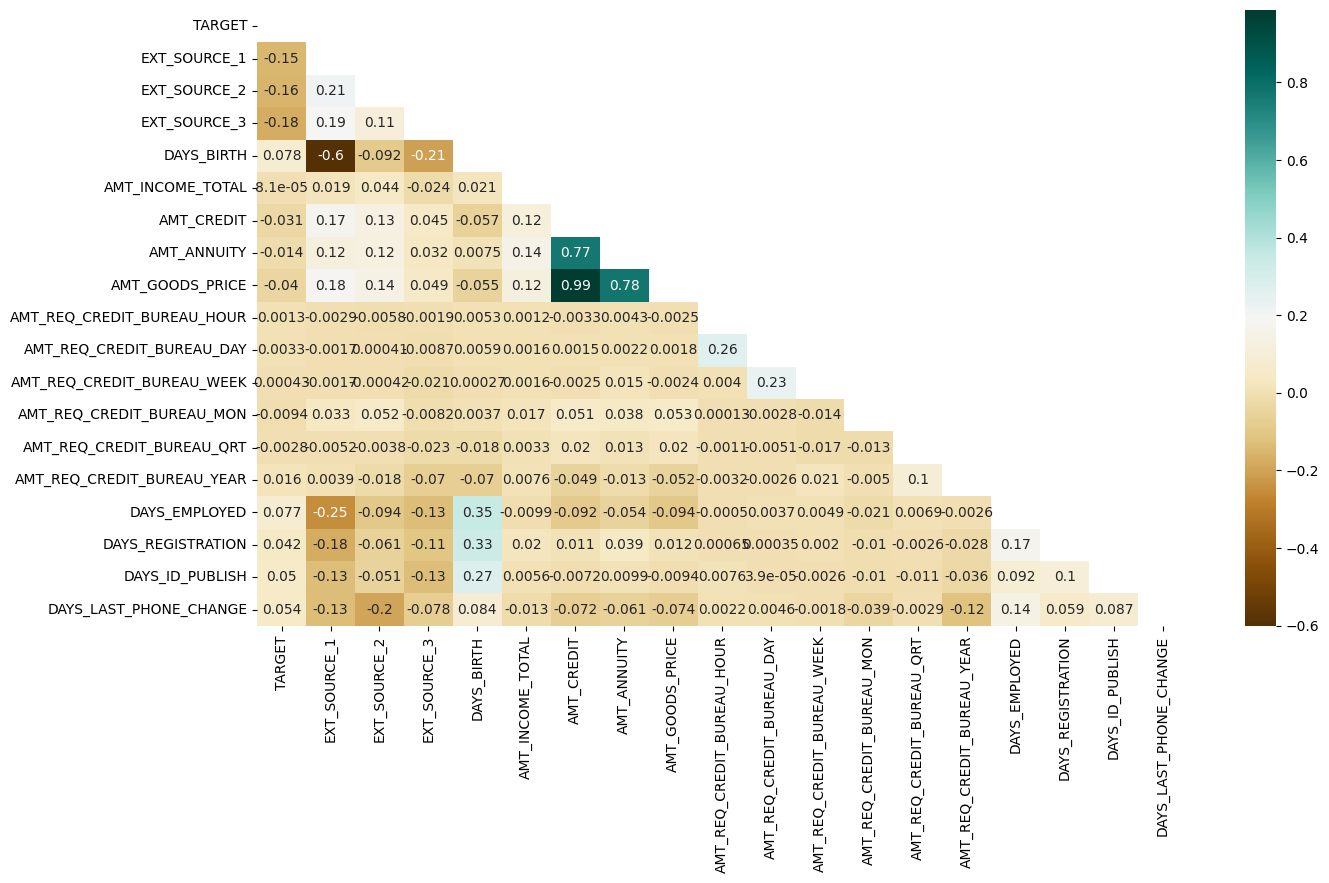

In [223]:
col_ext_source_amt_Days = col_ext_source + amt_df.columns.tolist() + day_df.columns.tolist()
col_to_use=[]
for col in col_ext_source_amt_Days:
    if col not in col_to_use:
        col_to_use.append(col)

CorrMatrixDisplay(X_train[col_to_use], cmap= "RdYlBu")


In [224]:
display_info(pTag='ul',message="""<li>Les variables EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3 semblent être des indicateurs 
             pertinents de la solvabilité ou du risque du client, car elles sont négativement corrélées à la variable cible TARGET.</li></br>
             <li>L’âge des clients (DAYS_BIRTH) est faiblement lié aux autres variables et à TARGET, suggérant qu’il n’y a pas de forte influence de l’âge sur les difficultés financières, du moins pas directement.</li>""")

In [225]:
ext_source_Tocorr.columns

Index(['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'], dtype='object')

In [226]:
clientInGood_df,clientInPain_df=splitClientByTarget(X_train[col_ext_source])

In [227]:
clientInGood_df.columns

Index(['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'], dtype='object')

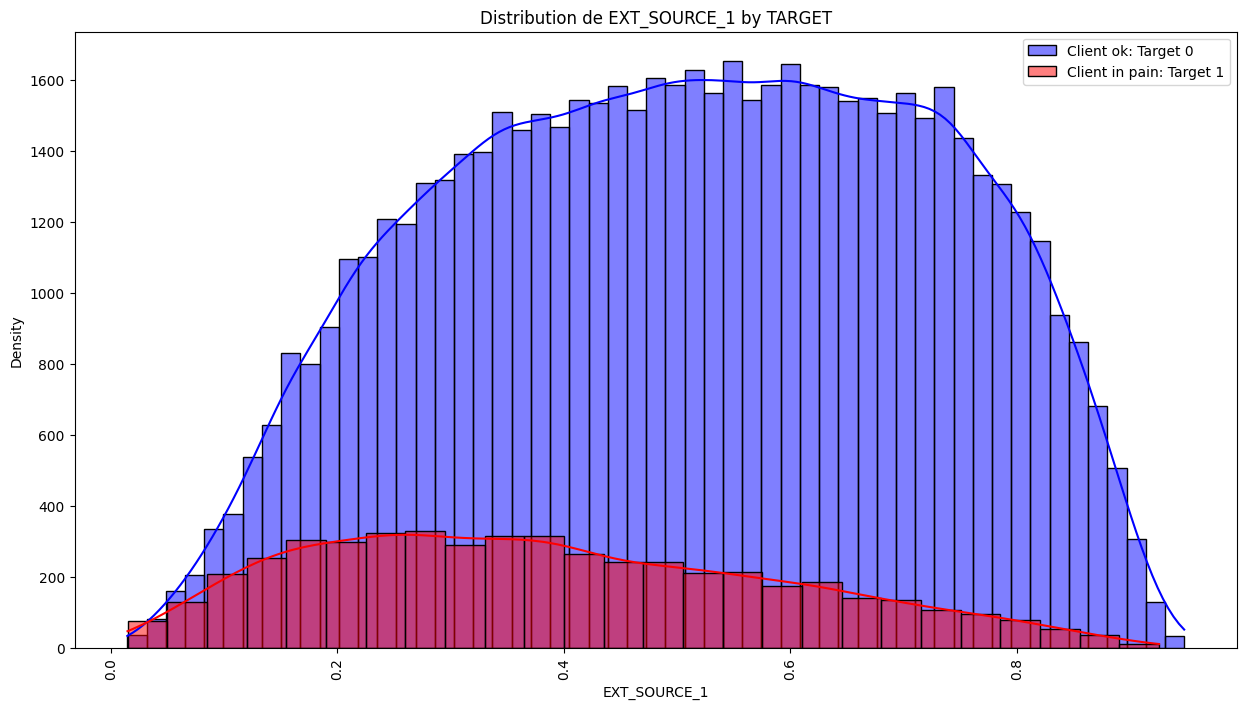

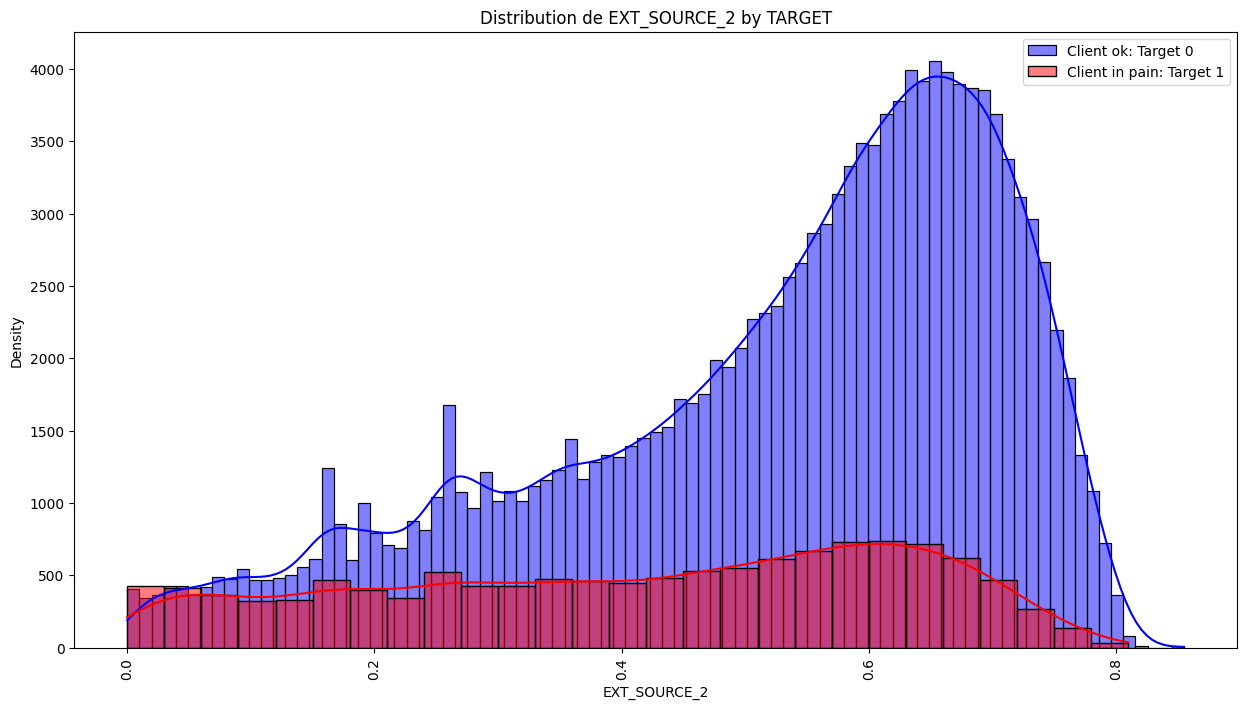

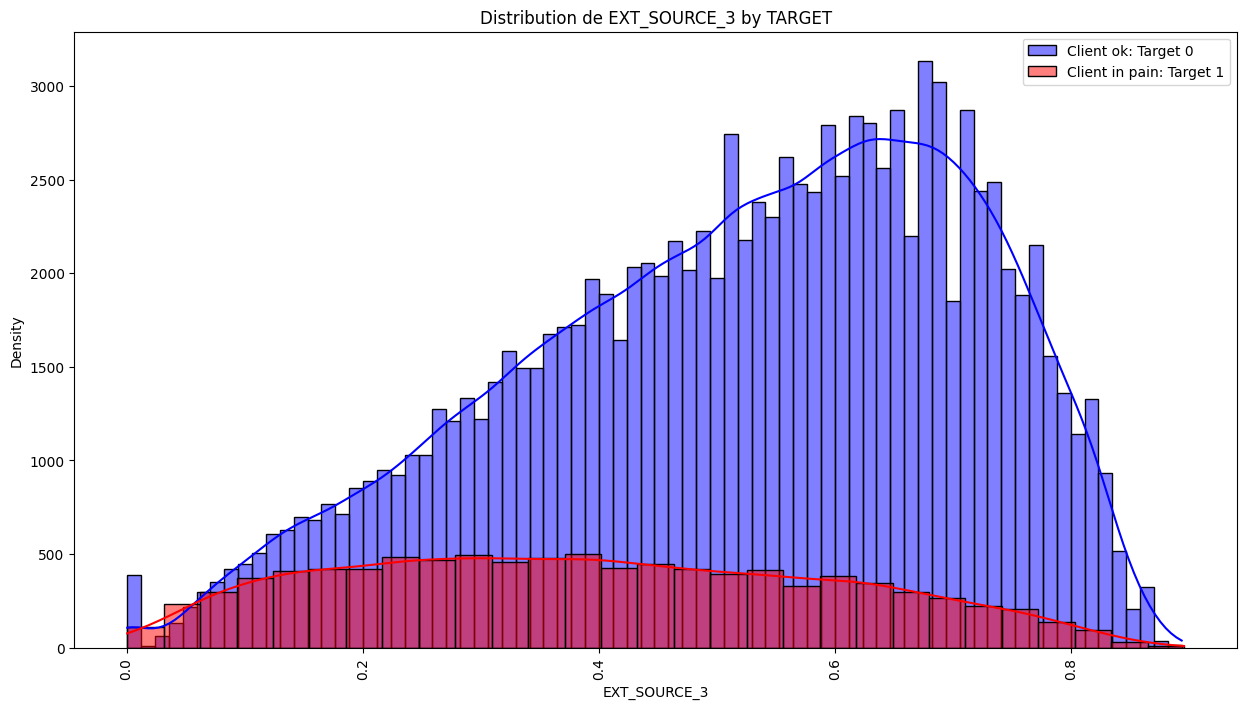

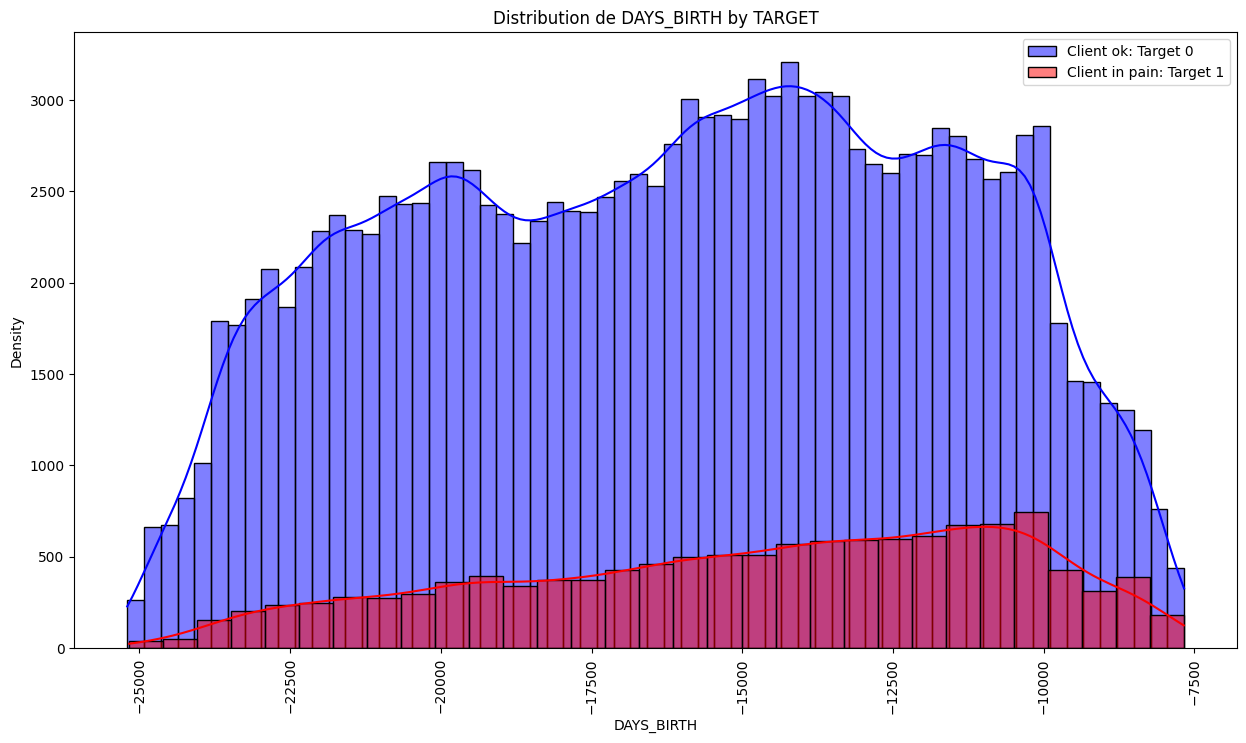

In [228]:

clientInGood_df,clientInPain_df=splitClientByTarget(X_train[col_ext_source])
for col in [col for col in col_ext_source if col!='TARGET']:
    displayHisplot(clientInGood_df[col],clientInPain_df[col], col)



In [229]:
display_info(title='Aggregation des fichiers Bureau, Bureau_balance et X_train',color='white')

In [230]:
X_train_initial = pd.read_csv('../datas/application_train.csv')
X_train_aggregate = X_train_initial.copy()
mergeBureauWithX_train= pd.merge(bureau,X_train_aggregate,on='SK_ID_CURR', how='left', suffixes=('_ByCredit','_global'))
mergeBureauWithX_train.shape
df_filtered = bureau_balance[bureau_balance['MONTHS_BALANCE']!=0]
min_month_bureau_balance = df_filtered.loc[df_filtered.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].idxmax()]
min_month_bureau_balance.shape
mergeAppAndBureauWithBureau_balance = pd.merge(mergeBureauWithX_train,min_month_bureau_balance, on='SK_ID_BUREAU', how='left')
X_train_aggregate= mergeAppAndBureauWithBureau_balance.copy()

In [231]:
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [232]:
X_train_aggregate.shape

(1716428, 140)

In [233]:
display_info(message="""On a fait notre EDA sur le fichier X_train mais nous avons d'autres informations.
             </br>
             En revanche cela donnerais beaucoup d'individu nouveau """)
display_info(message="""On fait un encodage one-hot de nos variable qualitative qui sera necessaire pour nos modeles future""")

In [234]:
def encode_df(df):
    X_train=df
    categorical_cols = X_train.select_dtypes(include=['object']).columns

    df_encoded = pd.get_dummies(X_train, columns=categorical_cols)
    df_encoded_NaNclear = df_encoded.dropna(subset=['TARGET'])
    return df_encoded,df_encoded_NaNclear

In [235]:
df_encoded,df_encoded_NaNclear= encode_df(X_train)

In [236]:
def df_corr(df,df_encoded):
    correl_All = df_encoded.drop('YEARS_BINNED', axis=1).corr()
    target_correlation = correl_All['TARGET']

    sorted_target_correlation = target_correlation.abs().sort_values(ascending=False)
    print(sorted_target_correlation.head(20))
df_corr(X_train,df_encoded)


TARGET                                               1.000000
EXT_SOURCE_3                                         0.177265
EXT_SOURCE_2                                         0.158775
EXT_SOURCE_1                                         0.153748
YEARS_BIRTH                                          0.077832
DAYS_BIRTH                                           0.077832
DAYS_EMPLOYED                                        0.076736
REGION_RATING_CLIENT                                 0.059141
NAME_EDUCATION_TYPE_Higher education                 0.055588
NAME_INCOME_TYPE_Working                             0.054228
DAYS_LAST_PHONE_CHANGE                               0.053896
CODE_GENDER_M                                        0.052276
CODE_GENDER_F                                        0.052272
DAYS_ID_PUBLISH                                      0.050345
NAME_EDUCATION_TYPE_Secondary / secondary special    0.048491
NAME_INCOME_TYPE_Pensioner                           0.045674
ORGANIZA

In [237]:
display_info(title="Feature Importance",color='white')
display_info(message="On veux selectionner les features les plus importantes</br> On commence par utiliser different modele de feature importance",)
display_info(message="LGBM (LightGBM)",bgd="green")

In [238]:
def lgbm_featureImportances(X,y):
    model=lgb.LGBMClassifier()
    model.fit(X,y)

    importances = model.feature_importances_
    indices = importances.argsort()
    name='LightGBM'
    feature_names = X.columns
    feature_importances= pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    })
    return importances, indices,name, feature_importances

In [239]:
display_info(message="XgBoost",bgd="green")

In [240]:
def xgBoost_featureImportances(X,y):
    model=xgb.XGBClassifier()
    model.fit(X,y)
    importances = model.feature_importances_
    indices = importances.argsort()
    name='XGBoost'
    return importances, indices,name

In [241]:
display_info(message="RandomForest",bgd='green')

In [242]:
def randomForest_featureImportances(X,y):
    model = RandomForestClassifier(random_state=42)
    model.fit(X,y)
    importances = model.feature_importances_
    indices = importances.argsort()
    name='RandomForest'
    
    return importances, indices, name

In [243]:
# from sklearn.preprocessing import OneHotEncoder
def feature_importanceGraph(importances,indices, name):
    n_features = len(df_encoded_NaNclear.columns)
    fig_height = n_features * 0.5
    plt.figure(figsize=(10,fig_height))
    plt.barh(range(len(indices[-n_features:])), importances[indices[-n_features:]], align='center')
    plt.yticks(range(len(indices[-n_features:])), [X.columns[i] for i in indices[-n_features:]], fontsize=8)
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'Top {n_features} Feature Importances with {name}')
    plt.show()

In [244]:
def display_featureImportance(X,y):

    lgbm_importances, lgbm_indices,lgbm_name,_= lgbm_featureImportances(X,y);
    xgBoost_importances, xgBoost_indices,xgBoost_name= xgBoost_featureImportances(X,y);
    randomForest_importances, _,randomForest_name= randomForest_featureImportances(X,y);

    feature_names = X.columns
    importances_df = pd.DataFrame({
        'Features': feature_names,
        f'{lgbm_name} Importance':lgbm_importances,
        f'{xgBoost_name} Importance' :xgBoost_importances,
        f'{randomForest_name} Importance' :randomForest_importances,
    })

    # Fonction pour réorganiser l'ordre des colonnes en fonction du tri
    def reorder_columns(df, primary_model):
        cols = ['Features', primary_model] + [col for col in df.columns if col != 'Features' and col != primary_model]
        return df[cols]
    
    print(f"=== Feature importance classé par ordre décroissant sur {lgbm_name} ===")
    importances_dfLGBM = importances_df.sort_values(by=f'{lgbm_name} Importance', ascending=False)
    importances_lgbm_reordered = reorder_columns(importances_dfLGBM, f'{lgbm_name} Importance')
    display(importances_lgbm_reordered)

    print(f"=== Feature importance classé par ordre décroissant sur {xgBoost_name} ===")
    importances_xgboost = importances_df.sort_values(by=f'{xgBoost_name} Importance', ascending=False)
    importances_xgBoost_reordered = reorder_columns(importances_xgboost, f'{xgBoost_name} Importance')
    display(importances_xgBoost_reordered)
   
    print(f"=== Feature importance classé par ordre décroissant sur {randomForest_name} ===")
    importances_randomForest = importances_df.sort_values(by=f'{randomForest_name} Importance', ascending=False)
    importances_xgBoost_reordered = reorder_columns(importances_randomForest, f'{randomForest_name} Importance')
    display(importances_xgBoost_reordered)
    # tools.display_dataframe_to_user(name="Feature Importance Comparison", dataframe=feature_importance_comparison)
    
    feature_importanceGraph(lgbm_importances,lgbm_indices, lgbm_name);
    # feature_importanceGraph(xgBoost_importances,xgBoost_indices, xgBoost_name);
    # feature_importanceGraph(randomForest_importances,randomForest_indices, randomForest_name);


[LightGBM] [Info] Number of positive: 12412, number of negative: 141343
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4082
[LightGBM] [Info] Number of data points in the train set: 153755, number of used features: 160
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080726 -> initscore=-2.432526
[LightGBM] [Info] Start training from score -2.432526
=== Feature importance classé par ordre décroissant sur LightGBM ===


Features  LightGBM Importance  XGBoost Importance  \
22                  EXT_SOURCE_3                  250            0.025774   
21                  EXT_SOURCE_2                  242            0.024658   
20                  EXT_SOURCE_1                  230            0.012651   
8                  DAYS_EMPLOYED                  173            0.009978   
4                    AMT_ANNUITY                  161            0.008692   
..                           ...                  ...                 ...   
13                FLAG_EMP_PHONE                    0            0.000000   
77   NAME_INCOME_TYPE_Unemployed                    0            0.000000   
76      NAME_INCOME_TYPE_Student                    0            0.000000   
74    NAME_INCOME_TYPE_Pensioner                    0            0.000000   
170        ORGANIZATION_TYPE_XNA                    0            0.000000   

     RandomForest Importance  
22                  0.058144  
21                  0.063026  
20                  0.033196  
8                   0.041316  
4                   0.039912  
..                       ...  
13                  0.001096  
77                  0.000038  
76                  0.000002  
74                  0.001168  
170                 0.001155  

[171 rows x 4 columns]

=== Feature importance classé par ordre décroissant sur XGBoost ===


Features  XGBoost Importance  \
22                                        EXT_SOURCE_3            0.025774   
21                                        EXT_SOURCE_2            0.024658   
57                                       CODE_GENDER_F            0.020003   
80                NAME_EDUCATION_TYPE_Higher_education            0.019279   
83   NAME_EDUCATION_TYPE_Secondary___secondary_special            0.018154   
..                                                 ...                 ...   
130                ORGANIZATION_TYPE_Industry__type_12            0.000000   
132                 ORGANIZATION_TYPE_Industry__type_2            0.000000   
136                 ORGANIZATION_TYPE_Industry__type_6            0.000000   
138                 ORGANIZATION_TYPE_Industry__type_8            0.000000   
170                              ORGANIZATION_TYPE_XNA            0.000000   

     LightGBM Importance  RandomForest Importance  
22                   250                 0.058144  
21                   242                 0.063026  
57                    36                 0.004450  
80                    30                 0.003748  
83                    18                 0.004300  
..                   ...                      ...  
130                    0                 0.000249  
132                    0                 0.000441  
136                    0                 0.000076  
138                    0                 0.000026  
170                    0                 0.001155  

[171 rows x 4 columns]

=== Feature importance classé par ordre décroissant sur RandomForest ===


Features  RandomForest Importance  \
21                      EXT_SOURCE_2             6.302632e-02   
22                      EXT_SOURCE_3             5.814364e-02   
9                  DAYS_REGISTRATION             4.355951e-02   
7                         DAYS_BIRTH             4.294098e-02   
10                   DAYS_ID_PUBLISH             4.293511e-02   
..                               ...                      ...   
71      NAME_INCOME_TYPE_Businessman             1.878323e-08   
73  NAME_INCOME_TYPE_Maternity_leave             0.000000e+00   
36                  FLAG_DOCUMENT_10             0.000000e+00   
59                   CODE_GENDER_XNA             0.000000e+00   
38                  FLAG_DOCUMENT_12             0.000000e+00   

    LightGBM Importance  XGBoost Importance  
21                  242            0.024658  
22                  250            0.025774  
9                   130            0.006584  
7                   110            0.008144  
10                  134            0.007140  
..                  ...                 ...  
71                    0            0.000000  
73                    0            0.000000  
36                    0            0.000000  
59                    0            0.000000  
38                    0            0.000000  

[171 rows x 4 columns]

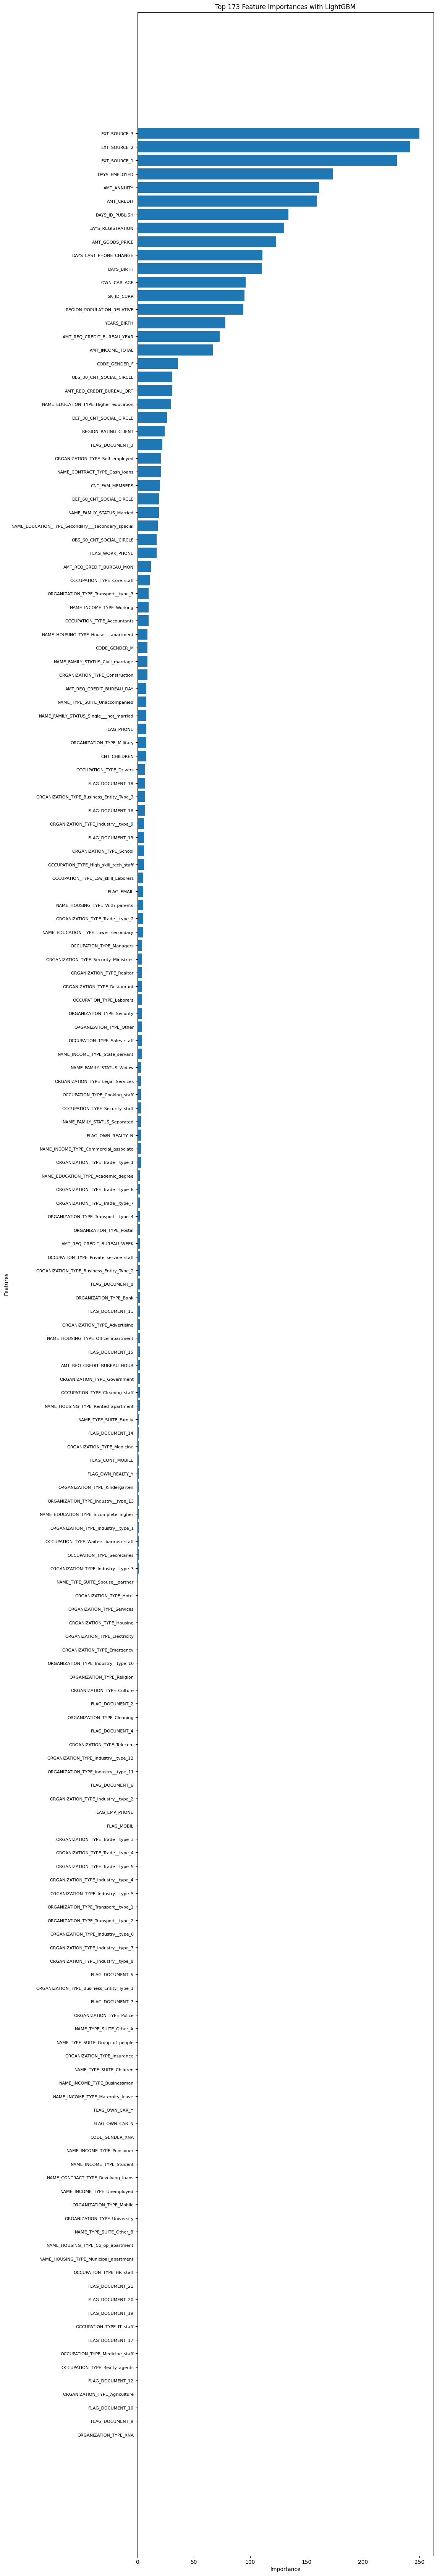

In [245]:
df_encoded.columns = df_encoded.columns.str.replace(r'[^A-Za-z0-9_]', '_', regex=True)
X = df_encoded.drop(columns=['TARGET','YEARS_BINNED'], axis= 1)
y = df_encoded['TARGET']
display_featureImportance(X,y)

In [246]:
display_info(message="""On remarque un classement différents en fonction du model utilisé.</br> On nous dit dans les informations que EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_3 sont des features importante.</br>
             On peut donc naturelement selectionner LightGBM qui met en avant ces 3 variables et créer d'autre variables dite polynomiales """)

In [247]:
display_info(title="Polynomiale Features", color="blue", fontsize="30px")
display_info(message="Une approche courante consiste à sélectionner les variables jusqu’à atteindre un certain pourcentage de l’importance totale, par exemple 90%.</br>Cela permet de réduire la complexité tout en conservant les variables les plus importantes.")
display_info(message="""Etant donnée que le nombre de feature augmente de façon exponnentiel, on ne veut pas en selectionner de trop. On pourrait selectionner toutes les feature qui nous donne une importance cumulé de 90%.</br>
             Mais cela nous donnerais plus de 450 polynomiale features au total et nous risquerions d'avoir un surapprentissage de notre future modèle</br>
             On selectionnera donc nous même les features.</br>
             Mais pour se rendre compte du process, nous laissons le code permetant de faire cette selection en fonction du pourcentage de l'importance cumulé souhaité""")

In [248]:
def cumulative_importance(df):
    df=df.sort_values(by="Importance", ascending=False)
    df['Normalized Importance']=(df["Importance"] / df["Importance"].sum()) * 100
    df['Cumulative_Importance']=df['Normalized Importance'].cumsum()
    # print(df)
    return df

In [249]:
def selected_feature(Cumulative_importance_df):
    feature_selected = Cumulative_importance_df[Cumulative_importance_df['Cumulative_Importance']<=90]['Feature']
    feature_selected.head(35)
    return feature_selected

In [250]:
_,_,_,feature_importances= lgbm_featureImportances(X,y)
Cumulative_importance_df = cumulative_importance(feature_importances)
selected_feature = selected_feature(Cumulative_importance_df)
print(selected_feature)

[LightGBM] [Info] Number of positive: 12412, number of negative: 141343
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4082
[LightGBM] [Info] Number of data points in the train set: 153755, number of used features: 160
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080726 -> initscore=-2.432526
[LightGBM] [Info] Start training from score -2.432526
22                                          EXT_SOURCE_3
21                                          EXT_SOURCE_2
20                                          EXT_SOURCE_1
8                                          DAYS_EMPLOYED
4                                            AMT_ANNUITY
3                                             AMT_CREDIT
10                                       DAYS_ID_PUBLISH
9                                      D

## Feature Engineering

In [251]:
poly_feature_choice=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_EMPLOYED','AMT_ANNUITY','AMT_CREDIT','DAYS_BIRTH','TARGET']
poly_feature = X_train[poly_feature_choice]

In [252]:
display_info(message="""Le calcul polynomial nous impose de traiter les valeurs NaN.</br>
             On va donc traiter cela en utilisant la mediane. Afin de garder une position la plus neutre possible danss notre dataSet""")

<Axes: >

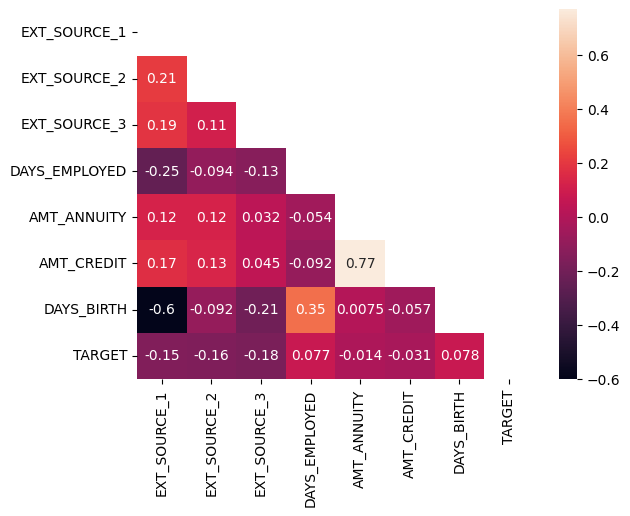

In [253]:
new_corr = poly_feature.corr()
matrix = np.triu(new_corr)
sns.heatmap(new_corr, annot=True, mask=matrix)

In [254]:
poly_target = poly_feature['TARGET']
poly_feature = poly_feature.drop(columns = ['TARGET'])

In [255]:
imputer = SimpleImputer(strategy = 'median')
poly_feature = imputer.fit_transform(poly_feature)

In [256]:
poly_feature_df = pd.DataFrame(poly_feature)

In [257]:
poly_feature_df.isna().sum().sum()

np.int64(0)

In [259]:
max_deg = 2
poly_transformer = PolynomialFeatures(degree=max_deg, include_bias=False)
X_poly = poly_transformer.fit_transform(poly_feature)

In [260]:
print('Polynomial Features shape: ', X_poly.shape)

Polynomial Features shape:  (153755, 35)


In [261]:
display_info(message="Voici la liste de nos Feature polynomiale :")
poly_feature_names = poly_transformer.get_feature_names_out(input_features=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_EMPLOYED','AMT_ANNUITY','AMT_CREDIT','DAYS_BIRTH'])

poly_feature_names

array(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED',
       'AMT_ANNUITY', 'AMT_CREDIT', 'DAYS_BIRTH', 'EXT_SOURCE_1^2',
       'EXT_SOURCE_1 EXT_SOURCE_2', 'EXT_SOURCE_1 EXT_SOURCE_3',
       'EXT_SOURCE_1 DAYS_EMPLOYED', 'EXT_SOURCE_1 AMT_ANNUITY',
       'EXT_SOURCE_1 AMT_CREDIT', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_EMPLOYED', 'EXT_SOURCE_2 AMT_ANNUITY',
       'EXT_SOURCE_2 AMT_CREDIT', 'EXT_SOURCE_2 DAYS_BIRTH',
       'EXT_SOURCE_3^2', 'EXT_SOURCE_3 DAYS_EMPLOYED',
       'EXT_SOURCE_3 AMT_ANNUITY', 'EXT_SOURCE_3 AMT_CREDIT',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_EMPLOYED^2',
       'DAYS_EMPLOYED AMT_ANNUITY', 'DAYS_EMPLOYED AMT_CREDIT',
       'DAYS_EMPLOYED DAYS_BIRTH', 'AMT_ANNUITY^2',
       'AMT_ANNUITY AMT_CREDIT', 'AMT_ANNUITY DAYS_BIRTH', 'AMT_CREDIT^2',
       'AMT_CREDIT DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [262]:
display_info(message="""On a nos Feature polynomiales calculé au degrés 2. </br>
             On peut reggarder la correlation de ces feature avec TARGET""")

In [263]:
poly_feature_df=pd.DataFrame(X_poly,columns=poly_feature_names)
poly_feature_df['TARGET'] = poly_target

In [264]:
poly_corrs = pd.DataFrame(poly_feature_df)
poly_corrs= poly_corrs.corr()
poly_corrs_sorted = poly_corrs['TARGET'].sort_values(ascending=True)
poly_corrs_sorted.head()

EXT_SOURCE_1 EXT_SOURCE_2   -0.005167
EXT_SOURCE_1                -0.004600
EXT_SOURCE_1^2              -0.004047
EXT_SOURCE_1 AMT_CREDIT     -0.003896
EXT_SOURCE_1 AMT_ANNUITY    -0.003697
Name: TARGET, dtype: float64

In [265]:
poly_corrs_sorted.tail()

EXT_SOURCE_3^2             0.002075
AMT_CREDIT DAYS_BIRTH      0.002075
EXT_SOURCE_3               0.002524
EXT_SOURCE_1 DAYS_BIRTH    0.002641
TARGET                     1.000000
Name: TARGET, dtype: float64

<Axes: >

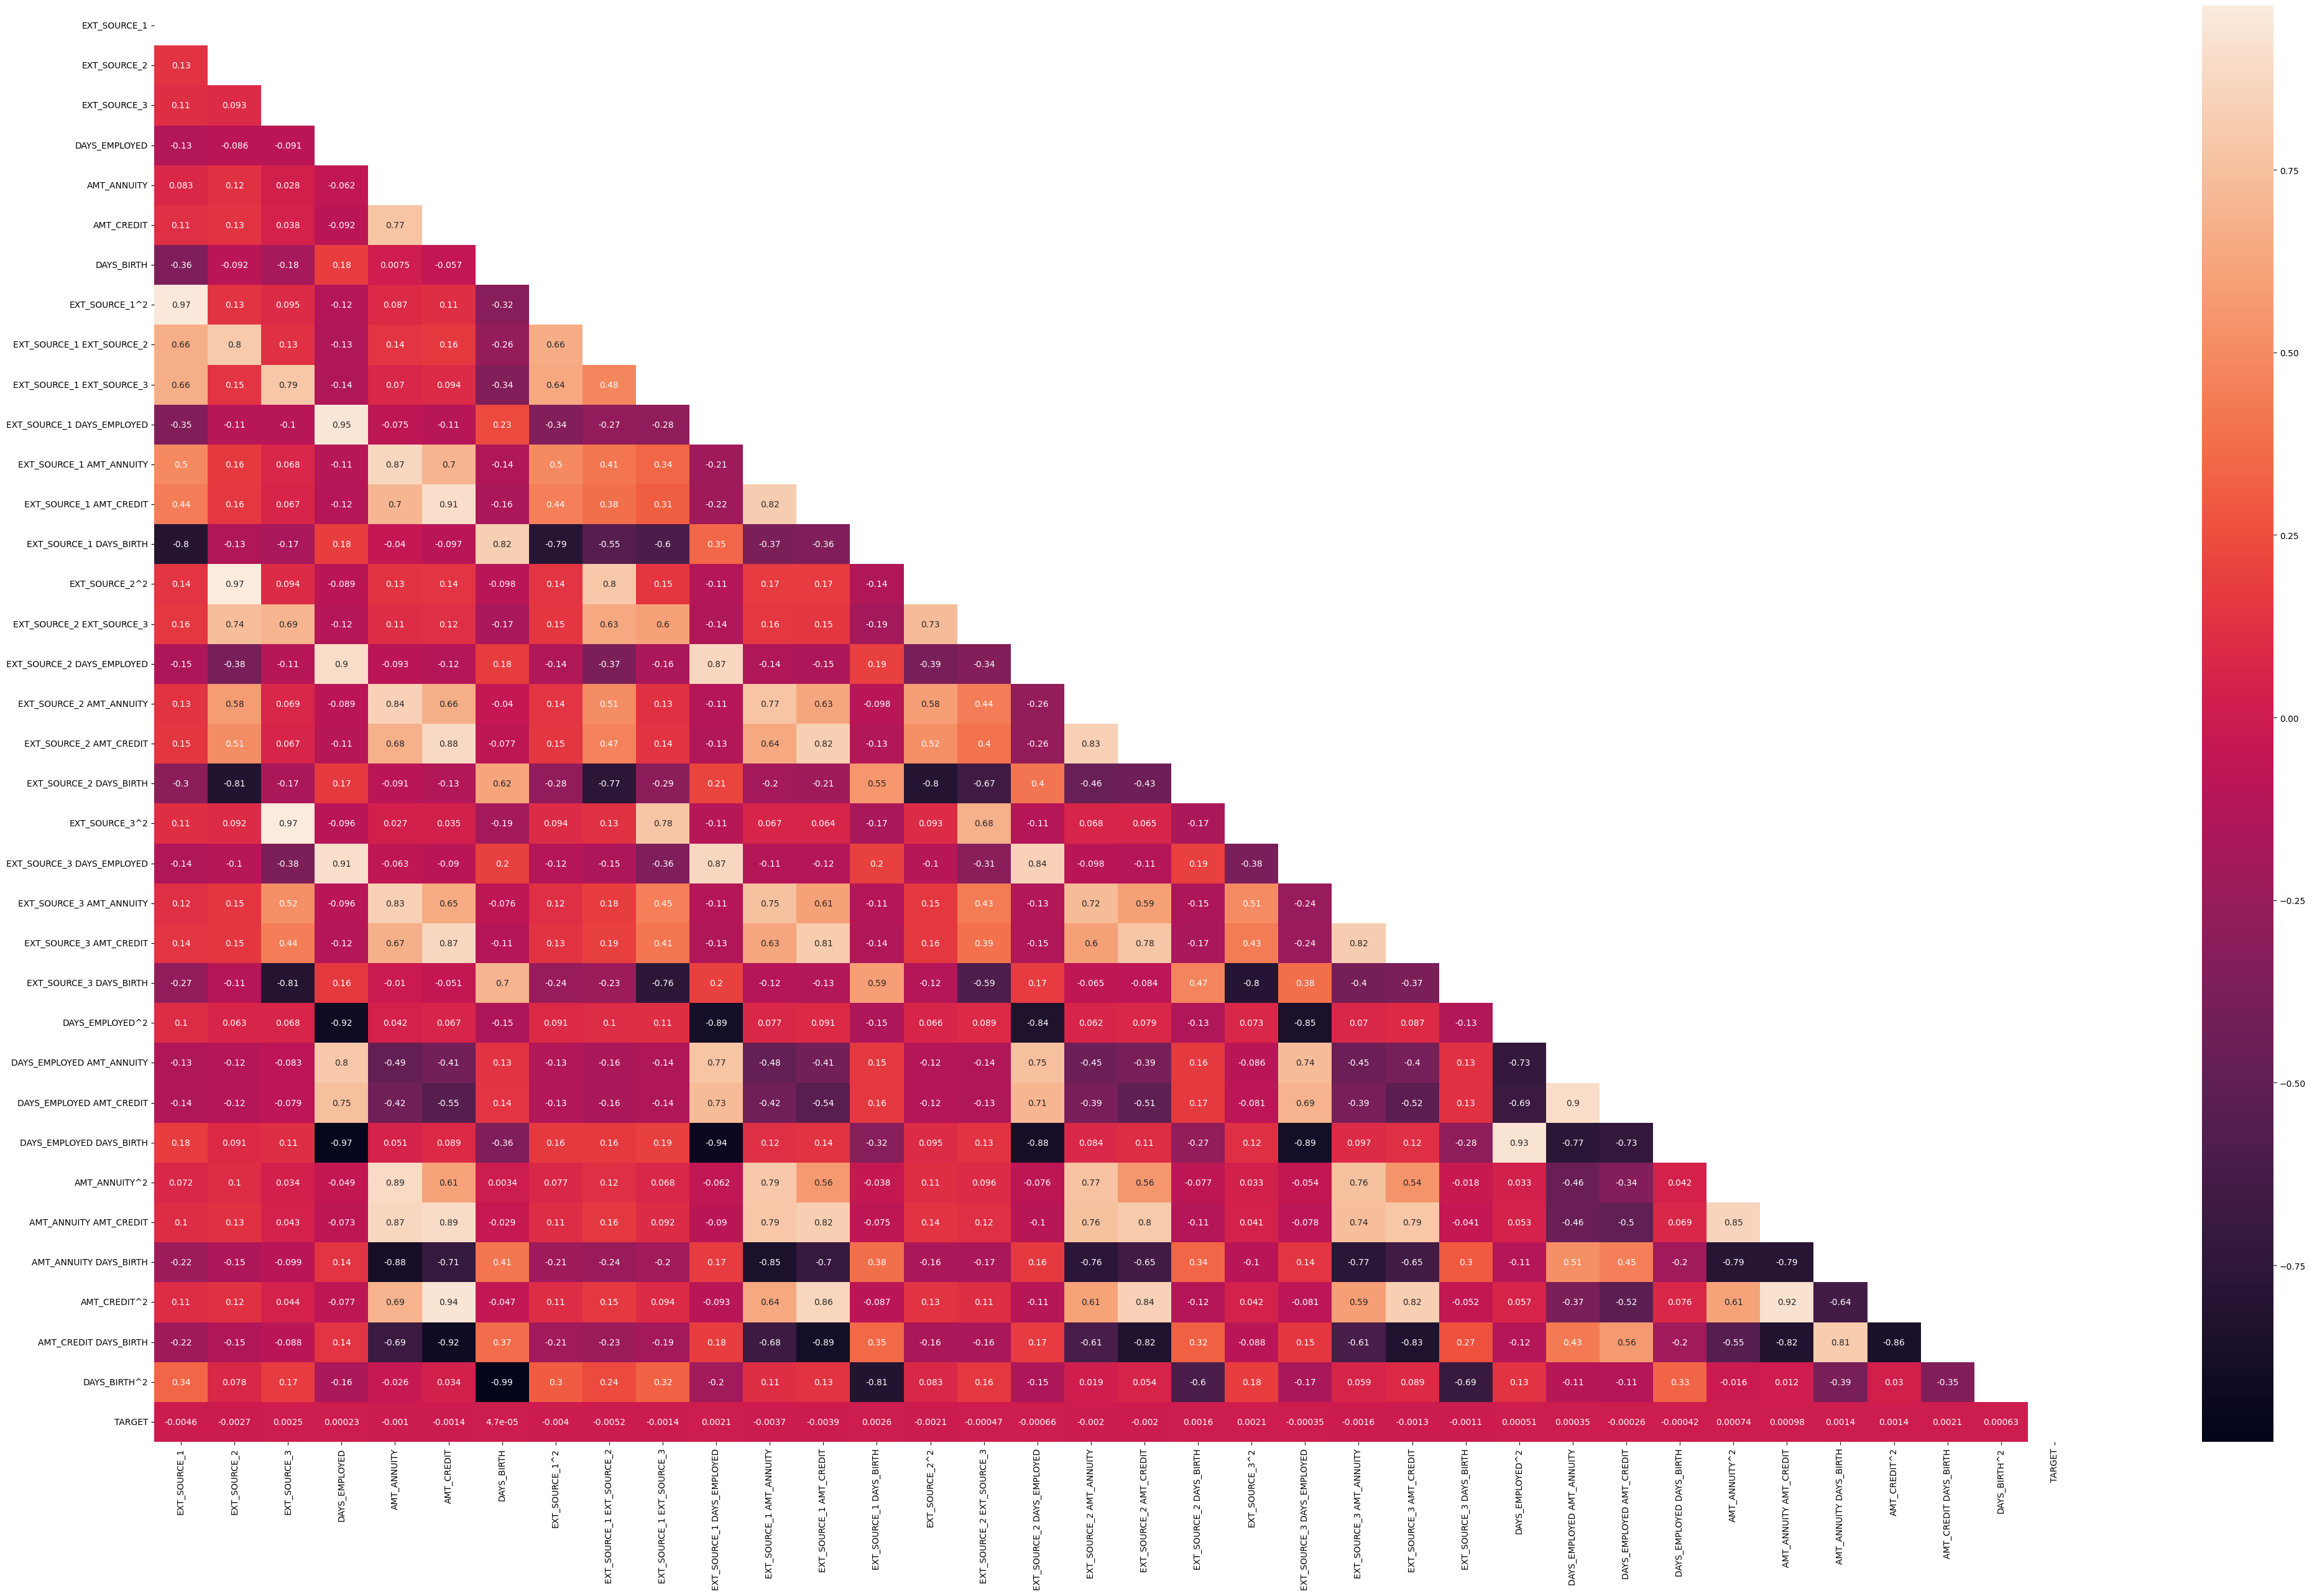

In [266]:
plt.figure(figsize=(50, 30))
matrix = np.triu(poly_corrs)
sns.heatmap(poly_corrs, annot=True, mask=matrix)

In [267]:
def new_features(X_train):
    X_train['DEBT_RATE']= X_train['AMT_ANNUITY'] / X_train['AMT_INCOME_TOTAL'] # Taux d'endettement
    X_train['KEEP_FOR_LIVING']= ((X_train['AMT_INCOME_TOTAL'] - X_train['AMT_ANNUITY'])/12)/X_train['CNT_FAM_MEMBERS'] #Reste a vivre mensuel
    X_train['INCOME_PER_PERSON']=X_train['AMT_INCOME_TOTAL'] / X_train['CNT_FAM_MEMBERS'] # Somme par personne dans le foyer
    return X_train


<Axes: >

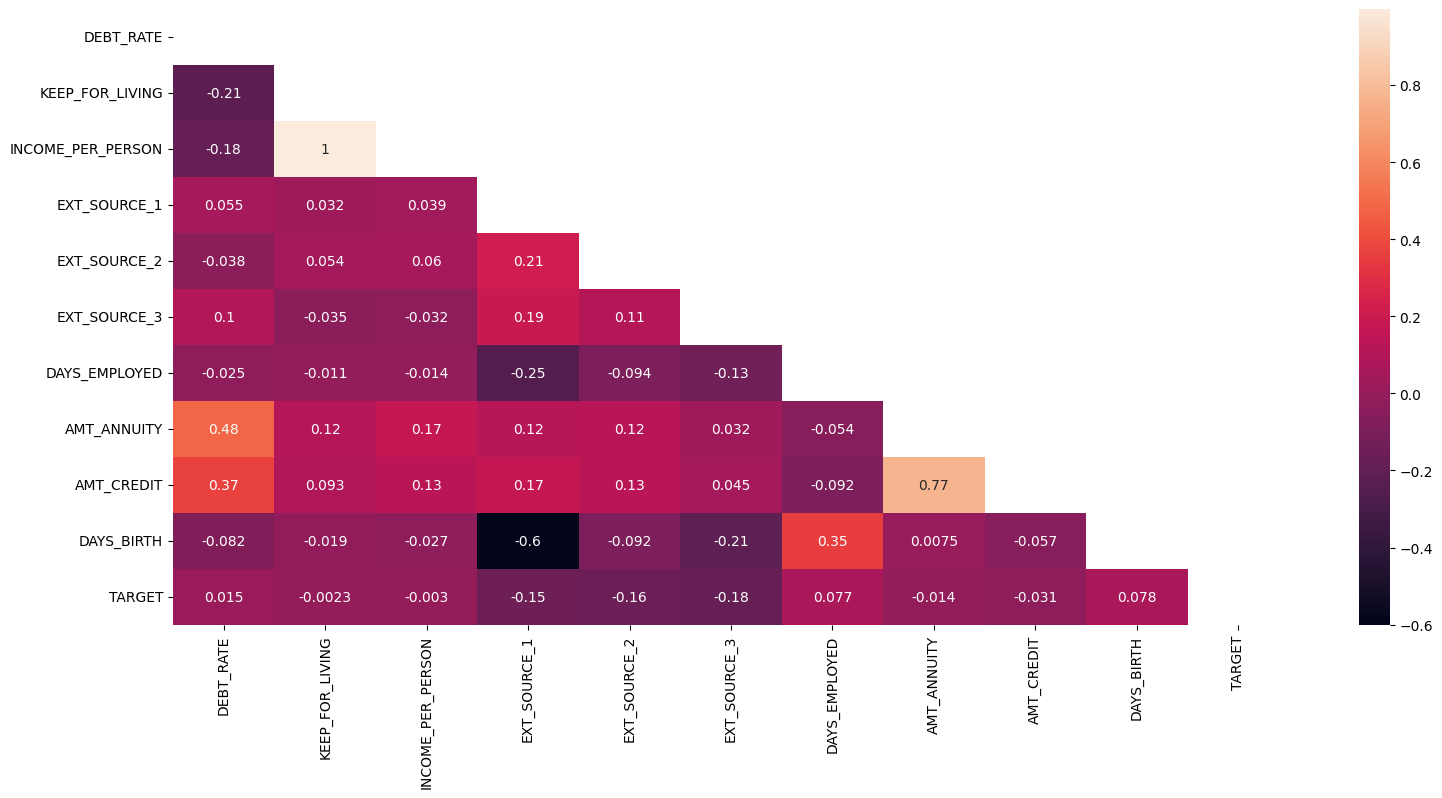

In [268]:
New_features =['DEBT_RATE','KEEP_FOR_LIVING','INCOME_PER_PERSON'] + poly_feature_choice
X_train=new_features(X_train)
X_train_NF = X_train[New_features]
plt.figure(figsize=(18,8))
X_train_NF_corr = X_train_NF.corr()
matrix = np.triu(X_train_NF_corr)
sns.heatmap(X_train_NF_corr, annot=True, mask=matrix)

In [293]:
display_info(title='Merging et agrégations de données', color="blue",fontsize="36px")
display_info(message="""Indispensable d'avoir une réflexion et une étape d'agrégation des données. Des informations complémentaires aux principaux fichiers peuvent en effet avoir un impact dans nos modélisations. Voyons comment traiter l'ensemble des jeux de données…""",fontsize="16px")


In [660]:
def load_data():
    data = app_train.copy()
    print(data.shape)
    return data
display_info(message=""" partir du fichier `bureau.csv`, il est possible d'extraire un historique sur les précédents crédits enregistrés par les clients. Il peut donc être intéressant d'enrichir l'échantillon avec ce type de données.</br>
             bureau : bureau.csv""")

In [661]:
print(bureau.head().to_string(max_cols=None))
print(f'dimension du df bureau : {bureau.shape}')
display_info(title="Merging Bureau file With app_train: Group and count previous loans", color='green')

   SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY
0      215354       5714462        Closed      currency 1         -497                   0               -153.0             -153.0                     NaN                   0         91323.0                  0.0                   NaN                     0.0  Consumer credit                -131          NaN
1      215354       5714463        Active      currency 1         -208                   0               1075.0                NaN                     NaN                   0        225000.0             171342.0                   NaN                     0.0      Credit card                 -20          NaN
2      215354       5714464        Active      currency 1         -203      

In [662]:
def group_bureau():
    previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count()
    previous_loan_counts = previous_loan_counts.rename(columns={'SK_ID_BUREAU' : 'PREVIOUS_LOANS_COUNT'}) 
    return previous_loan_counts
display_info(message="""On va merge app_train avec le fichier bureau regroupé (previsous_loan_counts) qui est notre fichier bureau avec le nombre de crédit souscrit""",fontsize="16px")


In [663]:
def merge_data_with_bureau_grouped(data,previous_loan_counts):
    print(f'data.shape avant merge: {data.shape}\n')
    data = data.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
    print(f'data.shape après merge: {data.shape}')
    return data

In [664]:
data = load_data()
previous_loan_counts = group_bureau()
data = merge_data_with_bureau_grouped(data,previous_loan_counts)

(307511, 122)
data.shape avant merge: (307511, 122)

data.shape après merge: (307511, 123)


In [665]:
display_info(title="Merging Bureau_balance file With app_train (merged)", color='green')
display_info(message="""On a donc bien ajouter notre colonne PREVIOUS_LOANS_COUNT a notre data.</br>
             Continuons avec bureau_balance.</br>
             bureau_balance = bureau_balance.csv""")

In [666]:
app_train.shape

(307511, 122)

In [667]:
print(f'app_train shape:\n {app_train.shape}')
print(f'bureau_balance shape:\n {bureau_balance.shape}')
print(f'bureau_balance.head:')
display(bureau_balance.head())
def bureau_bal_num_gouped(bureau_balance):
    bureau_balance_dummies = pd.get_dummies(bureau_balance, columns=['STATUS'])
    bureau_balance_counts = bureau_balance_dummies.groupby('SK_ID_BUREAU').sum().add_prefix('BUR_BAL_')
    bureau_balance_counts.rename(columns={'BUR_BAL_BY_STATUS_SK_ID_BUREAU':'SK_ID_BUREAU'})
    print(f'Pour chaque pret on compte le nombre de chaque status qui apparait sur le fichier Bureau_balance - shape :\n {bureau_balance_counts.shape}')
    display(bureau_balance_counts.head())
    return bureau_balance_counts

def bureau_merged(bureau_bal_mean):
    bureau_full = bureau.merge(bureau_bal_mean, on='SK_ID_BUREAU', how='left')
    bureau_full.drop('SK_ID_BUREAU', axis=1, inplace=True)
    print(f'Puis on merge bureau avec bureau_balance_mean:')
    display(bureau_full.head())
    # display(bureau_full.shape)
    return bureau_full

def all_bureau_grouped(bureau_full):
    print(f'On groupby `SK_ID_CURR` ensuite')
    bureau_full_numeric = bureau_full.select_dtypes(include=[float, int])
    bureau_mean = bureau_full.groupby('SK_ID_CURR', as_index=False)[bureau_full_numeric.columns].mean().add_prefix('PREV_BUR_MEAN_')
    bureau_mean = bureau_mean.rename(columns={'PREV_BUR_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})
    return bureau_mean

def merged_app_train_with_all_bureau(bureau_mean):
    print(f'Pour finir on merge avec app_train')
    data_all_bureau_with_app = data.merge(bureau_mean, on='SK_ID_CURR', how='left')
    # print(data_all_bureau_with_app.head())
    return data_all_bureau_with_app

pipeline_bureau_app =merged_app_train_with_all_bureau( all_bureau_grouped(bureau_merged(bureau_bal_num_gouped(bureau_balance))))
display_info(message=f"""On voit l'ajout de {pipeline_bureau_app.shape[1]-app_train.shape[1]} nouvelles features""",fontsize="16px", bgd='green', color='white')
display(pipeline_bureau_app.head())
display_info(message="""on a fusionné app_train, bureau et bureau_balance
             </br>Continuons avec les previous_aaplication, POS_CASH, instalments_payments et credit_card_balance""",fontsize="16px")
display_info(title="Merging previous_application avec app_train (merge: data)", color='green')


app_train shape:
 (307511, 122)
bureau_balance shape:
 (27299925, 3)
bureau_balance.head:


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

Pour chaque pret on compte le nombre de chaque status qui apparait sur le fichier Bureau_balance - shape :
 (817395, 9)


BUR_BAL_MONTHS_BALANCE  BUR_BAL_STATUS_0  BUR_BAL_STATUS_1  \
SK_ID_BUREAU                                                               
5001709                        -4656                 0                 0   
5001710                        -3403                 5                 0   
5001711                           -6                 3                 0   
5001712                         -171                10                 0   
5001713                         -231                 0                 0   

              BUR_BAL_STATUS_2  BUR_BAL_STATUS_3  BUR_BAL_STATUS_4  \
SK_ID_BUREAU                                                         
5001709                      0                 0                 0   
5001710                      0                 0                 0   
5001711                      0                 0                 0   
5001712                      0                 0                 0   
5001713                      0                 0                 0   

              BUR_BAL_STATUS_5  BUR_BAL_STATUS_C  BUR_BAL_STATUS_X  
SK_ID_BUREAU                                                        
5001709                      0                86                11  
5001710                      0                48                30  
5001711                      0                 0                 1  
5001712                      0                 9                 0  
5001713                      0                 0                22

Puis on merge bureau avec bureau_balance_mean:


SK_ID_CURR CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
0      215354        Closed      currency 1         -497                   0   
1      215354        Active      currency 1         -208                   0   
2      215354        Active      currency 1         -203                   0   
3      215354        Active      currency 1         -203                   0   
4      215354        Active      currency 1         -629                   0   

   DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
0               -153.0             -153.0                     NaN   
1               1075.0                NaN                     NaN   
2                528.0                NaN                     NaN   
3                  NaN                NaN                     NaN   
4               1197.0                NaN                 77674.5   

   CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
0                   0         91323.0                  0.0   
1                   0        225000.0             171342.0   
2                   0        464323.5                  NaN   
3                   0         90000.0                  NaN   
4                   0       2700000.0                  NaN   

   AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  \
0                   NaN                     0.0  Consumer credit   
1                   NaN                     0.0      Credit card   
2                   NaN                     0.0  Consumer credit   
3                   NaN                     0.0      Credit card   
4                   NaN                     0.0  Consumer credit   

   DAYS_CREDIT_UPDATE  AMT_ANNUITY  BUR_BAL_MONTHS_BALANCE  BUR_BAL_STATUS_0  \
0                -131          NaN                     NaN               NaN   
1                 -20          NaN                     NaN               NaN   
2                 -16          NaN                     NaN               NaN   
3                 -16          NaN                     NaN               NaN   
4                 -21          NaN                     NaN               NaN   

   BUR_BAL_STATUS_1  BUR_BAL_STATUS_2  BUR_BAL_STATUS_3  BUR_BAL_STATUS_4  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   

   BUR_BAL_STATUS_5  BUR_BAL_STATUS_C  BUR_BAL_STATUS_X  
0               NaN               NaN               NaN  
1               NaN               NaN               NaN  
2               NaN               NaN               NaN  
3               NaN               NaN               NaN  
4               NaN               NaN               NaN

On groupby `SK_ID_CURR` ensuite
Pour finir on merge avec app_train


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [748]:
display(previous_application.head())
display(previous_application.shape)
display_info(message="""Comme précédemment, commençons par quantifier le nombre de demandes précédentes des clients au crédit immobilier et ajoutons cette données à l'échantillon.""")


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

(1670214, 37)

In [760]:
def previous_application_split_AMTbyStatus(df):
    display_info(message='On separe les différents status des contrat de prets')
    convert_previous_app = pd.get_dummies(df, columns=['NAME_CONTRACT_TYPE','NAME_CONTRACT_STATUS'])
    for col in convert_previous_app.columns:
        if col.startswith('NAME_CONTRACT_STATUS'):
            convert_previous_app[col]=convert_previous_app.apply(lambda row: row['AMT_ANNUITY'] if row[col] else row[col], axis=1)
    return convert_previous_app

In [864]:
def previous_application_group(df):
    display_info(message='Puis on remplace chaque valeur True de la colonne status correspondant au montant du prêt demandé')
    keep_col = df[['SK_ID_CURR','SK_ID_PREV']]
    # display(keep_col)
    # return keep_col
    numeric_columns = df.select_dtypes(include=['int', 'float']).drop(columns=['SK_ID_PREV'])
    
    display_info(message='on fait la moyenne des colonnes')
    display_info(message='on a donc la moyenne des prêt par status que l\'on regroupe par `SK_ID_CURR`')
    
    previous_application_counts = numeric_columns.groupby(df['SK_ID_CURR'], as_index=False)[numeric_columns.columns].mean()
    previous_application_counts=previous_application_counts.merge(keep_col,on='SK_ID_CURR', how='left')
    
    suffix_cols=['AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','HOUR_APPR_PROCESS_START']
    previous_application_counts=previous_application_counts.rename(columns ={col: col + '_Prev_App' for col in suffix_cols})
    # display(df.head())
    return previous_application_counts


In [883]:
def merge_file(df1,df2, _on, _how):
    df1 = df1.merge(df2, on=_on, how=_how)
    return df1
# display_info(title="Merging credit_card_balance avec previous_application (origin)", color='green')


In [868]:
pipeline_previous_app=previous_application_group(previous_application_split_AMTbyStatus(previous_application))
display(pipeline_previous_app.head())
print("On merge ce fichier avec le fichier data contenant( app_train, bureau et bureau_balance)")

# display_info(title="Merging previous_application avec app_train (merge: data)", color='green')


SK_ID_CURR  AMT_ANNUITY_Prev_App  AMT_APPLICATION  AMT_CREDIT_Prev_App  \
0    100001.0              3951.000          24835.5              23787.0   
1    100002.0              9251.775         179055.0             179055.0   
2    100003.0             56553.990         435436.5             484191.0   
3    100003.0             56553.990         435436.5             484191.0   
4    100003.0             56553.990         435436.5             484191.0   

   AMT_DOWN_PAYMENT  AMT_GOODS_PRICE_Prev_App  \
0            2520.0                   24835.5   
1               0.0                  179055.0   
2            3442.5                  435436.5   
3            3442.5                  435436.5   
4            3442.5                  435436.5   

   HOUR_APPR_PROCESS_START_Prev_App  NFLAG_LAST_APPL_IN_DAY  \
0                         13.000000                     1.0   
1                          9.000000                     1.0   
2                         14.666667                     1.0   
3                         14.666667                     1.0   
4                         14.666667                     1.0   

   RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
0           0.104326                    NaN                       NaN   
1           0.000000                    NaN                       NaN   
2           0.050030                    NaN                       NaN   
3           0.050030                    NaN                       NaN   
4           0.050030                    NaN                       NaN   

   DAYS_DECISION  SELLERPLACE_AREA  CNT_PAYMENT  DAYS_FIRST_DRAWING  \
0        -1740.0              23.0          8.0            365243.0   
1         -606.0             500.0         24.0            365243.0   
2        -1305.0             533.0         10.0            365243.0   
3        -1305.0             533.0         10.0            365243.0   
4        -1305.0             533.0         10.0            365243.0   

   DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
0    -1709.000000               -1499.000000   -1619.000000      -1612.000000   
1     -565.000000                 125.000000     -25.000000        -17.000000   
2    -1274.333333               -1004.333333   -1054.333333      -1047.333333   
3    -1274.333333               -1004.333333   -1054.333333      -1047.333333   
4    -1274.333333               -1004.333333   -1054.333333      -1047.333333   

   NFLAG_INSURED_ON_APPROVAL  SK_ID_PREV  
0                   0.000000     1369693  
1                   0.000000     1038818  
2                   0.666667     1810518  
3                   0.666667     2636178  
4                   0.666667     2396755

On merge ce fichier avec le fichier data contenant( app_train, bureau et bureau_balance)


In [ ]:
display_info(message=f'nombre de feature dans data avant merge {data.shape[1]}', bgd='green', color='white')
data_with_previous_app = merge_file(data,pipeline_previous_app,'SK_ID_CURR','left')
display(data_with_previous_app.head())
display_info(message=f'nombre de feature dans data après merge {data_with_previous_app.shape[1]}', bgd='green', color='white')

In [814]:
installments_payments_c = installments_payments.copy()
def define_exceed_date(df):
    display_info(message="On crée une nouvelle feature DATE_EXCEEDED qui nous informe du retard de paiement du client en nombre de jours si date> 0 alors en retard du nombre de jour")
    df['DATE_EXCEEDED'] = df['DAYS_ENTRY_PAYMENT'] - df['DAYS_INSTALMENT']
    df= df.groupby('SK_ID_PREV', as_index=False).mean()
    display_info(message="On regroupe par `SK_ID_PREV` et on fait la moyenne")
    df.drop('SK_ID_CURR', axis=1, inplace=True)
    return df


In [820]:
pipeline_previous_app.head()

SK_ID_CURR  AMT_ANNUITY_Prev_App  AMT_APPLICATION  AMT_CREDIT_Prev_App  \
0    100001.0              3951.000         24835.50             23787.00   
1    100002.0              9251.775        179055.00            179055.00   
2    100003.0             56553.990        435436.50            484191.00   
3    100004.0              5357.250         24282.00             20106.00   
4    100005.0              4813.200         22308.75             20076.75   

   AMT_DOWN_PAYMENT  AMT_GOODS_PRICE_Prev_App  \
0            2520.0                   24835.5   
1               0.0                  179055.0   
2            3442.5                  435436.5   
3            4860.0                   24282.0   
4            4464.0                   44617.5   

   HOUR_APPR_PROCESS_START_Prev_App  NFLAG_LAST_APPL_IN_DAY  \
0                         13.000000                     1.0   
1                          9.000000                     1.0   
2                         14.666667                     1.0   
3                          5.000000                     1.0   
4                         10.500000                     1.0   

   RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
0           0.104326                    NaN                       NaN   
1           0.000000                    NaN                       NaN   
2           0.050030                    NaN                       NaN   
3           0.212008                    NaN                       NaN   
4           0.108964                    NaN                       NaN   

   DAYS_DECISION  SELLERPLACE_AREA  CNT_PAYMENT  DAYS_FIRST_DRAWING  \
0        -1740.0              23.0          8.0            365243.0   
1         -606.0             500.0         24.0            365243.0   
2        -1305.0             533.0         10.0            365243.0   
3         -815.0              30.0          4.0            365243.0   
4         -536.0              18.0         12.0            365243.0   

   DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
0    -1709.000000               -1499.000000   -1619.000000      -1612.000000   
1     -565.000000                 125.000000     -25.000000        -17.000000   
2    -1274.333333               -1004.333333   -1054.333333      -1047.333333   
3     -784.000000                -694.000000    -724.000000       -714.000000   
4     -706.000000                -376.000000    -466.000000       -460.000000   

   NFLAG_INSURED_ON_APPROVAL  
0                   0.000000  
1                   0.000000  
2                   0.666667  
3                   0.000000  
4                   0.000000

In [874]:
pipeline_IP= define_exceed_date(installments_payments)
display(pipeline_IP.head())
display_info(message=f"""
Nombre de feature pipeline_previous_app: {pipeline_previous_app.shape[1]} </br>
Nombre de feature pipeline_IP: {pipeline_IP.shape[1]}\n
""")
merge_prev_app_W_instal_paymt = merge_file(pipeline_previous_app,pipeline_IP,'SK_ID_PREV','left')
display_info(message=f"""
Nombre de feature merge_prev_app_W_instal_paymt: {merge_prev_app_W_instal_paymt.shape[1]}\n
""")
display(merge_prev_app_W_instal_paymt.head())

SK_ID_PREV  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  \
0     1000001                1.500000               1.500000      -253.000000   
1     1000002                1.250000               2.500000     -1555.000000   
2     1000003                1.000000               2.000000       -64.000000   
3     1000004                1.142857               4.000000      -772.000000   
4     1000005                1.000000               5.818182     -1543.454545   

   DAYS_ENTRY_PAYMENT  AMT_INSTALMENT   AMT_PAYMENT  DATE_EXCEEDED  
0         -269.000000    34221.712500  34221.712500     -16.000000  
1        -1574.750000     9308.891250   9308.891250     -19.750000  
2          -79.333333     4951.350000   4951.350000     -15.333333  
3         -798.714286     4789.022143   4789.022143     -26.714286  
4        -1551.909091    14703.210000  13365.609545      -8.454545

SK_ID_CURR  AMT_ANNUITY_Prev_App  AMT_APPLICATION  AMT_CREDIT_Prev_App  \
0    100001.0              3951.000          24835.5              23787.0   
1    100002.0              9251.775         179055.0             179055.0   
2    100003.0             56553.990         435436.5             484191.0   
3    100003.0             56553.990         435436.5             484191.0   
4    100003.0             56553.990         435436.5             484191.0   

   AMT_DOWN_PAYMENT  AMT_GOODS_PRICE_Prev_App  \
0            2520.0                   24835.5   
1               0.0                  179055.0   
2            3442.5                  435436.5   
3            3442.5                  435436.5   
4            3442.5                  435436.5   

   HOUR_APPR_PROCESS_START_Prev_App  NFLAG_LAST_APPL_IN_DAY  \
0                         13.000000                     1.0   
1                          9.000000                     1.0   
2                         14.666667                     1.0   
3                         14.666667                     1.0   
4                         14.666667                     1.0   

   RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
0           0.104326                    NaN                       NaN   
1           0.000000                    NaN                       NaN   
2           0.050030                    NaN                       NaN   
3           0.050030                    NaN                       NaN   
4           0.050030                    NaN                       NaN   

   DAYS_DECISION  SELLERPLACE_AREA  CNT_PAYMENT  DAYS_FIRST_DRAWING  \
0        -1740.0              23.0          8.0            365243.0   
1         -606.0             500.0         24.0            365243.0   
2        -1305.0             533.0         10.0            365243.0   
3        -1305.0             533.0         10.0            365243.0   
4        -1305.0             533.0         10.0            365243.0   

   DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
0    -1709.000000               -1499.000000   -1619.000000      -1612.000000   
1     -565.000000                 125.000000     -25.000000        -17.000000   
2    -1274.333333               -1004.333333   -1054.333333      -1047.333333   
3    -1274.333333               -1004.333333   -1054.333333      -1047.333333   
4    -1274.333333               -1004.333333   -1054.333333      -1047.333333   

   NFLAG_INSURED_ON_APPROVAL  SK_ID_PREV  NUM_INSTALMENT_VERSION  \
0                   0.000000     1369693                1.250000   
1                   0.000000     1038818                1.052632   
2                   0.666667     1810518                1.142857   
3                   0.666667     2636178                1.000000   
4                   0.666667     2396755                1.000000   

   NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  \
0                    2.5          -1664.0        -1679.500000     7312.725000   
1                   10.0           -295.0         -315.421053    11559.247105   
2                    4.0           -626.0         -630.428571   164425.332857   
3                    3.5           -722.0         -733.166667    64518.990000   
4                    6.5          -2145.0        -2151.750000     6731.115000   

     AMT_PAYMENT  DATE_EXCEEDED  
0    7312.725000     -15.500000  
1   11559.247105     -20.421053  
2  164425.332857      -4.428571  
3   64518.990000     -11.166667  
4    6731.115000      -6.750000

In [875]:
display(credit_card_balance.head())
display(credit_card_balance.shape)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

(3840312, 23)

In [895]:
def credit_card_balance_mean(df):
    df=df.drop('SK_ID_CURR', axis=1)
    df = df.select_dtypes(include=[float, int])
    df = df.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('CARD_MEAN_')
    df.rename(columns={'CARD_MEAN_SK_ID_PREV':'SK_ID_PREV'}, inplace=True)
    # df['SK_ID_PREV'] = credit_card_balance['SK_ID_PREV']
    df = df.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('CARD_MEAN_')
    df.rename(columns={'CARD_MEAN_SK_ID_PREV':'SK_ID_PREV'}, inplace=True)
    display(df.head())
    return df

In [897]:
credit_card_balance_mean_df=credit_card_balance_mean(credit_card_balance)

SK_ID_PREV  CARD_MEAN_CARD_MEAN_MONTHS_BALANCE  \
0     1000018                                -4.0   
1     1000030                                -4.5   
2     1000031                                -8.5   
3     1000035                                -4.0   
4     1000077                                -7.0   

   CARD_MEAN_CARD_MEAN_AMT_BALANCE  \
0                     74946.285000   
1                     55991.064375   
2                     52394.439375   
3                         0.000000   
4                         0.000000   

   CARD_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL  \
0                                 81000.000000   
1                                 81562.500000   
2                                149625.000000   
3                                225000.000000   
4                                 94090.909091   

   CARD_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT  \
0                                   5400.000000   
1                                    642.857143   
2                                  12115.384615   
3                                           NaN   
4                                           NaN   

   CARD_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT  \
0                              29478.996000   
1                              17257.438125   
2                              28959.615000   
3                                  0.000000   
4                                  0.000000   

   CARD_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             NaN   
4                                             NaN   

   CARD_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT  \
0                                  24078.996000   
1                                  19079.929286   
2                                  23527.218462   
3                                           NaN   
4                                           NaN   

   CARD_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY  \
0                                  2594.088000   
1                                  2078.223750   
2                                  2675.300625   
3                                     0.000000   
4                                     0.000000   

   CARD_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT  \
0                              5541.750000   
1                              6188.631429   
2                             29543.257500   
3                                      NaN   
4                                      NaN   

   CARD_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT  \
0                                    5541.750000   
1                                    2657.947500   
2                                   22157.443125   
3                                       0.000000   
4                                       0.000000   

   CARD_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL  \
0                                  72298.197000   
1                                  55474.453125   
2                                  51402.878437   
3                                      0.000000   
4                                      0.000000   

   CARD_MEAN_CARD_MEAN_AMT_RECIVABLE  \
0                       73602.585000   
1                       55935.376875   
2                       52099.970625   
3                           0.000000   
4                           0.000000   

   CARD_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE  \
0                              73602.585000   
1                              55935.376875   
2                              52099.970625   
3                                  0.000000   
4                                  0.000000   

   CARD_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT  \
0                                      1.200000   
1                                      0.142857   
2                                      0.307692   
3           

In [894]:
display_info(message=f"""nombre de feature dans pipeline_previous_app avant merge {pipeline_previous_app.shape}""", bgd='green', color='white')
display_info(message=f"""nombre de feature dans credit_card_balance_mean_df avant merge {credit_card_balance_mean_df.shape}""", bgd='green', color='white')

merge_credit_balance_W_pipeline_previous_app= merge_file(pipeline_previous_app,credit_card_balance_mean_df,'SK_ID_PREV','left')
display(merge_credit_balance_W_pipeline_previous_app.head())
display_info(message=f"""nombre de feature dans merge_credit_balance_W_pipeline_previous_app avant merge {merge_credit_balance_W_pipeline_previous_app.shape}""", bgd='green', color='white')

SK_ID_CURR  AMT_ANNUITY_Prev_App  AMT_APPLICATION  AMT_CREDIT_Prev_App  \
0    100001.0              3951.000          24835.5              23787.0   
1    100002.0              9251.775         179055.0             179055.0   
2    100003.0             56553.990         435436.5             484191.0   
3    100003.0             56553.990         435436.5             484191.0   
4    100003.0             56553.990         435436.5             484191.0   

   AMT_DOWN_PAYMENT  AMT_GOODS_PRICE_Prev_App  \
0            2520.0                   24835.5   
1               0.0                  179055.0   
2            3442.5                  435436.5   
3            3442.5                  435436.5   
4            3442.5                  435436.5   

   HOUR_APPR_PROCESS_START_Prev_App  NFLAG_LAST_APPL_IN_DAY  \
0                         13.000000                     1.0   
1                          9.000000                     1.0   
2                         14.666667                     1.0   
3                         14.666667                     1.0   
4                         14.666667                     1.0   

   RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
0           0.104326                    NaN                       NaN   
1           0.000000                    NaN                       NaN   
2           0.050030                    NaN                       NaN   
3           0.050030                    NaN                       NaN   
4           0.050030                    NaN                       NaN   

   DAYS_DECISION  SELLERPLACE_AREA  CNT_PAYMENT  DAYS_FIRST_DRAWING  \
0        -1740.0              23.0          8.0            365243.0   
1         -606.0             500.0         24.0            365243.0   
2        -1305.0             533.0         10.0            365243.0   
3        -1305.0             533.0         10.0            365243.0   
4        -1305.0             533.0         10.0            365243.0   

   DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
0    -1709.000000               -1499.000000   -1619.000000      -1612.000000   
1     -565.000000                 125.000000     -25.000000        -17.000000   
2    -1274.333333               -1004.333333   -1054.333333      -1047.333333   
3    -1274.333333               -1004.333333   -1054.333333      -1047.333333   
4    -1274.333333               -1004.333333   -1054.333333      -1047.333333   

   NFLAG_INSURED_ON_APPROVAL  SK_ID_PREV  CARD_MEAN_CARD_MEAN_MONTHS_BALANCE  \
0                   0.000000     1369693                                 NaN   
1                   0.000000     1038818                                 NaN   
2                   0.666667     1810518                                 NaN   
3                   0.666667     2636178                                 NaN   
4                   0.666667     2396755                                 NaN   

   CARD_MEAN_CARD_MEAN_AMT_BALANCE  \
0                              NaN   
1                              NaN   
2                              NaN   
3                              NaN   
4                              NaN   

   CARD_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

   CARD_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

   CARD_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3      

In [900]:
pos_CASH_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [548]:
# print(installments_payments.shape)
installments_payments_grouped = installments_payments.drop('SK_ID_CURR',axis=1)
# installments_payments_grouped.head(25)
installments_payments_grouped = installments_payments_grouped.groupby('SK_ID_PREV').mean().add_prefix('PREV_INST_PAY_MEAN_')
installments_payments_grouped.head()
previous_application_test = previous_application.merge(installments_payments_grouped, on='SK_ID_PREV', how='left')
previous_application_test.shape

# previous_application_counts=previous_application_counts.merge(credit_card_balance_mean, on='SK_ID_PREV', how='left')
# print(previous_application_counts.shape)

(1670214, 103)

In [289]:
display_info(title='Metrics', color="blue",fontsize="36px")
display_info(message="""Notre objectif est de minimiser les Faux négatif car FN = 10FP.</br></br>
             Il faut donc limiter les mauvais client prédit bon client.</br></br>
             Cette metric est appelé Recall""",fontsize="16px")
display_info(fontsize="16px",message="""On utilisera aussi le F1-score qui est une métrique de classification qui mesure la capacité d’un modèle à bien prédire les individus positifs,
             tant en termes de precision (taux de prédictions positives correctes) qu’en termes de recall (taux de positifs correctement prédits).</br></br>
              Il correspond en effet à la moyenne harmonique de ces indicateurs, qui doivent tous deux être élevés pour que le F1-score le soit aussi. """)
